<a href="https://colab.research.google.com/github/anonymous0897/ICML_Draft/blob/main/Transductive_TL_Performance_Compiler.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

##Transductive TL Performance Compiler:

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from time import perf_counter



from sklearn.preprocessing import StandardScaler, MinMaxScaler
from imblearn.over_sampling import SMOTE
from imblearn.combine import SMOTETomek
from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import RandomOverSampler
from sklearn.model_selection import train_test_split
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import roc_curve, roc_auc_score, confusion_matrix, ConfusionMatrixDisplay, classification_report
import matplotlib.pyplot as plt
# !pip install pytorch-tabnet

# from pytorch_tabnet.tab_model import TabNetClassifier
import tensorflow as tf
from tensorflow.keras import layers, models
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay



## Data taken from the UCI Machine Learning repository [here](https://doi.org/10.24432/C53919):

In [ ]:
pip install ucimlrepo

In [ ]:
from ucimlrepo import fetch_ucirepo

# fetch dataset
cdc_diabetes_health_indicators = fetch_ucirepo(id=891)



In [ ]:
data = cdc_diabetes_health_indicators.data
# data (as pandas dataframes)
X = data.features
y = data.targets

# metadata
print(cdc_diabetes_health_indicators.metadata)

# variable information
print(cdc_diabetes_health_indicators.variables)

{'uci_id': 891, 'name': 'CDC Diabetes Health Indicators', 'repository_url': 'https://archive.ics.uci.edu/dataset/891/cdc+diabetes+health+indicators', 'data_url': 'https://archive.ics.uci.edu/static/public/891/data.csv', 'abstract': 'The Diabetes Health Indicators Dataset contains healthcare statistics and lifestyle survey information about people in general along with their diagnosis of diabetes. The 35 features consist of some demographics, lab test results, and answers to survey questions for each patient. The target variable for classification is whether a patient has diabetes, is pre-diabetic, or healthy. ', 'area': 'Health and Medicine', 'tasks': ['Classification'], 'characteristics': ['Tabular', 'Multivariate'], 'num_instances': 253680, 'num_features': 21, 'feature_types': ['Categorical', 'Integer'], 'demographics': ['Sex', 'Age', 'Education Level', 'Income'], 'target_col': ['Diabetes_binary'], 'index_col': ['ID'], 'has_missing_values': 'no', 'missing_values_symbol': None, 'year_

In [ ]:
X

,HighBP,HighChol,CholCheck,BMI,Smoker,Stroke,HeartDiseaseorAttack,PhysActivity,Fruits,Veggies,...,AnyHealthcare,NoDocbcCost,GenHlth,MentHlth,PhysHlth,DiffWalk,Sex,Age,Education,Income
0,1,1,1,40,1,0,0,0,0,1,...,1,0,5,18,15,1,0,9,4,3
1,0,0,0,25,1,0,0,1,0,0,...,0,1,3,0,0,0,0,7,6,1
2,1,1,1,28,0,0,0,0,1,0,...,1,1,5,30,30,1,0,9,4,8
3,1,0,1,27,0,0,0,1,1,1,...,1,0,2,0,0,0,0,11,3,6
4,1,1,1,24,0,0,0,1,1,1,...,1,0,2,3,0,0,0,11,5,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
253675,1,1,1,45,0,0,0,0,1,1,...,1,0,3,0,5,0,1,5,6,7
253676,1,1,1,18,0,0,0,0,0,0,...,1,0,4,0,0,1,0,11,2,4
253677,0,0,1,28,0,0,0,1,1,0,...,1,0,1,0,0,0,0,2,5,2
253678,1,0,1,23,0,0,0,0,1,1,...,1,0,3,0,0,0,1,7,5,1


In [ ]:
## Scaling the predictive data

scaler = MinMaxScaler()
scaler.fit(X)
X_scaled = scaler.transform(X)
X_scaled = pd.DataFrame(X_scaled)

In [ ]:
data2 = pd.concat([X_scaled, y], axis=1)
data2

,0,1,2,3,4,5,6,7,8,9,...,12,13,14,15,16,17,18,19,20,Diabetes_binary
0,1.0,1.0,1.0,0.325581,1.0,0.0,0.0,0.0,0.0,1.0,...,0.0,1.00,0.6,0.500000,1.0,0.0,0.666667,0.6,0.285714,0
1,0.0,0.0,0.0,0.151163,1.0,0.0,0.0,1.0,0.0,0.0,...,1.0,0.50,0.0,0.000000,0.0,0.0,0.500000,1.0,0.000000,0
2,1.0,1.0,1.0,0.186047,0.0,0.0,0.0,0.0,1.0,0.0,...,1.0,1.00,1.0,1.000000,1.0,0.0,0.666667,0.6,1.000000,0
3,1.0,0.0,1.0,0.174419,0.0,0.0,0.0,1.0,1.0,1.0,...,0.0,0.25,0.0,0.000000,0.0,0.0,0.833333,0.4,0.714286,0
4,1.0,1.0,1.0,0.139535,0.0,0.0,0.0,1.0,1.0,1.0,...,0.0,0.25,0.1,0.000000,0.0,0.0,0.833333,0.8,0.428571,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
253675,1.0,1.0,1.0,0.383721,0.0,0.0,0.0,0.0,1.0,1.0,...,0.0,0.50,0.0,0.166667,0.0,1.0,0.333333,1.0,0.857143,0
253676,1.0,1.0,1.0,0.069767,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.75,0.0,0.000000,1.0,0.0,0.833333,0.2,0.428571,1
253677,0.0,0.0,1.0,0.186047,0.0,0.0,0.0,1.0,1.0,0.0,...,0.0,0.00,0.0,0.000000,0.0,0.0,0.083333,0.8,0.142857,0
253678,1.0,0.0,1.0,0.127907,0.0,0.0,0.0,0.0,1.0,1.0,...,0.0,0.50,0.0,0.000000,0.0,1.0,0.500000,0.8,0.000000,0


In [ ]:
y.value_counts()

,count
Diabetes_binary,
0,218334
1,35346


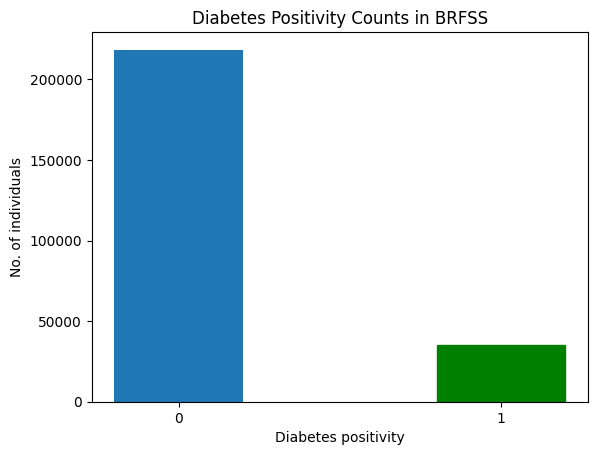

In [ ]:
barlist = plt.bar([str(0),str(1)], y.value_counts(), width = 0.4)
barlist[1].set_color('g')

plt.xlabel("Diabetes positivity")
plt.ylabel("No. of individuals")
plt.title("Diabetes Positivity Counts in BRFSS")
plt.show()

In [ ]:
X['Education'].value_counts()

,count
Education,
6,107325
5,69910
4,62750
3,9478
2,4043
1,174


In [ ]:
X_scaled[19].value_counts()

,count
19,
1.0,107325
0.8,69910
0.6,62750
0.4,9478
0.2,4043
0.0,174


# Splitting for Source and Target Domains:


# Full Dataset:

In [ ]:
data_S = data2[~data2[19].isin([0.0, 0.2])]  ## Source domain and classification
data_T = data2[data2[19].isin([0.0, 0.2])]  ## Target domain and classification

In [ ]:
data_S

,0,1,2,3,4,5,6,7,8,9,...,12,13,14,15,16,17,18,19,20,Diabetes_binary
0,1.0,1.0,1.0,0.325581,1.0,0.0,0.0,0.0,0.0,1.0,...,0.0,1.00,0.6,0.500000,1.0,0.0,0.666667,0.6,0.285714,0
1,0.0,0.0,0.0,0.151163,1.0,0.0,0.0,1.0,0.0,0.0,...,1.0,0.50,0.0,0.000000,0.0,0.0,0.500000,1.0,0.000000,0
2,1.0,1.0,1.0,0.186047,0.0,0.0,0.0,0.0,1.0,0.0,...,1.0,1.00,1.0,1.000000,1.0,0.0,0.666667,0.6,1.000000,0
3,1.0,0.0,1.0,0.174419,0.0,0.0,0.0,1.0,1.0,1.0,...,0.0,0.25,0.0,0.000000,0.0,0.0,0.833333,0.4,0.714286,0
4,1.0,1.0,1.0,0.139535,0.0,0.0,0.0,1.0,1.0,1.0,...,0.0,0.25,0.1,0.000000,0.0,0.0,0.833333,0.8,0.428571,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
253674,0.0,0.0,1.0,0.174419,0.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.00,0.0,0.000000,0.0,0.0,0.166667,1.0,0.571429,0
253675,1.0,1.0,1.0,0.383721,0.0,0.0,0.0,0.0,1.0,1.0,...,0.0,0.50,0.0,0.166667,0.0,1.0,0.333333,1.0,0.857143,0
253677,0.0,0.0,1.0,0.186047,0.0,0.0,0.0,1.0,1.0,0.0,...,0.0,0.00,0.0,0.000000,0.0,0.0,0.083333,0.8,0.142857,0
253678,1.0,0.0,1.0,0.127907,0.0,0.0,0.0,0.0,1.0,1.0,...,0.0,0.50,0.0,0.000000,0.0,1.0,0.500000,0.8,0.000000,0


In [ ]:
data_T

,0,1,2,3,4,5,6,7,8,9,...,12,13,14,15,16,17,18,19,20,Diabetes_binary
21,1.0,1.0,1.0,0.302326,1.0,0.0,0.0,0.0,1.0,1.0,...,0.0,1.00,0.5,1.000000,1.0,0.0,1.000000,0.2,0.285714,0
27,1.0,1.0,1.0,0.186047,1.0,0.0,1.0,0.0,0.0,1.0,...,0.0,0.75,0.0,0.000000,0.0,1.0,0.916667,0.2,0.428571,1
83,0.0,1.0,1.0,0.232558,0.0,0.0,1.0,1.0,0.0,0.0,...,0.0,0.00,0.0,0.000000,1.0,0.0,1.000000,0.2,0.142857,1
95,1.0,1.0,1.0,0.151163,1.0,0.0,1.0,0.0,1.0,1.0,...,0.0,1.00,0.5,1.000000,1.0,0.0,0.666667,0.2,0.285714,1
190,1.0,0.0,1.0,0.267442,1.0,0.0,0.0,1.0,1.0,1.0,...,0.0,0.75,0.0,0.033333,1.0,1.0,0.666667,0.2,0.571429,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
253645,1.0,0.0,1.0,0.267442,0.0,0.0,1.0,0.0,0.0,1.0,...,0.0,0.75,0.0,0.000000,0.0,1.0,0.166667,0.2,0.000000,0
253652,0.0,1.0,1.0,0.174419,0.0,0.0,0.0,1.0,1.0,0.0,...,0.0,0.75,0.0,1.000000,0.0,1.0,0.833333,0.2,0.285714,1
253669,0.0,1.0,1.0,0.174419,0.0,0.0,0.0,0.0,0.0,1.0,...,1.0,0.00,0.0,0.100000,0.0,1.0,0.416667,0.2,0.428571,0
253672,1.0,0.0,1.0,0.209302,1.0,0.0,1.0,1.0,1.0,1.0,...,0.0,0.50,0.0,0.000000,0.0,1.0,0.916667,0.2,0.000000,0


## Source domain and task labels:

In [ ]:
X_S_full = data_S.iloc[:, :21]
X_S_full       ## Source domain


y_S_full = data_S.iloc[:, 21]
y_S_full       ## Source classification (response)

,Diabetes_binary
0,0
1,0
2,0
3,0
4,0
...,...
253674,0
253675,0
253677,0
253678,0


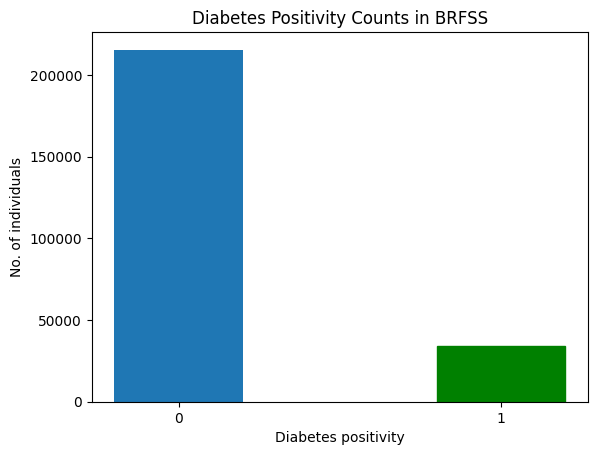

In [ ]:
barlist_S = plt.bar([str(0),str(1)], y_S_full.value_counts(), width = 0.4)
barlist_S[1].set_color('g')

plt.xlabel("Diabetes positivity")
plt.ylabel("No. of individuals")
plt.title("Diabetes Positivity Counts in BRFSS")
plt.show()

## Target domain and task labels:

In [ ]:
X_T_full = data_T.iloc[:, :21]
X_T_full       ## Target domain


y_T_full = data_T.iloc[:, 21]
y_T_full       ## Target classification (response)

,Diabetes_binary
21,0
27,1
83,1
95,1
190,0
...,...
253645,0
253652,1
253669,0
253672,0


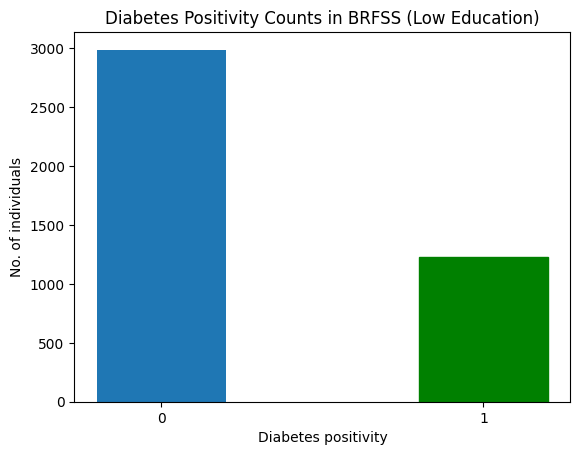

In [ ]:
barlist_T = plt.bar([str(0),str(1)], y_T_full.value_counts(), width = 0.4)
barlist_T[1].set_color('g')

plt.xlabel("Diabetes positivity")
plt.ylabel("No. of individuals")
plt.title("Diabetes Positivity Counts in BRFSS (Low Education)")
plt.show()

## DNN & Transductive TL Algorithms:

In [ ]:
def create_dnn_model(input_shape):
  model = models.Sequential([layers.Dense(64, activation='relu', input_dim=input_shape),
        layers.Dense(32, activation='relu'),
        layers.Dense(1, activation='sigmoid')  # For binary classification (yes/no diabetes)
    ])

  model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['AUC'])

  return model



def train_and_evaluate(model, X_train, X_test, y_train, y_test, domain):

    time_start = perf_counter()

    # Training and validation
    model.fit(X_train, y_train, epochs=10, batch_size=32, validation_split=0.2)

    # Predict probabilities and calculate AUC
    y_pred_prob = model.predict(X_test).ravel()
    auc = roc_auc_score(y_test, y_pred_prob)
    print(f"AUC-ROC: {auc}")

    # Compute ROC curve
    fpr, tpr, _ = roc_curve(y_test, y_pred_prob)

    # Convert probabilities to binary predictions for confusion matrix
    y_pred_class = (y_pred_prob >= 0.5).astype(int)

    # Compute and print classification report
    class_report = classification_report(y_test, y_pred_class)
    print("Classification Report:")
    print(class_report)

    # Compute confusion matrix
    conf_matrix = confusion_matrix(y_test, y_pred_class)
    # conf_disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix)

    # Plot ROC curve and Confusion Matrix side by side
    # fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))

    # # ROC Curve
    # ax1.plot(fpr, tpr, color='blue', label=f'AUC-ROC = {auc:.2f}')
    # ax1.plot([0, 1], [0, 1], color='gray', linestyle='--')
    # ax1.set_xlabel('False Positive Rate')
    # ax1.set_ylabel('True Positive Rate')
    # ax1.set_title('Receiver Operating Characteristic (ROC) Curve')
    # ax1.legend(loc='lower right')
    # ax1.grid()

    # # Confusion Matrix
    # conf_disp.plot(ax=ax2, cmap='Blues')
    # ax2.set_title('Confusion Matrix')
    # plt.tight_layout()
    # plt.show()

    # Calculate precision and recall for different thresholds
    precision, recall, thresholds = precision_recall_curve(y_test, y_pred_prob)

    # Find the threshold where precision and recall are balanced
    f1_scores = 2 * (precision * recall) / (precision + recall)
    best_threshold = thresholds[f1_scores.argmax()]

    print(f"Best threshold based on F1-score: {best_threshold}")

    time_stop = perf_counter()

    time_elapsed = time_stop-time_start

    print('Time elapsed (performance):', time_elapsed)
    return time_elapsed


In [ ]:
def Transductive_TL(model, X_test, y_test, domain):

    time_start = perf_counter()

    # Predict probabilities and calculate AUC
    y_pred_prob = model.predict(X_test).ravel()
    auc = roc_auc_score(y_test, y_pred_prob)
    print(f"AUC-ROC: {auc}")

    # Compute ROC curve
    fpr, tpr, _ = roc_curve(y_test, y_pred_prob)

    # Convert probabilities to binary predictions for confusion matrix
    y_pred_class = (y_pred_prob >= 0.5).astype(int)

    # Compute and print classification report
    class_report = classification_report(y_test, y_pred_class)
    print("Classification Report:")
    print(class_report)

    # Compute confusion matrix
    conf_matrix = confusion_matrix(y_test, y_pred_class)
    # conf_disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix)

    # Plot ROC curve and Confusion Matrix side by side
    # fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))

    # # ROC Curve
    # ax1.plot(fpr, tpr, color='blue', label=f'AUC-ROC = {auc:.2f}')
    # ax1.plot([0, 1], [0, 1], color='gray', linestyle='--')
    # ax1.set_xlabel('False Positive Rate')
    # ax1.set_ylabel('True Positive Rate')
    # ax1.set_title('Receiver Operating Characteristic (ROC) Curve')
    # ax1.legend(loc='lower right')
    # ax1.grid()

    # Confusion Matrix
    # print('Confusion matrix:', conf_matrix)
    fpr = conf_matrix[0][1]/(conf_matrix[0][0]+conf_matrix[0][1])
    tnr = 1-fpr

    fnr = conf_matrix[1][0]/(conf_matrix[1][0] + conf_matrix[1][1])
    tpr = 1 - fnr
    print('FPR', fpr, 'TPR:', tpr, 'FNR:', fnr, 'TNR:', tnr)
    # conf_disp.plot(ax=ax2, cmap='Blues')
    # ax2.set_title('Confusion Matrix')
    # plt.tight_layout()
    # plt.show()

    # Calculate precision and recall for different thresholds
    precision, recall, thresholds = precision_recall_curve(y_test, y_pred_prob)

    # Find the threshold where precision and recall are balanced
    f1_scores = 2 * (precision * recall) / (precision + recall)
    best_threshold = thresholds[f1_scores.argmax()]

    print(f"Best threshold based on F1-score: {best_threshold}")
    print('False Negative Rate:', fnr)

    time_stop = perf_counter()

    time_elapsed = time_stop-time_start

    print('Time elapsed (performance):', time_elapsed)

    return fpr, tnr, fnr, tpr, time_elapsed

In [ ]:
X_S_train, X_S_test, y_S_train, y_S_test = train_test_split(X_S_full, y_S_full, test_size=0.20, random_state=0)

In [ ]:
print('X_S_train:',np.shape(X_S_train))
print('y_S_train:',np.shape(y_S_train))
print('X_S_test:',np.shape(X_S_test))
print('y_S_test:',np.shape(y_S_test))

X_S_train: (199570, 21)
y_S_train: (199570,)
X_S_test: (49893, 21)
y_S_test: (49893,)


In [ ]:
model_source = create_dnn_model(X_S_train.shape[1])

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [ ]:
times = 20

Training_time = []
FPR = []
TPR = []
FNR = []
TNR = []
TL_time = []


for i in range(times):
    X_S_train, X_S_test, y_S_train, y_S_test = train_test_split(X_S_full, y_S_full, test_size=0.20, random_state=0)
    model_source = create_dnn_model(X_S_train.shape[1])
    result_imbalanced = train_and_evaluate(model_source, X_S_train, X_S_test, y_S_train, y_S_test, "Source")
    result_TL_imbalanced = Transductive_TL(model_source, X_T_full, y_T_full, "Target")

    Training_time.append(result_imbalanced)
    FPR.append(result_TL_imbalanced[0])
    TPR.append(result_TL_imbalanced[1])
    FNR.append(result_TL_imbalanced[2])
    TNR.append(result_TL_imbalanced[3])
    TL_time.append(result_TL_imbalanced[4])

ParamFit = pd.DataFrame([Training_time, FPR, TPR, FNR, TNR, TL_time]).T
ParamFit.columns=['Source time', 'FPR', 'TPR', 'FNR', 'TNR', 'Target time']
# print(ParamFit)

Epoch 1/10


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


4990/4990 ━━━━━━━━━━━━━━━━━━━━ 14s 2ms/step - AUC: 0.7894 - loss: 0.3326 - val_AUC: 0.8201 - val_loss: 0.3128
Epoch 2/10
4990/4990 ━━━━━━━━━━━━━━━━━━━━ 12s 2ms/step - AUC: 0.8230 - loss: 0.3120 - val_AUC: 0.8224 - val_loss: 0.3191
Epoch 3/10
4990/4990 ━━━━━━━━━━━━━━━━━━━━ 20s 2ms/step - AUC: 0.8225 - loss: 0.3119 - val_AUC: 0.8249 - val_loss: 0.3112
Epoch 4/10
4990/4990 ━━━━━━━━━━━━━━━━━━━━ 13s 3ms/step - AUC: 0.8261 - loss: 0.3092 - val_AUC: 0.8249 - val_loss: 0.3111
Epoch 5/10
4990/4990 ━━━━━━━━━━━━━━━━━━━━ 13s 3ms/step - AUC: 0.8269 - loss: 0.3131 - val_AUC: 0.8260 - val_loss: 0.3095
Epoch 6/10
4990/4990 ━━━━━━━━━━━━━━━━━━━━ 19s 2ms/step - AUC: 0.8276 - loss: 0.3097 - val_AUC: 0.8256 - val_loss: 0.3096
Epoch 7/10
4990/4990 ━━━━━━━━━━━━━━━━━━━━ 11s 2ms/step - AUC: 0.8301 - loss: 0.3080 - val_AUC: 0.8259 - val_loss: 0.3093
Epoch 8/10
4990/4990 ━━━━━━━━━━━━━━━━━━━━ 23s 3ms/step - AUC: 0.8316 - loss: 0.3075 - val_AUC: 0.8266 - val_loss: 0.3088
Epoch 9/10
4990/4990 ━━━━━━━━━━━━━━━━━━━━ 2

<ipython-input-21-e44c5eb269c6>:62: RuntimeWarning: invalid value encountered in divide
  f1_scores = 2 * (precision * recall) / (precision + recall)


132/132 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
AUC-ROC: 0.7608676895272468
Classification Report:
              precision    recall  f1-score   support

           0       0.74      0.96      0.83      2987
           1       0.65      0.17      0.27      1230

    accuracy                           0.73      4217
   macro avg       0.69      0.56      0.55      4217
weighted avg       0.71      0.73      0.67      4217

FPR 0.03783059926347506 TPR: 0.9621694007365249 FNR: 0.832520325203252 TNR: 0.16747967479674797
Best threshold based on F1-score: 0.23725078999996185
False Negative Rate: 0.832520325203252
Time elapsed (performance): 0.4921484159999636
Epoch 1/10


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


4990/4990 ━━━━━━━━━━━━━━━━━━━━ 13s 2ms/step - AUC: 0.7873 - loss: 0.3304 - val_AUC: 0.8208 - val_loss: 0.3125
Epoch 2/10
4990/4990 ━━━━━━━━━━━━━━━━━━━━ 12s 2ms/step - AUC: 0.8235 - loss: 0.3122 - val_AUC: 0.8233 - val_loss: 0.3105
Epoch 3/10
4990/4990 ━━━━━━━━━━━━━━━━━━━━ 21s 2ms/step - AUC: 0.8233 - loss: 0.3111 - val_AUC: 0.8246 - val_loss: 0.3102
Epoch 4/10
4990/4990 ━━━━━━━━━━━━━━━━━━━━ 21s 2ms/step - AUC: 0.8277 - loss: 0.3079 - val_AUC: 0.8252 - val_loss: 0.3103
Epoch 5/10
4990/4990 ━━━━━━━━━━━━━━━━━━━━ 11s 2ms/step - AUC: 0.8275 - loss: 0.3088 - val_AUC: 0.8250 - val_loss: 0.3233
Epoch 6/10
4990/4990 ━━━━━━━━━━━━━━━━━━━━ 10s 2ms/step - AUC: 0.8275 - loss: 0.3098 - val_AUC: 0.8253 - val_loss: 0.3166
Epoch 7/10
4990/4990 ━━━━━━━━━━━━━━━━━━━━ 12s 2ms/step - AUC: 0.8295 - loss: 0.3104 - val_AUC: 0.8259 - val_loss: 0.3117
Epoch 8/10
4990/4990 ━━━━━━━━━━━━━━━━━━━━ 20s 2ms/step - AUC: 0.8297 - loss: 0.3089 - val_AUC: 0.8258 - val_loss: 0.3101
Epoch 9/10
4990/4990 ━━━━━━━━━━━━━━━━━━━━ 1

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


4990/4990 ━━━━━━━━━━━━━━━━━━━━ 15s 3ms/step - AUC: 0.7779 - loss: 0.3379 - val_AUC: 0.8216 - val_loss: 0.3125
Epoch 2/10
4990/4990 ━━━━━━━━━━━━━━━━━━━━ 21s 3ms/step - AUC: 0.8216 - loss: 0.3137 - val_AUC: 0.8213 - val_loss: 0.3132
Epoch 3/10
4990/4990 ━━━━━━━━━━━━━━━━━━━━ 20s 3ms/step - AUC: 0.8257 - loss: 0.3084 - val_AUC: 0.8229 - val_loss: 0.3143
Epoch 4/10
4990/4990 ━━━━━━━━━━━━━━━━━━━━ 14s 3ms/step - AUC: 0.8273 - loss: 0.3094 - val_AUC: 0.8250 - val_loss: 0.3092
Epoch 5/10
4990/4990 ━━━━━━━━━━━━━━━━━━━━ 14s 3ms/step - AUC: 0.8293 - loss: 0.3076 - val_AUC: 0.8252 - val_loss: 0.3167
Epoch 6/10
4990/4990 ━━━━━━━━━━━━━━━━━━━━ 13s 3ms/step - AUC: 0.8276 - loss: 0.3074 - val_AUC: 0.8253 - val_loss: 0.3100
Epoch 7/10
4990/4990 ━━━━━━━━━━━━━━━━━━━━ 19s 2ms/step - AUC: 0.8282 - loss: 0.3098 - val_AUC: 0.8264 - val_loss: 0.3089
Epoch 8/10
4990/4990 ━━━━━━━━━━━━━━━━━━━━ 11s 2ms/step - AUC: 0.8300 - loss: 0.3098 - val_AUC: 0.8265 - val_loss: 0.3091
Epoch 9/10
4990/4990 ━━━━━━━━━━━━━━━━━━━━ 2

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


4990/4990 ━━━━━━━━━━━━━━━━━━━━ 15s 3ms/step - AUC: 0.7661 - loss: 0.3457 - val_AUC: 0.8210 - val_loss: 0.3126
Epoch 2/10
4990/4990 ━━━━━━━━━━━━━━━━━━━━ 12s 2ms/step - AUC: 0.8224 - loss: 0.3118 - val_AUC: 0.8248 - val_loss: 0.3106
Epoch 3/10
4990/4990 ━━━━━━━━━━━━━━━━━━━━ 12s 2ms/step - AUC: 0.8239 - loss: 0.3124 - val_AUC: 0.8240 - val_loss: 0.3105
Epoch 4/10
4990/4990 ━━━━━━━━━━━━━━━━━━━━ 20s 2ms/step - AUC: 0.8262 - loss: 0.3111 - val_AUC: 0.8250 - val_loss: 0.3100
Epoch 5/10
4990/4990 ━━━━━━━━━━━━━━━━━━━━ 20s 2ms/step - AUC: 0.8261 - loss: 0.3101 - val_AUC: 0.8258 - val_loss: 0.3091
Epoch 6/10
4990/4990 ━━━━━━━━━━━━━━━━━━━━ 21s 2ms/step - AUC: 0.8258 - loss: 0.3082 - val_AUC: 0.8257 - val_loss: 0.3104
Epoch 7/10
4990/4990 ━━━━━━━━━━━━━━━━━━━━ 20s 2ms/step - AUC: 0.8306 - loss: 0.3060 - val_AUC: 0.8254 - val_loss: 0.3104
Epoch 8/10
4990/4990 ━━━━━━━━━━━━━━━━━━━━ 21s 2ms/step - AUC: 0.8285 - loss: 0.3078 - val_AUC: 0.8261 - val_loss: 0.3092
Epoch 9/10
4990/4990 ━━━━━━━━━━━━━━━━━━━━ 1

<ipython-input-21-e44c5eb269c6>:62: RuntimeWarning: invalid value encountered in divide
  f1_scores = 2 * (precision * recall) / (precision + recall)


132/132 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
AUC-ROC: 0.7579655471814176
Classification Report:
              precision    recall  f1-score   support

           0       0.75      0.93      0.83      2987
           1       0.61      0.25      0.35      1230

    accuracy                           0.73      4217
   macro avg       0.68      0.59      0.59      4217
weighted avg       0.71      0.73      0.69      4217

FPR 0.06595246066287244 TPR: 0.9340475393371276 FNR: 0.751219512195122 TNR: 0.24878048780487805
Best threshold based on F1-score: 0.22407841682434082
False Negative Rate: 0.751219512195122
Time elapsed (performance): 0.39892566799971974
Epoch 1/10


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


4990/4990 ━━━━━━━━━━━━━━━━━━━━ 14s 3ms/step - AUC: 0.7850 - loss: 0.3341 - val_AUC: 0.8210 - val_loss: 0.3128
Epoch 2/10
4990/4990 ━━━━━━━━━━━━━━━━━━━━ 20s 2ms/step - AUC: 0.8239 - loss: 0.3122 - val_AUC: 0.8217 - val_loss: 0.3122
Epoch 3/10
4990/4990 ━━━━━━━━━━━━━━━━━━━━ 12s 2ms/step - AUC: 0.8256 - loss: 0.3114 - val_AUC: 0.8250 - val_loss: 0.3101
Epoch 4/10
4990/4990 ━━━━━━━━━━━━━━━━━━━━ 22s 3ms/step - AUC: 0.8270 - loss: 0.3096 - val_AUC: 0.8252 - val_loss: 0.3096
Epoch 5/10
4990/4990 ━━━━━━━━━━━━━━━━━━━━ 12s 2ms/step - AUC: 0.8286 - loss: 0.3094 - val_AUC: 0.8251 - val_loss: 0.3100
Epoch 6/10
4990/4990 ━━━━━━━━━━━━━━━━━━━━ 14s 3ms/step - AUC: 0.8259 - loss: 0.3100 - val_AUC: 0.8266 - val_loss: 0.3091
Epoch 7/10
4990/4990 ━━━━━━━━━━━━━━━━━━━━ 19s 2ms/step - AUC: 0.8282 - loss: 0.3084 - val_AUC: 0.8264 - val_loss: 0.3089
Epoch 8/10
4990/4990 ━━━━━━━━━━━━━━━━━━━━ 12s 2ms/step - AUC: 0.8288 - loss: 0.3076 - val_AUC: 0.8265 - val_loss: 0.3087
Epoch 9/10
4990/4990 ━━━━━━━━━━━━━━━━━━━━ 1

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


4990/4990 ━━━━━━━━━━━━━━━━━━━━ 14s 2ms/step - AUC: 0.7859 - loss: 0.3341 - val_AUC: 0.8201 - val_loss: 0.3129
Epoch 2/10
4990/4990 ━━━━━━━━━━━━━━━━━━━━ 22s 3ms/step - AUC: 0.8230 - loss: 0.3134 - val_AUC: 0.8209 - val_loss: 0.3131
Epoch 3/10
4990/4990 ━━━━━━━━━━━━━━━━━━━━ 13s 3ms/step - AUC: 0.8255 - loss: 0.3103 - val_AUC: 0.8237 - val_loss: 0.3125
Epoch 4/10
4990/4990 ━━━━━━━━━━━━━━━━━━━━ 13s 3ms/step - AUC: 0.8266 - loss: 0.3088 - val_AUC: 0.8244 - val_loss: 0.3128
Epoch 5/10
4990/4990 ━━━━━━━━━━━━━━━━━━━━ 21s 3ms/step - AUC: 0.8254 - loss: 0.3103 - val_AUC: 0.8248 - val_loss: 0.3106
Epoch 6/10
4990/4990 ━━━━━━━━━━━━━━━━━━━━ 13s 3ms/step - AUC: 0.8274 - loss: 0.3093 - val_AUC: 0.8249 - val_loss: 0.3098
Epoch 7/10
4990/4990 ━━━━━━━━━━━━━━━━━━━━ 21s 3ms/step - AUC: 0.8283 - loss: 0.3076 - val_AUC: 0.8253 - val_loss: 0.3128
Epoch 8/10
4990/4990 ━━━━━━━━━━━━━━━━━━━━ 13s 3ms/step - AUC: 0.8298 - loss: 0.3073 - val_AUC: 0.8258 - val_loss: 0.3092
Epoch 9/10
4990/4990 ━━━━━━━━━━━━━━━━━━━━ 1

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


4990/4990 ━━━━━━━━━━━━━━━━━━━━ 13s 2ms/step - AUC: 0.7763 - loss: 0.3407 - val_AUC: 0.8192 - val_loss: 0.3154
Epoch 2/10
4990/4990 ━━━━━━━━━━━━━━━━━━━━ 11s 2ms/step - AUC: 0.8224 - loss: 0.3141 - val_AUC: 0.8233 - val_loss: 0.3182
Epoch 3/10
4990/4990 ━━━━━━━━━━━━━━━━━━━━ 22s 3ms/step - AUC: 0.8244 - loss: 0.3111 - val_AUC: 0.8249 - val_loss: 0.3114
Epoch 4/10
4990/4990 ━━━━━━━━━━━━━━━━━━━━ 13s 3ms/step - AUC: 0.8253 - loss: 0.3108 - val_AUC: 0.8262 - val_loss: 0.3088
Epoch 5/10
4990/4990 ━━━━━━━━━━━━━━━━━━━━ 20s 3ms/step - AUC: 0.8276 - loss: 0.3089 - val_AUC: 0.8269 - val_loss: 0.3086
Epoch 6/10
4990/4990 ━━━━━━━━━━━━━━━━━━━━ 12s 2ms/step - AUC: 0.8295 - loss: 0.3079 - val_AUC: 0.8266 - val_loss: 0.3099
Epoch 7/10
4990/4990 ━━━━━━━━━━━━━━━━━━━━ 10s 2ms/step - AUC: 0.8283 - loss: 0.3082 - val_AUC: 0.8261 - val_loss: 0.3098
Epoch 8/10
4990/4990 ━━━━━━━━━━━━━━━━━━━━ 12s 2ms/step - AUC: 0.8299 - loss: 0.3078 - val_AUC: 0.8261 - val_loss: 0.3095
Epoch 9/10
4990/4990 ━━━━━━━━━━━━━━━━━━━━ 2

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


4990/4990 ━━━━━━━━━━━━━━━━━━━━ 15s 3ms/step - AUC: 0.7789 - loss: 0.3342 - val_AUC: 0.8212 - val_loss: 0.3121
Epoch 2/10
4990/4990 ━━━━━━━━━━━━━━━━━━━━ 19s 3ms/step - AUC: 0.8223 - loss: 0.3130 - val_AUC: 0.8236 - val_loss: 0.3141
Epoch 3/10
4990/4990 ━━━━━━━━━━━━━━━━━━━━ 13s 3ms/step - AUC: 0.8238 - loss: 0.3120 - val_AUC: 0.8247 - val_loss: 0.3119
Epoch 4/10
4990/4990 ━━━━━━━━━━━━━━━━━━━━ 12s 2ms/step - AUC: 0.8289 - loss: 0.3095 - val_AUC: 0.8246 - val_loss: 0.3099
Epoch 5/10
4990/4990 ━━━━━━━━━━━━━━━━━━━━ 21s 3ms/step - AUC: 0.8250 - loss: 0.3109 - val_AUC: 0.8259 - val_loss: 0.3090
Epoch 6/10
4990/4990 ━━━━━━━━━━━━━━━━━━━━ 12s 2ms/step - AUC: 0.8311 - loss: 0.3069 - val_AUC: 0.8256 - val_loss: 0.3109
Epoch 7/10
4990/4990 ━━━━━━━━━━━━━━━━━━━━ 12s 2ms/step - AUC: 0.8279 - loss: 0.3084 - val_AUC: 0.8258 - val_loss: 0.3094
Epoch 8/10
4990/4990 ━━━━━━━━━━━━━━━━━━━━ 12s 2ms/step - AUC: 0.8323 - loss: 0.3067 - val_AUC: 0.8245 - val_loss: 0.3109
Epoch 9/10
4990/4990 ━━━━━━━━━━━━━━━━━━━━ 1

<ipython-input-21-e44c5eb269c6>:62: RuntimeWarning: invalid value encountered in divide
  f1_scores = 2 * (precision * recall) / (precision + recall)


132/132 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
AUC-ROC: 0.760137833048903
Classification Report:
              precision    recall  f1-score   support

           0       0.74      0.95      0.83      2987
           1       0.61      0.19      0.29      1230

    accuracy                           0.73      4217
   macro avg       0.68      0.57      0.56      4217
weighted avg       0.70      0.73      0.68      4217

FPR 0.05021760964178105 TPR: 0.949782390358219 FNR: 0.8073170731707318 TNR: 0.19268292682926824
Best threshold based on F1-score: 0.23748977482318878
False Negative Rate: 0.8073170731707318
Time elapsed (performance): 0.4444935779993102
Epoch 1/10


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


4990/4990 ━━━━━━━━━━━━━━━━━━━━ 14s 2ms/step - AUC: 0.7908 - loss: 0.3300 - val_AUC: 0.8206 - val_loss: 0.3127
Epoch 2/10
4990/4990 ━━━━━━━━━━━━━━━━━━━━ 21s 2ms/step - AUC: 0.8226 - loss: 0.3122 - val_AUC: 0.8238 - val_loss: 0.3115
Epoch 3/10
4990/4990 ━━━━━━━━━━━━━━━━━━━━ 20s 2ms/step - AUC: 0.8258 - loss: 0.3114 - val_AUC: 0.8249 - val_loss: 0.3113
Epoch 4/10
4990/4990 ━━━━━━━━━━━━━━━━━━━━ 11s 2ms/step - AUC: 0.8284 - loss: 0.3108 - val_AUC: 0.8256 - val_loss: 0.3103
Epoch 5/10
4990/4990 ━━━━━━━━━━━━━━━━━━━━ 22s 3ms/step - AUC: 0.8274 - loss: 0.3114 - val_AUC: 0.8265 - val_loss: 0.3092
Epoch 6/10
4990/4990 ━━━━━━━━━━━━━━━━━━━━ 12s 2ms/step - AUC: 0.8301 - loss: 0.3068 - val_AUC: 0.8264 - val_loss: 0.3106
Epoch 7/10
4990/4990 ━━━━━━━━━━━━━━━━━━━━ 22s 3ms/step - AUC: 0.8302 - loss: 0.3067 - val_AUC: 0.8259 - val_loss: 0.3101
Epoch 8/10
4990/4990 ━━━━━━━━━━━━━━━━━━━━ 20s 3ms/step - AUC: 0.8304 - loss: 0.3091 - val_AUC: 0.8207 - val_loss: 0.3127
Epoch 9/10
4990/4990 ━━━━━━━━━━━━━━━━━━━━ 1

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


4990/4990 ━━━━━━━━━━━━━━━━━━━━ 14s 3ms/step - AUC: 0.7873 - loss: 0.3325 - val_AUC: 0.8215 - val_loss: 0.3120
Epoch 2/10
4990/4990 ━━━━━━━━━━━━━━━━━━━━ 12s 2ms/step - AUC: 0.8210 - loss: 0.3130 - val_AUC: 0.8210 - val_loss: 0.3133
Epoch 3/10
4990/4990 ━━━━━━━━━━━━━━━━━━━━ 20s 2ms/step - AUC: 0.8232 - loss: 0.3108 - val_AUC: 0.8247 - val_loss: 0.3120
Epoch 4/10
4990/4990 ━━━━━━━━━━━━━━━━━━━━ 12s 2ms/step - AUC: 0.8274 - loss: 0.3111 - val_AUC: 0.8240 - val_loss: 0.3116
Epoch 5/10
4990/4990 ━━━━━━━━━━━━━━━━━━━━ 21s 3ms/step - AUC: 0.8284 - loss: 0.3095 - val_AUC: 0.8259 - val_loss: 0.3124
Epoch 6/10
4990/4990 ━━━━━━━━━━━━━━━━━━━━ 14s 3ms/step - AUC: 0.8263 - loss: 0.3085 - val_AUC: 0.8258 - val_loss: 0.3093
Epoch 7/10
4990/4990 ━━━━━━━━━━━━━━━━━━━━ 13s 3ms/step - AUC: 0.8273 - loss: 0.3111 - val_AUC: 0.8220 - val_loss: 0.3135
Epoch 8/10
4990/4990 ━━━━━━━━━━━━━━━━━━━━ 13s 3ms/step - AUC: 0.8305 - loss: 0.3085 - val_AUC: 0.8264 - val_loss: 0.3089
Epoch 9/10
4990/4990 ━━━━━━━━━━━━━━━━━━━━ 1

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


4990/4990 ━━━━━━━━━━━━━━━━━━━━ 14s 2ms/step - AUC: 0.7773 - loss: 0.3372 - val_AUC: 0.8215 - val_loss: 0.3125
Epoch 2/10
4990/4990 ━━━━━━━━━━━━━━━━━━━━ 21s 3ms/step - AUC: 0.8216 - loss: 0.3123 - val_AUC: 0.8230 - val_loss: 0.3108
Epoch 3/10
4990/4990 ━━━━━━━━━━━━━━━━━━━━ 22s 3ms/step - AUC: 0.8240 - loss: 0.3110 - val_AUC: 0.8228 - val_loss: 0.3109
Epoch 4/10
4990/4990 ━━━━━━━━━━━━━━━━━━━━ 19s 2ms/step - AUC: 0.8272 - loss: 0.3093 - val_AUC: 0.8247 - val_loss: 0.3098
Epoch 5/10
4990/4990 ━━━━━━━━━━━━━━━━━━━━ 14s 3ms/step - AUC: 0.8271 - loss: 0.3094 - val_AUC: 0.8258 - val_loss: 0.3090
Epoch 6/10
4990/4990 ━━━━━━━━━━━━━━━━━━━━ 13s 3ms/step - AUC: 0.8251 - loss: 0.3090 - val_AUC: 0.8264 - val_loss: 0.3087
Epoch 7/10
4990/4990 ━━━━━━━━━━━━━━━━━━━━ 13s 3ms/step - AUC: 0.8300 - loss: 0.3076 - val_AUC: 0.8254 - val_loss: 0.3105
Epoch 8/10
4990/4990 ━━━━━━━━━━━━━━━━━━━━ 21s 3ms/step - AUC: 0.8276 - loss: 0.3114 - val_AUC: 0.8256 - val_loss: 0.3095
Epoch 9/10
4990/4990 ━━━━━━━━━━━━━━━━━━━━ 2

<ipython-input-21-e44c5eb269c6>:62: RuntimeWarning: invalid value encountered in divide
  f1_scores = 2 * (precision * recall) / (precision + recall)


132/132 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
AUC-ROC: 0.7621913114008945
Classification Report:
              precision    recall  f1-score   support

           0       0.73      0.97      0.84      2987
           1       0.67      0.13      0.22      1230

    accuracy                           0.73      4217
   macro avg       0.70      0.55      0.53      4217
weighted avg       0.71      0.73      0.66      4217

FPR 0.027452293270840308 TPR: 0.9725477067291597 FNR: 0.865040650406504 TNR: 0.13495934959349598
Best threshold based on F1-score: 0.26508253812789917
False Negative Rate: 0.865040650406504
Time elapsed (performance): 0.41393764700023894
Epoch 1/10


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


4990/4990 ━━━━━━━━━━━━━━━━━━━━ 14s 2ms/step - AUC: 0.7840 - loss: 0.3331 - val_AUC: 0.8185 - val_loss: 0.3141
Epoch 2/10
4990/4990 ━━━━━━━━━━━━━━━━━━━━ 22s 3ms/step - AUC: 0.8209 - loss: 0.3135 - val_AUC: 0.8222 - val_loss: 0.3112
Epoch 3/10
4990/4990 ━━━━━━━━━━━━━━━━━━━━ 21s 3ms/step - AUC: 0.8240 - loss: 0.3121 - val_AUC: 0.8260 - val_loss: 0.3091
Epoch 4/10
4990/4990 ━━━━━━━━━━━━━━━━━━━━ 14s 3ms/step - AUC: 0.8270 - loss: 0.3116 - val_AUC: 0.8258 - val_loss: 0.3096
Epoch 5/10
4990/4990 ━━━━━━━━━━━━━━━━━━━━ 14s 3ms/step - AUC: 0.8270 - loss: 0.3096 - val_AUC: 0.8255 - val_loss: 0.3114
Epoch 6/10
4990/4990 ━━━━━━━━━━━━━━━━━━━━ 13s 3ms/step - AUC: 0.8271 - loss: 0.3091 - val_AUC: 0.8260 - val_loss: 0.3097
Epoch 7/10
4990/4990 ━━━━━━━━━━━━━━━━━━━━ 21s 3ms/step - AUC: 0.8301 - loss: 0.3073 - val_AUC: 0.8266 - val_loss: 0.3088
Epoch 8/10
4990/4990 ━━━━━━━━━━━━━━━━━━━━ 21s 3ms/step - AUC: 0.8268 - loss: 0.3094 - val_AUC: 0.8263 - val_loss: 0.3144
Epoch 9/10
4990/4990 ━━━━━━━━━━━━━━━━━━━━ 1

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


4990/4990 ━━━━━━━━━━━━━━━━━━━━ 14s 3ms/step - AUC: 0.7885 - loss: 0.3343 - val_AUC: 0.8197 - val_loss: 0.3203
Epoch 2/10
4990/4990 ━━━━━━━━━━━━━━━━━━━━ 13s 3ms/step - AUC: 0.8217 - loss: 0.3148 - val_AUC: 0.8207 - val_loss: 0.3146
Epoch 3/10
4990/4990 ━━━━━━━━━━━━━━━━━━━━ 12s 2ms/step - AUC: 0.8244 - loss: 0.3120 - val_AUC: 0.8236 - val_loss: 0.3104
Epoch 4/10
4990/4990 ━━━━━━━━━━━━━━━━━━━━ 11s 2ms/step - AUC: 0.8264 - loss: 0.3109 - val_AUC: 0.8249 - val_loss: 0.3113
Epoch 5/10
4990/4990 ━━━━━━━━━━━━━━━━━━━━ 14s 3ms/step - AUC: 0.8277 - loss: 0.3097 - val_AUC: 0.8264 - val_loss: 0.3138
Epoch 6/10
4990/4990 ━━━━━━━━━━━━━━━━━━━━ 21s 3ms/step - AUC: 0.8284 - loss: 0.3090 - val_AUC: 0.8257 - val_loss: 0.3102
Epoch 7/10
4990/4990 ━━━━━━━━━━━━━━━━━━━━ 12s 2ms/step - AUC: 0.8286 - loss: 0.3102 - val_AUC: 0.8257 - val_loss: 0.3097
Epoch 8/10
4990/4990 ━━━━━━━━━━━━━━━━━━━━ 13s 3ms/step - AUC: 0.8305 - loss: 0.3085 - val_AUC: 0.8259 - val_loss: 0.3095
Epoch 9/10
4990/4990 ━━━━━━━━━━━━━━━━━━━━ 2

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


4990/4990 ━━━━━━━━━━━━━━━━━━━━ 16s 3ms/step - AUC: 0.7836 - loss: 0.3336 - val_AUC: 0.8217 - val_loss: 0.3120
Epoch 2/10
4990/4990 ━━━━━━━━━━━━━━━━━━━━ 15s 3ms/step - AUC: 0.8222 - loss: 0.3133 - val_AUC: 0.8219 - val_loss: 0.3134
Epoch 3/10
4990/4990 ━━━━━━━━━━━━━━━━━━━━ 18s 2ms/step - AUC: 0.8249 - loss: 0.3122 - val_AUC: 0.8250 - val_loss: 0.3098
Epoch 4/10
4990/4990 ━━━━━━━━━━━━━━━━━━━━ 12s 2ms/step - AUC: 0.8259 - loss: 0.3100 - val_AUC: 0.8253 - val_loss: 0.3094
Epoch 5/10
4990/4990 ━━━━━━━━━━━━━━━━━━━━ 13s 3ms/step - AUC: 0.8286 - loss: 0.3074 - val_AUC: 0.8249 - val_loss: 0.3133
Epoch 6/10
4990/4990 ━━━━━━━━━━━━━━━━━━━━ 13s 3ms/step - AUC: 0.8293 - loss: 0.3078 - val_AUC: 0.8238 - val_loss: 0.3135
Epoch 7/10
4990/4990 ━━━━━━━━━━━━━━━━━━━━ 19s 2ms/step - AUC: 0.8269 - loss: 0.3088 - val_AUC: 0.8246 - val_loss: 0.3098
Epoch 8/10
4990/4990 ━━━━━━━━━━━━━━━━━━━━ 11s 2ms/step - AUC: 0.8292 - loss: 0.3088 - val_AUC: 0.8256 - val_loss: 0.3091
Epoch 9/10
4990/4990 ━━━━━━━━━━━━━━━━━━━━ 2

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


4990/4990 ━━━━━━━━━━━━━━━━━━━━ 15s 3ms/step - AUC: 0.7856 - loss: 0.3353 - val_AUC: 0.8212 - val_loss: 0.3119
Epoch 2/10
4990/4990 ━━━━━━━━━━━━━━━━━━━━ 19s 2ms/step - AUC: 0.8207 - loss: 0.3156 - val_AUC: 0.8218 - val_loss: 0.3172
Epoch 3/10
4990/4990 ━━━━━━━━━━━━━━━━━━━━ 21s 3ms/step - AUC: 0.8252 - loss: 0.3113 - val_AUC: 0.8253 - val_loss: 0.3097
Epoch 4/10
4990/4990 ━━━━━━━━━━━━━━━━━━━━ 13s 3ms/step - AUC: 0.8255 - loss: 0.3112 - val_AUC: 0.8250 - val_loss: 0.3132
Epoch 5/10
4990/4990 ━━━━━━━━━━━━━━━━━━━━ 12s 2ms/step - AUC: 0.8264 - loss: 0.3112 - val_AUC: 0.8253 - val_loss: 0.3125
Epoch 6/10
4990/4990 ━━━━━━━━━━━━━━━━━━━━ 11s 2ms/step - AUC: 0.8280 - loss: 0.3087 - val_AUC: 0.8262 - val_loss: 0.3093
Epoch 7/10
4990/4990 ━━━━━━━━━━━━━━━━━━━━ 10s 2ms/step - AUC: 0.8262 - loss: 0.3097 - val_AUC: 0.8247 - val_loss: 0.3096
Epoch 8/10
4990/4990 ━━━━━━━━━━━━━━━━━━━━ 12s 2ms/step - AUC: 0.8305 - loss: 0.3095 - val_AUC: 0.8251 - val_loss: 0.3095
Epoch 9/10
4990/4990 ━━━━━━━━━━━━━━━━━━━━ 2

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


4990/4990 ━━━━━━━━━━━━━━━━━━━━ 14s 3ms/step - AUC: 0.7776 - loss: 0.3430 - val_AUC: 0.8219 - val_loss: 0.3124
Epoch 2/10
4990/4990 ━━━━━━━━━━━━━━━━━━━━ 14s 3ms/step - AUC: 0.8212 - loss: 0.3139 - val_AUC: 0.8239 - val_loss: 0.3107
Epoch 3/10
4990/4990 ━━━━━━━━━━━━━━━━━━━━ 12s 2ms/step - AUC: 0.8262 - loss: 0.3098 - val_AUC: 0.8250 - val_loss: 0.3114
Epoch 4/10
4990/4990 ━━━━━━━━━━━━━━━━━━━━ 13s 3ms/step - AUC: 0.8244 - loss: 0.3110 - val_AUC: 0.8252 - val_loss: 0.3098
Epoch 5/10
4990/4990 ━━━━━━━━━━━━━━━━━━━━ 12s 2ms/step - AUC: 0.8278 - loss: 0.3093 - val_AUC: 0.8263 - val_loss: 0.3090
Epoch 6/10
4990/4990 ━━━━━━━━━━━━━━━━━━━━ 12s 2ms/step - AUC: 0.8304 - loss: 0.3090 - val_AUC: 0.8256 - val_loss: 0.3094
Epoch 7/10
4990/4990 ━━━━━━━━━━━━━━━━━━━━ 23s 3ms/step - AUC: 0.8305 - loss: 0.3061 - val_AUC: 0.8259 - val_loss: 0.3090
Epoch 8/10
4990/4990 ━━━━━━━━━━━━━━━━━━━━ 18s 2ms/step - AUC: 0.8303 - loss: 0.3086 - val_AUC: 0.8259 - val_loss: 0.3109
Epoch 9/10
4990/4990 ━━━━━━━━━━━━━━━━━━━━ 2

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


4990/4990 ━━━━━━━━━━━━━━━━━━━━ 14s 2ms/step - AUC: 0.7815 - loss: 0.3353 - val_AUC: 0.8202 - val_loss: 0.3126
Epoch 2/10
4990/4990 ━━━━━━━━━━━━━━━━━━━━ 20s 2ms/step - AUC: 0.8211 - loss: 0.3150 - val_AUC: 0.8242 - val_loss: 0.3106
Epoch 3/10
4990/4990 ━━━━━━━━━━━━━━━━━━━━ 21s 2ms/step - AUC: 0.8267 - loss: 0.3108 - val_AUC: 0.8245 - val_loss: 0.3102
Epoch 4/10
4990/4990 ━━━━━━━━━━━━━━━━━━━━ 12s 2ms/step - AUC: 0.8262 - loss: 0.3094 - val_AUC: 0.8243 - val_loss: 0.3109
Epoch 5/10
4990/4990 ━━━━━━━━━━━━━━━━━━━━ 11s 2ms/step - AUC: 0.8267 - loss: 0.3108 - val_AUC: 0.8264 - val_loss: 0.3089
Epoch 6/10
4990/4990 ━━━━━━━━━━━━━━━━━━━━ 11s 2ms/step - AUC: 0.8277 - loss: 0.3088 - val_AUC: 0.8260 - val_loss: 0.3089
Epoch 7/10
4990/4990 ━━━━━━━━━━━━━━━━━━━━ 12s 2ms/step - AUC: 0.8272 - loss: 0.3112 - val_AUC: 0.8269 - val_loss: 0.3103
Epoch 8/10
4990/4990 ━━━━━━━━━━━━━━━━━━━━ 20s 2ms/step - AUC: 0.8305 - loss: 0.3072 - val_AUC: 0.8264 - val_loss: 0.3085
Epoch 9/10
4990/4990 ━━━━━━━━━━━━━━━━━━━━ 2

<ipython-input-22-d1390ee1be4d>:54: RuntimeWarning: invalid value encountered in divide
  f1_scores = 2 * (precision * recall) / (precision + recall)
/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


4990/4990 ━━━━━━━━━━━━━━━━━━━━ 15s 3ms/step - AUC: 0.7867 - loss: 0.3332 - val_AUC: 0.8221 - val_loss: 0.3148
Epoch 2/10
4990/4990 ━━━━━━━━━━━━━━━━━━━━ 13s 3ms/step - AUC: 0.8224 - loss: 0.3138 - val_AUC: 0.8230 - val_loss: 0.3126
Epoch 3/10
4990/4990 ━━━━━━━━━━━━━━━━━━━━ 19s 2ms/step - AUC: 0.8248 - loss: 0.3105 - val_AUC: 0.8248 - val_loss: 0.3099
Epoch 4/10
4990/4990 ━━━━━━━━━━━━━━━━━━━━ 23s 3ms/step - AUC: 0.8262 - loss: 0.3095 - val_AUC: 0.8257 - val_loss: 0.3107
Epoch 5/10
4990/4990 ━━━━━━━━━━━━━━━━━━━━ 20s 3ms/step - AUC: 0.8295 - loss: 0.3076 - val_AUC: 0.8236 - val_loss: 0.3129
Epoch 6/10
4990/4990 ━━━━━━━━━━━━━━━━━━━━ 20s 3ms/step - AUC: 0.8295 - loss: 0.3099 - val_AUC: 0.8261 - val_loss: 0.3115
Epoch 7/10
4990/4990 ━━━━━━━━━━━━━━━━━━━━ 21s 3ms/step - AUC: 0.8287 - loss: 0.3098 - val_AUC: 0.8260 - val_loss: 0.3092
Epoch 8/10
4990/4990 ━━━━━━━━━━━━━━━━━━━━ 20s 3ms/step - AUC: 0.8281 - loss: 0.3098 - val_AUC: 0.8254 - val_loss: 0.3096
Epoch 9/10
4990/4990 ━━━━━━━━━━━━━━━━━━━━ 2

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


4990/4990 ━━━━━━━━━━━━━━━━━━━━ 14s 3ms/step - AUC: 0.7853 - loss: 0.3326 - val_AUC: 0.8218 - val_loss: 0.3124
Epoch 2/10
4990/4990 ━━━━━━━━━━━━━━━━━━━━ 13s 3ms/step - AUC: 0.8245 - loss: 0.3115 - val_AUC: 0.8226 - val_loss: 0.3112
Epoch 3/10
4990/4990 ━━━━━━━━━━━━━━━━━━━━ 12s 2ms/step - AUC: 0.8243 - loss: 0.3100 - val_AUC: 0.8247 - val_loss: 0.3099
Epoch 4/10
4990/4990 ━━━━━━━━━━━━━━━━━━━━ 20s 2ms/step - AUC: 0.8288 - loss: 0.3103 - val_AUC: 0.8268 - val_loss: 0.3097
Epoch 5/10
4990/4990 ━━━━━━━━━━━━━━━━━━━━ 12s 2ms/step - AUC: 0.8296 - loss: 0.3069 - val_AUC: 0.8244 - val_loss: 0.3111
Epoch 6/10
4990/4990 ━━━━━━━━━━━━━━━━━━━━ 21s 3ms/step - AUC: 0.8300 - loss: 0.3071 - val_AUC: 0.8267 - val_loss: 0.3091
Epoch 7/10
4990/4990 ━━━━━━━━━━━━━━━━━━━━ 20s 3ms/step - AUC: 0.8298 - loss: 0.3084 - val_AUC: 0.8268 - val_loss: 0.3090
Epoch 8/10
4990/4990 ━━━━━━━━━━━━━━━━━━━━ 12s 2ms/step - AUC: 0.8314 - loss: 0.3058 - val_AUC: 0.8250 - val_loss: 0.3163
Epoch 9/10
4990/4990 ━━━━━━━━━━━━━━━━━━━━ 1

<ipython-input-21-e44c5eb269c6>:62: RuntimeWarning: invalid value encountered in divide
  f1_scores = 2 * (precision * recall) / (precision + recall)


132/132 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
AUC-ROC: 0.7570071937746495
Classification Report:
              precision    recall  f1-score   support

           0       0.74      0.94      0.83      2987
           1       0.60      0.21      0.31      1230

    accuracy                           0.73      4217
   macro avg       0.67      0.58      0.57      4217
weighted avg       0.70      0.73      0.68      4217

FPR 0.0555741546702377 TPR: 0.9444258453297623 FNR: 0.7934959349593496 TNR: 0.20650406504065044
Best threshold based on F1-score: 0.2465474009513855
False Negative Rate: 0.7934959349593496
Time elapsed (performance): 0.4001853640002082
Epoch 1/10


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


4990/4990 ━━━━━━━━━━━━━━━━━━━━ 13s 2ms/step - AUC: 0.7883 - loss: 0.3328 - val_AUC: 0.8191 - val_loss: 0.3137
Epoch 2/10
4990/4990 ━━━━━━━━━━━━━━━━━━━━ 12s 2ms/step - AUC: 0.8243 - loss: 0.3106 - val_AUC: 0.8238 - val_loss: 0.3110
Epoch 3/10
4990/4990 ━━━━━━━━━━━━━━━━━━━━ 12s 2ms/step - AUC: 0.8265 - loss: 0.3098 - val_AUC: 0.8241 - val_loss: 0.3125
Epoch 4/10
4990/4990 ━━━━━━━━━━━━━━━━━━━━ 12s 2ms/step - AUC: 0.8274 - loss: 0.3116 - val_AUC: 0.8247 - val_loss: 0.3096
Epoch 5/10
4990/4990 ━━━━━━━━━━━━━━━━━━━━ 11s 2ms/step - AUC: 0.8274 - loss: 0.3101 - val_AUC: 0.8255 - val_loss: 0.3118
Epoch 6/10
4990/4990 ━━━━━━━━━━━━━━━━━━━━ 11s 2ms/step - AUC: 0.8289 - loss: 0.3086 - val_AUC: 0.8252 - val_loss: 0.3143
Epoch 7/10
4990/4990 ━━━━━━━━━━━━━━━━━━━━ 11s 2ms/step - AUC: 0.8294 - loss: 0.3090 - val_AUC: 0.8256 - val_loss: 0.3099
Epoch 8/10
4990/4990 ━━━━━━━━━━━━━━━━━━━━ 20s 2ms/step - AUC: 0.8292 - loss: 0.3085 - val_AUC: 0.8250 - val_loss: 0.3103
Epoch 9/10
4990/4990 ━━━━━━━━━━━━━━━━━━━━ 2

<ipython-input-22-d1390ee1be4d>:54: RuntimeWarning: invalid value encountered in divide
  f1_scores = 2 * (precision * recall) / (precision + recall)


In [ ]:
print(ParamFit)
ParamFit.to_csv('Imbalanced.csv')

    Source time       FPR       TPR       FNR       TNR  Target time
0    169.823434  0.037831  0.962169  0.832520  0.167480     0.492148
1    172.240320  0.066622  0.933378  0.744715  0.255285     0.306363
2    173.524201  0.036157  0.963843  0.856911  0.143089     0.363327
3    169.851805  0.065952  0.934048  0.751220  0.248780     0.398926
4    155.006351  0.050552  0.949448  0.791057  0.208943     0.410545
5    172.338158  0.074322  0.925678  0.730894  0.269106     0.778163
6    165.223163  0.046535  0.953465  0.820325  0.179675     0.406718
7    152.648413  0.050218  0.949782  0.807317  0.192683     0.444494
8    178.712067  0.070639  0.929361  0.736585  0.263415     0.339133
9    152.223393  0.047205  0.952795  0.797561  0.202439     0.767075
10   182.324512  0.027452  0.972548  0.865041  0.134959     0.413938
11   180.057278  0.054235  0.945765  0.780488  0.219512     0.408777
12   148.329698  0.042183  0.957817  0.823577  0.176423     0.324219
13   162.679543  0.071309  0.92869

# Random Undersampling (RUS) to balance Dataset:

## SRS Sample without Replacement:

In [ ]:
data_S
data_S_majority = data_S[data_S['Diabetes_binary'].isin([0])]
data_S_minority = data_S[data_S['Diabetes_binary'].isin([1])]

undersample_size = data_S_minority['Diabetes_binary'].size
oversample_size = data_S_majority['Diabetes_binary'].size

print(undersample_size)
print(oversample_size)

34116
215347


In [ ]:
times = 20

Training_time = []
FPR = []
TPR = []
FNR = []
TNR = []
TL_time = []


for i in range(times):
    data_S_maj_rus = data_S_majority.sample(n=undersample_size, replace=False)
    data_S_SRS_RUS = pd.concat([data_S_maj_rus, data_S_minority])
    X_S_SRS = data_S_SRS_RUS.iloc[:, :21]
    y_S_SRS = data_S_SRS_RUS.iloc[:, 21]
    X_S_train, X_S_test, y_S_train, y_S_test = train_test_split(X_S_SRS, y_S_SRS, test_size=0.20, random_state=0)
    model_SRS = create_dnn_model(X_S_train.shape[1])
    result_SRS = train_and_evaluate(model_SRS, X_S_train, X_S_test, y_S_train, y_S_test, "Source")
    result_TL_SRS = Transductive_TL(model_SRS, X_T_full, y_T_full, "Target")

    Training_time.append(result_SRS)
    FPR.append(result_TL_SRS[0])
    TPR.append(result_TL_SRS[1])
    FNR.append(result_TL_SRS[2])
    TNR.append(result_TL_SRS[3])
    TL_time.append(result_TL_SRS[4])

ParamFit = pd.DataFrame([Training_time, FPR, TPR, FNR, TNR, TL_time]).T
ParamFit.columns=['Source time', 'FPR', 'TPR', 'FNR', 'TNR', 'Target time']
# print(ParamFit)

Epoch 1/10


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1365/1365 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - AUC: 0.7769 - loss: 0.5611 - val_AUC: 0.8165 - val_loss: 0.5284
Epoch 2/10
1365/1365 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - AUC: 0.8205 - loss: 0.5138 - val_AUC: 0.8221 - val_loss: 0.5138
Epoch 3/10
1365/1365 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - AUC: 0.8231 - loss: 0.5093 - val_AUC: 0.8235 - val_loss: 0.5122
Epoch 4/10
1365/1365 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - AUC: 0.8271 - loss: 0.5054 - val_AUC: 0.8236 - val_loss: 0.5147
Epoch 5/10
1365/1365 ━━━━━━━━━━━━━━━━━━━━ 7s 4ms/step - AUC: 0.8246 - loss: 0.5079 - val_AUC: 0.8257 - val_loss: 0.5101
Epoch 6/10
1365/1365 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - AUC: 0.8271 - loss: 0.5048 - val_AUC: 0.8253 - val_loss: 0.5104
Epoch 7/10
1365/1365 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - AUC: 0.8274 - loss: 0.5054 - val_AUC: 0.8260 - val_loss: 0.5159
Epoch 8/10
1365/1365 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - AUC: 0.8307 - loss: 0.4993 - val_AUC: 0.8268 - val_loss: 0.5079
Epoch 9/10
1365/1365 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/st

<ipython-input-21-e44c5eb269c6>:62: RuntimeWarning: invalid value encountered in divide
  f1_scores = 2 * (precision * recall) / (precision + recall)


132/132 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
AUC-ROC: 0.7611797463806576
Classification Report:
              precision    recall  f1-score   support

           0       0.93      0.34      0.50      2987
           1       0.37      0.94      0.53      1230

    accuracy                           0.52      4217
   macro avg       0.65      0.64      0.51      4217
weighted avg       0.77      0.52      0.51      4217

FPR 0.66052895882156 TPR: 0.33947104117843996 FNR: 0.05772357723577236 TNR: 0.9422764227642276
Best threshold based on F1-score: 0.7212837934494019
False Negative Rate: 0.05772357723577236
Time elapsed (performance): 0.4114067319997048
Epoch 1/10


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1365/1365 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - AUC: 0.7849 - loss: 0.5546 - val_AUC: 0.8183 - val_loss: 0.5203
Epoch 2/10
1365/1365 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - AUC: 0.8170 - loss: 0.5173 - val_AUC: 0.8258 - val_loss: 0.5080
Epoch 3/10
1365/1365 ━━━━━━━━━━━━━━━━━━━━ 7s 3ms/step - AUC: 0.8201 - loss: 0.5127 - val_AUC: 0.8268 - val_loss: 0.5110
Epoch 4/10
1365/1365 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - AUC: 0.8242 - loss: 0.5066 - val_AUC: 0.8282 - val_loss: 0.5050
Epoch 5/10
1365/1365 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - AUC: 0.8251 - loss: 0.5066 - val_AUC: 0.8288 - val_loss: 0.5057
Epoch 6/10
1365/1365 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - AUC: 0.8303 - loss: 0.5008 - val_AUC: 0.8293 - val_loss: 0.5038
Epoch 7/10
1365/1365 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - AUC: 0.8263 - loss: 0.5049 - val_AUC: 0.8300 - val_loss: 0.5035
Epoch 8/10
1365/1365 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - AUC: 0.8254 - loss: 0.5062 - val_AUC: 0.8308 - val_loss: 0.5020
Epoch 9/10
1365/1365 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/st

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1365/1365 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - AUC: 0.7761 - loss: 0.5644 - val_AUC: 0.8224 - val_loss: 0.5151
Epoch 2/10
1365/1365 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - AUC: 0.8151 - loss: 0.5193 - val_AUC: 0.8283 - val_loss: 0.5092
Epoch 3/10
1365/1365 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - AUC: 0.8248 - loss: 0.5083 - val_AUC: 0.8303 - val_loss: 0.5046
Epoch 4/10
1365/1365 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - AUC: 0.8208 - loss: 0.5127 - val_AUC: 0.8307 - val_loss: 0.5034
Epoch 5/10
1365/1365 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - AUC: 0.8248 - loss: 0.5062 - val_AUC: 0.8302 - val_loss: 0.5036
Epoch 6/10
1365/1365 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - AUC: 0.8261 - loss: 0.5055 - val_AUC: 0.8318 - val_loss: 0.5023
Epoch 7/10
1365/1365 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - AUC: 0.8251 - loss: 0.5077 - val_AUC: 0.8322 - val_loss: 0.5056
Epoch 8/10
1365/1365 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - AUC: 0.8291 - loss: 0.5031 - val_AUC: 0.8322 - val_loss: 0.5023
Epoch 9/10
1365/1365 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/st

<ipython-input-22-d1390ee1be4d>:54: RuntimeWarning: invalid value encountered in divide
  f1_scores = 2 * (precision * recall) / (precision + recall)
/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1365/1365 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - AUC: 0.7872 - loss: 0.5535 - val_AUC: 0.8172 - val_loss: 0.5198
Epoch 2/10
1365/1365 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - AUC: 0.8183 - loss: 0.5147 - val_AUC: 0.8234 - val_loss: 0.5148
Epoch 3/10
1365/1365 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - AUC: 0.8232 - loss: 0.5104 - val_AUC: 0.8254 - val_loss: 0.5094
Epoch 4/10
1365/1365 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - AUC: 0.8262 - loss: 0.5066 - val_AUC: 0.8252 - val_loss: 0.5131
Epoch 5/10
1365/1365 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - AUC: 0.8257 - loss: 0.5070 - val_AUC: 0.8261 - val_loss: 0.5083
Epoch 6/10
1365/1365 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - AUC: 0.8272 - loss: 0.5042 - val_AUC: 0.8269 - val_loss: 0.5109
Epoch 7/10
1365/1365 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - AUC: 0.8262 - loss: 0.5061 - val_AUC: 0.8275 - val_loss: 0.5069
Epoch 8/10
1365/1365 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - AUC: 0.8305 - loss: 0.5013 - val_AUC: 0.8275 - val_loss: 0.5080
Epoch 9/10
1365/1365 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/st

<ipython-input-22-d1390ee1be4d>:54: RuntimeWarning: invalid value encountered in divide
  f1_scores = 2 * (precision * recall) / (precision + recall)
/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1365/1365 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - AUC: 0.7842 - loss: 0.5577 - val_AUC: 0.8211 - val_loss: 0.5269
Epoch 2/10
1365/1365 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - AUC: 0.8159 - loss: 0.5181 - val_AUC: 0.8262 - val_loss: 0.5086
Epoch 3/10
1365/1365 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - AUC: 0.8220 - loss: 0.5116 - val_AUC: 0.8280 - val_loss: 0.5095
Epoch 4/10
1365/1365 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - AUC: 0.8245 - loss: 0.5084 - val_AUC: 0.8275 - val_loss: 0.5134
Epoch 5/10
1365/1365 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - AUC: 0.8249 - loss: 0.5077 - val_AUC: 0.8293 - val_loss: 0.5051
Epoch 6/10
1365/1365 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - AUC: 0.8224 - loss: 0.5101 - val_AUC: 0.8288 - val_loss: 0.5063
Epoch 7/10
1365/1365 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - AUC: 0.8287 - loss: 0.5031 - val_AUC: 0.8301 - val_loss: 0.5052
Epoch 8/10
1365/1365 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - AUC: 0.8264 - loss: 0.5056 - val_AUC: 0.8310 - val_loss: 0.5033
Epoch 9/10
1365/1365 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/st

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1365/1365 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - AUC: 0.7782 - loss: 0.5624 - val_AUC: 0.8187 - val_loss: 0.5172
Epoch 2/10
1365/1365 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - AUC: 0.8218 - loss: 0.5122 - val_AUC: 0.8256 - val_loss: 0.5103
Epoch 3/10
1365/1365 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - AUC: 0.8208 - loss: 0.5119 - val_AUC: 0.8269 - val_loss: 0.5076
Epoch 4/10
1365/1365 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - AUC: 0.8237 - loss: 0.5084 - val_AUC: 0.8273 - val_loss: 0.5120
Epoch 5/10
1365/1365 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - AUC: 0.8250 - loss: 0.5078 - val_AUC: 0.8279 - val_loss: 0.5074
Epoch 6/10
1365/1365 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - AUC: 0.8216 - loss: 0.5112 - val_AUC: 0.8270 - val_loss: 0.5086
Epoch 7/10
1365/1365 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - AUC: 0.8246 - loss: 0.5082 - val_AUC: 0.8287 - val_loss: 0.5085
Epoch 8/10
1365/1365 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - AUC: 0.8302 - loss: 0.5005 - val_AUC: 0.8270 - val_loss: 0.5163
Epoch 9/10
1365/1365 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/st

<ipython-input-22-d1390ee1be4d>:54: RuntimeWarning: invalid value encountered in divide
  f1_scores = 2 * (precision * recall) / (precision + recall)
/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1365/1365 ━━━━━━━━━━━━━━━━━━━━ 49s 4ms/step - AUC: 0.7760 - loss: 0.5636 - val_AUC: 0.8181 - val_loss: 0.5214
Epoch 2/10
1365/1365 ━━━━━━━━━━━━━━━━━━━━ 9s 3ms/step - AUC: 0.8167 - loss: 0.5181 - val_AUC: 0.8233 - val_loss: 0.5114
Epoch 3/10
1365/1365 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - AUC: 0.8209 - loss: 0.5130 - val_AUC: 0.8252 - val_loss: 0.5106
Epoch 4/10
1365/1365 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - AUC: 0.8217 - loss: 0.5116 - val_AUC: 0.8262 - val_loss: 0.5108
Epoch 5/10
1365/1365 ━━━━━━━━━━━━━━━━━━━━ 7s 4ms/step - AUC: 0.8236 - loss: 0.5083 - val_AUC: 0.8271 - val_loss: 0.5094
Epoch 6/10
1365/1365 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - AUC: 0.8271 - loss: 0.5048 - val_AUC: 0.8280 - val_loss: 0.5091
Epoch 7/10
1365/1365 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - AUC: 0.8258 - loss: 0.5065 - val_AUC: 0.8288 - val_loss: 0.5053
Epoch 8/10
1365/1365 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - AUC: 0.8272 - loss: 0.5046 - val_AUC: 0.8270 - val_loss: 0.5112
Epoch 9/10
1365/1365 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/s

<ipython-input-22-d1390ee1be4d>:54: RuntimeWarning: invalid value encountered in divide
  f1_scores = 2 * (precision * recall) / (precision + recall)
/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1365/1365 ━━━━━━━━━━━━━━━━━━━━ 6s 4ms/step - AUC: 0.7866 - loss: 0.5571 - val_AUC: 0.8150 - val_loss: 0.5213
Epoch 2/10
1365/1365 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - AUC: 0.8147 - loss: 0.5210 - val_AUC: 0.8224 - val_loss: 0.5174
Epoch 3/10
1365/1365 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - AUC: 0.8158 - loss: 0.5183 - val_AUC: 0.8245 - val_loss: 0.5093
Epoch 4/10
1365/1365 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - AUC: 0.8193 - loss: 0.5138 - val_AUC: 0.8259 - val_loss: 0.5088
Epoch 5/10
1365/1365 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - AUC: 0.8228 - loss: 0.5106 - val_AUC: 0.8269 - val_loss: 0.5062
Epoch 6/10
1365/1365 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - AUC: 0.8214 - loss: 0.5111 - val_AUC: 0.8268 - val_loss: 0.5072
Epoch 7/10
1365/1365 ━━━━━━━━━━━━━━━━━━━━ 7s 3ms/step - AUC: 0.8255 - loss: 0.5059 - val_AUC: 0.8290 - val_loss: 0.5041
Epoch 8/10
1365/1365 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - AUC: 0.8304 - loss: 0.5017 - val_AUC: 0.8290 - val_loss: 0.5065
Epoch 9/10
1365/1365 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/st

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1365/1365 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - AUC: 0.7873 - loss: 0.5575 - val_AUC: 0.8165 - val_loss: 0.5201
Epoch 2/10
1365/1365 ━━━━━━━━━━━━━━━━━━━━ 7s 3ms/step - AUC: 0.8152 - loss: 0.5194 - val_AUC: 0.8196 - val_loss: 0.5169
Epoch 3/10
1365/1365 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - AUC: 0.8228 - loss: 0.5105 - val_AUC: 0.8217 - val_loss: 0.5221
Epoch 4/10
1365/1365 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - AUC: 0.8246 - loss: 0.5084 - val_AUC: 0.8222 - val_loss: 0.5212
Epoch 5/10
1365/1365 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - AUC: 0.8297 - loss: 0.5018 - val_AUC: 0.8222 - val_loss: 0.5186
Epoch 6/10
1365/1365 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - AUC: 0.8253 - loss: 0.5072 - val_AUC: 0.8241 - val_loss: 0.5101
Epoch 7/10
1365/1365 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - AUC: 0.8310 - loss: 0.4995 - val_AUC: 0.8242 - val_loss: 0.5128
Epoch 8/10
1365/1365 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - AUC: 0.8261 - loss: 0.5057 - val_AUC: 0.8244 - val_loss: 0.5101
Epoch 9/10
1365/1365 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/st

<ipython-input-22-d1390ee1be4d>:54: RuntimeWarning: invalid value encountered in divide
  f1_scores = 2 * (precision * recall) / (precision + recall)
/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1365/1365 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - AUC: 0.7817 - loss: 0.5572 - val_AUC: 0.8194 - val_loss: 0.5181
Epoch 2/10
1365/1365 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - AUC: 0.8147 - loss: 0.5197 - val_AUC: 0.8253 - val_loss: 0.5131
Epoch 3/10
1365/1365 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - AUC: 0.8192 - loss: 0.5144 - val_AUC: 0.8278 - val_loss: 0.5108
Epoch 4/10
1365/1365 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - AUC: 0.8238 - loss: 0.5089 - val_AUC: 0.8282 - val_loss: 0.5078
Epoch 5/10
1365/1365 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - AUC: 0.8254 - loss: 0.5057 - val_AUC: 0.8291 - val_loss: 0.5143
Epoch 6/10
1365/1365 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - AUC: 0.8269 - loss: 0.5069 - val_AUC: 0.8302 - val_loss: 0.5150
Epoch 7/10
1365/1365 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - AUC: 0.8286 - loss: 0.5032 - val_AUC: 0.8311 - val_loss: 0.5068
Epoch 8/10
1365/1365 ━━━━━━━━━━━━━━━━━━━━ 7s 3ms/step - AUC: 0.8271 - loss: 0.5057 - val_AUC: 0.8297 - val_loss: 0.5054
Epoch 9/10
1365/1365 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/st

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1365/1365 ━━━━━━━━━━━━━━━━━━━━ 7s 3ms/step - AUC: 0.7860 - loss: 0.5555 - val_AUC: 0.8177 - val_loss: 0.5195
Epoch 2/10
1365/1365 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - AUC: 0.8174 - loss: 0.5165 - val_AUC: 0.8223 - val_loss: 0.5164
Epoch 3/10
1365/1365 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - AUC: 0.8227 - loss: 0.5096 - val_AUC: 0.8228 - val_loss: 0.5163
Epoch 4/10
1365/1365 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - AUC: 0.8236 - loss: 0.5092 - val_AUC: 0.8248 - val_loss: 0.5127
Epoch 5/10
1365/1365 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - AUC: 0.8287 - loss: 0.5030 - val_AUC: 0.8262 - val_loss: 0.5099
Epoch 6/10
1365/1365 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - AUC: 0.8240 - loss: 0.5079 - val_AUC: 0.8271 - val_loss: 0.5094
Epoch 7/10
1365/1365 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - AUC: 0.8239 - loss: 0.5084 - val_AUC: 0.8271 - val_loss: 0.5135
Epoch 8/10
1365/1365 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - AUC: 0.8256 - loss: 0.5063 - val_AUC: 0.8272 - val_loss: 0.5131
Epoch 9/10
1365/1365 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/st

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1365/1365 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - AUC: 0.7870 - loss: 0.5542 - val_AUC: 0.8104 - val_loss: 0.5249
Epoch 2/10
1365/1365 ━━━━━━━━━━━━━━━━━━━━ 7s 4ms/step - AUC: 0.8193 - loss: 0.5147 - val_AUC: 0.8158 - val_loss: 0.5203
Epoch 3/10
1365/1365 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - AUC: 0.8259 - loss: 0.5073 - val_AUC: 0.8175 - val_loss: 0.5203
Epoch 4/10
1365/1365 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - AUC: 0.8263 - loss: 0.5069 - val_AUC: 0.8169 - val_loss: 0.5319
Epoch 5/10
1365/1365 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - AUC: 0.8299 - loss: 0.5025 - val_AUC: 0.8193 - val_loss: 0.5153
Epoch 6/10
1365/1365 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - AUC: 0.8298 - loss: 0.5013 - val_AUC: 0.8191 - val_loss: 0.5157
Epoch 7/10
1365/1365 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - AUC: 0.8299 - loss: 0.5020 - val_AUC: 0.8193 - val_loss: 0.5187
Epoch 8/10
1365/1365 ━━━━━━━━━━━━━━━━━━━━ 7s 3ms/step - AUC: 0.8311 - loss: 0.5009 - val_AUC: 0.8183 - val_loss: 0.5209
Epoch 9/10
1365/1365 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/st

<ipython-input-22-d1390ee1be4d>:54: RuntimeWarning: invalid value encountered in divide
  f1_scores = 2 * (precision * recall) / (precision + recall)
/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1365/1365 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - AUC: 0.7817 - loss: 0.5572 - val_AUC: 0.8196 - val_loss: 0.5155
Epoch 2/10
1365/1365 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - AUC: 0.8198 - loss: 0.5148 - val_AUC: 0.8252 - val_loss: 0.5157
Epoch 3/10
1365/1365 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - AUC: 0.8243 - loss: 0.5094 - val_AUC: 0.8266 - val_loss: 0.5079
Epoch 4/10
1365/1365 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - AUC: 0.8241 - loss: 0.5093 - val_AUC: 0.8270 - val_loss: 0.5096
Epoch 5/10
1365/1365 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - AUC: 0.8258 - loss: 0.5065 - val_AUC: 0.8268 - val_loss: 0.5077
Epoch 6/10
1365/1365 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - AUC: 0.8279 - loss: 0.5046 - val_AUC: 0.8281 - val_loss: 0.5094
Epoch 7/10
1365/1365 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - AUC: 0.8289 - loss: 0.5027 - val_AUC: 0.8282 - val_loss: 0.5063
Epoch 8/10
1365/1365 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - AUC: 0.8287 - loss: 0.5019 - val_AUC: 0.8282 - val_loss: 0.5068
Epoch 9/10
1365/1365 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/st

<ipython-input-21-e44c5eb269c6>:62: RuntimeWarning: invalid value encountered in divide
  f1_scores = 2 * (precision * recall) / (precision + recall)


132/132 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
AUC-ROC: 0.7587818214974917
Classification Report:
              precision    recall  f1-score   support

           0       0.92      0.40      0.56      2987
           1       0.39      0.92      0.55      1230

    accuracy                           0.55      4217
   macro avg       0.66      0.66      0.55      4217
weighted avg       0.77      0.55      0.56      4217

FPR 0.5955808503515233 TPR: 0.4044191496484767 FNR: 0.08130081300813008 TNR: 0.9186991869918699
Best threshold based on F1-score: 0.6542847156524658
False Negative Rate: 0.08130081300813008
Time elapsed (performance): 0.4443818869995084
Epoch 1/10


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1365/1365 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - AUC: 0.7722 - loss: 0.5634 - val_AUC: 0.8162 - val_loss: 0.5201
Epoch 2/10
1365/1365 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - AUC: 0.8167 - loss: 0.5190 - val_AUC: 0.8206 - val_loss: 0.5157
Epoch 3/10
1365/1365 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - AUC: 0.8204 - loss: 0.5139 - val_AUC: 0.8231 - val_loss: 0.5119
Epoch 4/10
1365/1365 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - AUC: 0.8232 - loss: 0.5105 - val_AUC: 0.8234 - val_loss: 0.5110
Epoch 5/10
1365/1365 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - AUC: 0.8208 - loss: 0.5134 - val_AUC: 0.8236 - val_loss: 0.5121
Epoch 6/10
1365/1365 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - AUC: 0.8281 - loss: 0.5033 - val_AUC: 0.8233 - val_loss: 0.5194
Epoch 7/10
1365/1365 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - AUC: 0.8266 - loss: 0.5058 - val_AUC: 0.8229 - val_loss: 0.5208
Epoch 8/10
1365/1365 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - AUC: 0.8246 - loss: 0.5086 - val_AUC: 0.8260 - val_loss: 0.5087
Epoch 9/10
1365/1365 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/st

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1365/1365 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - AUC: 0.7774 - loss: 0.5603 - val_AUC: 0.8132 - val_loss: 0.5237
Epoch 2/10
1365/1365 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - AUC: 0.8191 - loss: 0.5149 - val_AUC: 0.8178 - val_loss: 0.5187
Epoch 3/10
1365/1365 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - AUC: 0.8213 - loss: 0.5114 - val_AUC: 0.8197 - val_loss: 0.5172
Epoch 4/10
1365/1365 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - AUC: 0.8294 - loss: 0.5022 - val_AUC: 0.8214 - val_loss: 0.5144
Epoch 5/10
1365/1365 ━━━━━━━━━━━━━━━━━━━━ 7s 3ms/step - AUC: 0.8281 - loss: 0.5041 - val_AUC: 0.8223 - val_loss: 0.5125
Epoch 6/10
1365/1365 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - AUC: 0.8245 - loss: 0.5080 - val_AUC: 0.8227 - val_loss: 0.5191
Epoch 7/10
1365/1365 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - AUC: 0.8326 - loss: 0.4983 - val_AUC: 0.8223 - val_loss: 0.5133
Epoch 8/10
1365/1365 ━━━━━━━━━━━━━━━━━━━━ 7s 3ms/step - AUC: 0.8240 - loss: 0.5086 - val_AUC: 0.8233 - val_loss: 0.5130
Epoch 9/10
1365/1365 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/st

<ipython-input-22-d1390ee1be4d>:54: RuntimeWarning: invalid value encountered in divide
  f1_scores = 2 * (precision * recall) / (precision + recall)
/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1365/1365 ━━━━━━━━━━━━━━━━━━━━ 6s 4ms/step - AUC: 0.7839 - loss: 0.5596 - val_AUC: 0.8188 - val_loss: 0.5204
Epoch 2/10
1365/1365 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - AUC: 0.8166 - loss: 0.5172 - val_AUC: 0.8217 - val_loss: 0.5141
Epoch 3/10
1365/1365 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - AUC: 0.8221 - loss: 0.5120 - val_AUC: 0.8245 - val_loss: 0.5133
Epoch 4/10
1365/1365 ━━━━━━━━━━━━━━━━━━━━ 7s 3ms/step - AUC: 0.8250 - loss: 0.5057 - val_AUC: 0.8249 - val_loss: 0.5097
Epoch 5/10
1365/1365 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - AUC: 0.8223 - loss: 0.5087 - val_AUC: 0.8252 - val_loss: 0.5117
Epoch 6/10
1365/1365 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - AUC: 0.8216 - loss: 0.5108 - val_AUC: 0.8265 - val_loss: 0.5092
Epoch 7/10
1365/1365 ━━━━━━━━━━━━━━━━━━━━ 7s 3ms/step - AUC: 0.8262 - loss: 0.5064 - val_AUC: 0.8267 - val_loss: 0.5081
Epoch 8/10
1365/1365 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - AUC: 0.8272 - loss: 0.5039 - val_AUC: 0.8275 - val_loss: 0.5067
Epoch 9/10
1365/1365 ━━━━━━━━━━━━━━━━━━━━ 6s 2ms/st

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1365/1365 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - AUC: 0.7808 - loss: 0.5583 - val_AUC: 0.8178 - val_loss: 0.5223
Epoch 2/10
1365/1365 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - AUC: 0.8167 - loss: 0.5184 - val_AUC: 0.8228 - val_loss: 0.5140
Epoch 3/10
1365/1365 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - AUC: 0.8226 - loss: 0.5112 - val_AUC: 0.8250 - val_loss: 0.5085
Epoch 4/10
1365/1365 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - AUC: 0.8228 - loss: 0.5111 - val_AUC: 0.8265 - val_loss: 0.5083
Epoch 5/10
1365/1365 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - AUC: 0.8274 - loss: 0.5041 - val_AUC: 0.8257 - val_loss: 0.5089
Epoch 6/10
1365/1365 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - AUC: 0.8215 - loss: 0.5123 - val_AUC: 0.8274 - val_loss: 0.5083
Epoch 7/10
1365/1365 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - AUC: 0.8251 - loss: 0.5081 - val_AUC: 0.8291 - val_loss: 0.5056
Epoch 8/10
1365/1365 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - AUC: 0.8258 - loss: 0.5073 - val_AUC: 0.8282 - val_loss: 0.5065
Epoch 9/10
1365/1365 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/st

<ipython-input-22-d1390ee1be4d>:54: RuntimeWarning: invalid value encountered in divide
  f1_scores = 2 * (precision * recall) / (precision + recall)
/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1365/1365 ━━━━━━━━━━━━━━━━━━━━ 6s 4ms/step - AUC: 0.7731 - loss: 0.5603 - val_AUC: 0.8199 - val_loss: 0.5165
Epoch 2/10
1365/1365 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - AUC: 0.8181 - loss: 0.5164 - val_AUC: 0.8239 - val_loss: 0.5169
Epoch 3/10
1365/1365 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - AUC: 0.8201 - loss: 0.5135 - val_AUC: 0.8246 - val_loss: 0.5094
Epoch 4/10
1365/1365 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - AUC: 0.8266 - loss: 0.5052 - val_AUC: 0.8260 - val_loss: 0.5131
Epoch 5/10
1365/1365 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - AUC: 0.8267 - loss: 0.5051 - val_AUC: 0.8280 - val_loss: 0.5068
Epoch 6/10
1365/1365 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - AUC: 0.8307 - loss: 0.5007 - val_AUC: 0.8284 - val_loss: 0.5062
Epoch 7/10
1365/1365 ━━━━━━━━━━━━━━━━━━━━ 7s 3ms/step - AUC: 0.8305 - loss: 0.5011 - val_AUC: 0.8293 - val_loss: 0.5041
Epoch 8/10
1365/1365 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - AUC: 0.8312 - loss: 0.4992 - val_AUC: 0.8284 - val_loss: 0.5096
Epoch 9/10
1365/1365 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/st

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1365/1365 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - AUC: 0.7891 - loss: 0.5545 - val_AUC: 0.8170 - val_loss: 0.5224
Epoch 2/10
1365/1365 ━━━━━━━━━━━━━━━━━━━━ 7s 3ms/step - AUC: 0.8198 - loss: 0.5142 - val_AUC: 0.8248 - val_loss: 0.5133
Epoch 3/10
1365/1365 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - AUC: 0.8222 - loss: 0.5105 - val_AUC: 0.8249 - val_loss: 0.5131
Epoch 4/10
1365/1365 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - AUC: 0.8283 - loss: 0.5036 - val_AUC: 0.8260 - val_loss: 0.5091
Epoch 5/10
1365/1365 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - AUC: 0.8260 - loss: 0.5067 - val_AUC: 0.8280 - val_loss: 0.5070
Epoch 6/10
1365/1365 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - AUC: 0.8287 - loss: 0.5030 - val_AUC: 0.8265 - val_loss: 0.5094
Epoch 7/10
1365/1365 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - AUC: 0.8316 - loss: 0.5002 - val_AUC: 0.8281 - val_loss: 0.5104
Epoch 8/10
1365/1365 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - AUC: 0.8291 - loss: 0.5031 - val_AUC: 0.8285 - val_loss: 0.5137
Epoch 9/10
1365/1365 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/st

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1365/1365 ━━━━━━━━━━━━━━━━━━━━ 7s 3ms/step - AUC: 0.7783 - loss: 0.5596 - val_AUC: 0.8179 - val_loss: 0.5308
Epoch 2/10
1365/1365 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - AUC: 0.8183 - loss: 0.5173 - val_AUC: 0.8239 - val_loss: 0.5134
Epoch 3/10
1365/1365 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - AUC: 0.8184 - loss: 0.5150 - val_AUC: 0.8250 - val_loss: 0.5102
Epoch 4/10
1365/1365 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - AUC: 0.8252 - loss: 0.5078 - val_AUC: 0.8266 - val_loss: 0.5225
Epoch 5/10
1365/1365 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - AUC: 0.8267 - loss: 0.5061 - val_AUC: 0.8277 - val_loss: 0.5081
Epoch 6/10
1365/1365 ━━━━━━━━━━━━━━━━━━━━ 7s 4ms/step - AUC: 0.8306 - loss: 0.5003 - val_AUC: 0.8259 - val_loss: 0.5092
Epoch 7/10
1365/1365 ━━━━━━━━━━━━━━━━━━━━ 8s 2ms/step - AUC: 0.8256 - loss: 0.5075 - val_AUC: 0.8286 - val_loss: 0.5063
Epoch 8/10
1365/1365 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - AUC: 0.8256 - loss: 0.5062 - val_AUC: 0.8282 - val_loss: 0.5076
Epoch 9/10
1365/1365 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/st

In [ ]:
print(ParamFit)
ParamFit.to_csv('SRS_RUS.csv')

    Source time       FPR       TPR       FNR       TNR  Target time
0     50.553648  0.660529  0.339471  0.057724  0.942276     0.411407
1     43.269087  0.653498  0.346502  0.059350  0.940650     0.346954
2     42.732704  0.604955  0.395045  0.082114  0.917886     0.340704
3     42.026354  0.571811  0.428189  0.094309  0.905691     0.350210
4     45.959127  0.618011  0.381989  0.066667  0.933333     0.355902
5     49.394260  0.662872  0.337128  0.052846  0.947154     0.350535
6     93.193929  0.575829  0.424171  0.085366  0.914634     0.318760
7     48.925109  0.651825  0.348175  0.062602  0.937398     0.397564
8     53.486461  0.698694  0.301306  0.050407  0.949593     0.403461
9     42.825710  0.667559  0.332441  0.060163  0.939837     0.356254
10    46.662347  0.630064  0.369936  0.069919  0.930081     0.405945
11    45.781380  0.605290  0.394710  0.078049  0.921951     0.416839
12    54.335343  0.595581  0.404419  0.081301  0.918699     0.444382
13    43.046178  0.591229  0.40877

## Simple Random Sampling with Replacement:

In [ ]:
data_S
data_S_majority = data_S[data_S['Diabetes_binary'].isin([0])]
data_S_minority = data_S[data_S['Diabetes_binary'].isin([1])]

undersample_size = data_S_minority['Diabetes_binary'].size
oversample_size = data_S_majority['Diabetes_binary'].size

print(undersample_size)
print(oversample_size)

34116
215347


In [ ]:
times = 20

Training_time = []
FPR = []
TPR = []
FNR = []
TNR = []
TL_time = []


for i in range(times):
    data_S_maj_rus = data_S_majority.sample(n=undersample_size, replace=True)
    data_S_SRSwR_RUS = pd.concat([data_S_maj_rus, data_S_minority])
    X_S_SRSwR = data_S_SRSwR_RUS.iloc[:, :21]
    y_S_SRSwR = data_S_SRSwR_RUS.iloc[:, 21]
    X_S_train, X_S_test, y_S_train, y_S_test = train_test_split(X_S_SRSwR, y_S_SRSwR, test_size=0.20, random_state=0)
    model_SRSwR = create_dnn_model(X_S_train.shape[1])
    result_SRSwR = train_and_evaluate(model_SRSwR, X_S_train, X_S_test, y_S_train, y_S_test, "Source")
    result_TL_SRSwR = Transductive_TL(model_SRSwR, X_T_full, y_T_full, "Target")

    Training_time.append(result_SRSwR)
    FPR.append(result_TL_SRSwR[0])
    TNR.append(result_TL_SRSwR[1])
    FNR.append(result_TL_SRSwR[2])
    TPR.append(result_TL_SRSwR[3])
    TL_time.append(result_TL_SRSwR[4])

ParamFit = pd.DataFrame([Training_time, FPR, TNR, FNR, TPR, TL_time]).T
ParamFit.columns=['Source time', 'FPR', 'TNR', 'FNR', 'TPR', 'Target time']
# print(ParamFit)

Epoch 1/10


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1365/1365 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - AUC: 0.7827 - loss: 0.5573 - val_AUC: 0.8167 - val_loss: 0.5264
Epoch 2/10
1365/1365 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - AUC: 0.8158 - loss: 0.5189 - val_AUC: 0.8199 - val_loss: 0.5153
Epoch 3/10
1365/1365 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - AUC: 0.8217 - loss: 0.5117 - val_AUC: 0.8208 - val_loss: 0.5214
Epoch 4/10
1365/1365 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - AUC: 0.8241 - loss: 0.5096 - val_AUC: 0.8232 - val_loss: 0.5126
Epoch 5/10
1365/1365 ━━━━━━━━━━━━━━━━━━━━ 8s 4ms/step - AUC: 0.8244 - loss: 0.5083 - val_AUC: 0.8248 - val_loss: 0.5108
Epoch 6/10
1365/1365 ━━━━━━━━━━━━━━━━━━━━ 8s 3ms/step - AUC: 0.8249 - loss: 0.5087 - val_AUC: 0.8238 - val_loss: 0.5126
Epoch 7/10
1365/1365 ━━━━━━━━━━━━━━━━━━━━ 7s 4ms/step - AUC: 0.8241 - loss: 0.5090 - val_AUC: 0.8239 - val_loss: 0.5137
Epoch 8/10
1365/1365 ━━━━━━━━━━━━━━━━━━━━ 8s 2ms/step - AUC: 0.8269 - loss: 0.5060 - val_AUC: 0.8217 - val_loss: 0.5255
Epoch 9/10
1365/1365 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/st

<ipython-input-22-d1390ee1be4d>:54: RuntimeWarning: invalid value encountered in divide
  f1_scores = 2 * (precision * recall) / (precision + recall)
/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1365/1365 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - AUC: 0.7640 - loss: 0.5720 - val_AUC: 0.8175 - val_loss: 0.5210
Epoch 2/10
1365/1365 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - AUC: 0.8108 - loss: 0.5243 - val_AUC: 0.8217 - val_loss: 0.5140
Epoch 3/10
1365/1365 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - AUC: 0.8172 - loss: 0.5165 - val_AUC: 0.8249 - val_loss: 0.5153
Epoch 4/10
1365/1365 ━━━━━━━━━━━━━━━━━━━━ 7s 4ms/step - AUC: 0.8205 - loss: 0.5118 - val_AUC: 0.8235 - val_loss: 0.5209
Epoch 5/10
1365/1365 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - AUC: 0.8226 - loss: 0.5092 - val_AUC: 0.8233 - val_loss: 0.5116
Epoch 6/10
1365/1365 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - AUC: 0.8263 - loss: 0.5053 - val_AUC: 0.8262 - val_loss: 0.5107
Epoch 7/10
1365/1365 ━━━━━━━━━━━━━━━━━━━━ 7s 4ms/step - AUC: 0.8245 - loss: 0.5068 - val_AUC: 0.8264 - val_loss: 0.5122
Epoch 8/10
1365/1365 ━━━━━━━━━━━━━━━━━━━━ 9s 3ms/step - AUC: 0.8280 - loss: 0.5039 - val_AUC: 0.8259 - val_loss: 0.5084
Epoch 9/10
1365/1365 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/st

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1365/1365 ━━━━━━━━━━━━━━━━━━━━ 6s 4ms/step - AUC: 0.7845 - loss: 0.5541 - val_AUC: 0.8217 - val_loss: 0.5123
Epoch 2/10
1365/1365 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - AUC: 0.8206 - loss: 0.5134 - val_AUC: 0.8274 - val_loss: 0.5093
Epoch 3/10
1365/1365 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - AUC: 0.8208 - loss: 0.5129 - val_AUC: 0.8268 - val_loss: 0.5072
Epoch 4/10
1365/1365 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - AUC: 0.8201 - loss: 0.5138 - val_AUC: 0.8272 - val_loss: 0.5076
Epoch 5/10
1365/1365 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - AUC: 0.8256 - loss: 0.5065 - val_AUC: 0.8292 - val_loss: 0.5040
Epoch 6/10
1365/1365 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - AUC: 0.8303 - loss: 0.5015 - val_AUC: 0.8283 - val_loss: 0.5067
Epoch 7/10
1365/1365 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - AUC: 0.8261 - loss: 0.5058 - val_AUC: 0.8292 - val_loss: 0.5051
Epoch 8/10
1365/1365 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - AUC: 0.8345 - loss: 0.4957 - val_AUC: 0.8307 - val_loss: 0.5036
Epoch 9/10
1365/1365 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/st

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1365/1365 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - AUC: 0.7821 - loss: 0.5587 - val_AUC: 0.8184 - val_loss: 0.5189
Epoch 2/10
1365/1365 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - AUC: 0.8188 - loss: 0.5155 - val_AUC: 0.8235 - val_loss: 0.5128
Epoch 3/10
1365/1365 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - AUC: 0.8220 - loss: 0.5110 - val_AUC: 0.8249 - val_loss: 0.5092
Epoch 4/10
1365/1365 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - AUC: 0.8256 - loss: 0.5056 - val_AUC: 0.8260 - val_loss: 0.5096
Epoch 5/10
1365/1365 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - AUC: 0.8276 - loss: 0.5043 - val_AUC: 0.8262 - val_loss: 0.5080
Epoch 6/10
1365/1365 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - AUC: 0.8269 - loss: 0.5042 - val_AUC: 0.8269 - val_loss: 0.5064
Epoch 7/10
1365/1365 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - AUC: 0.8301 - loss: 0.5015 - val_AUC: 0.8273 - val_loss: 0.5066
Epoch 8/10
1365/1365 ━━━━━━━━━━━━━━━━━━━━ 7s 4ms/step - AUC: 0.8271 - loss: 0.5043 - val_AUC: 0.8281 - val_loss: 0.5067
Epoch 9/10
1365/1365 ━━━━━━━━━━━━━━━━━━━━ 9s 3ms/st

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1365/1365 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - AUC: 0.7880 - loss: 0.5554 - val_AUC: 0.8167 - val_loss: 0.5239
Epoch 2/10
1365/1365 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - AUC: 0.8168 - loss: 0.5164 - val_AUC: 0.8240 - val_loss: 0.5127
Epoch 3/10
1365/1365 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - AUC: 0.8261 - loss: 0.5059 - val_AUC: 0.8269 - val_loss: 0.5108
Epoch 4/10
1365/1365 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - AUC: 0.8258 - loss: 0.5064 - val_AUC: 0.8274 - val_loss: 0.5073
Epoch 5/10
1365/1365 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - AUC: 0.8267 - loss: 0.5056 - val_AUC: 0.8278 - val_loss: 0.5071
Epoch 6/10
1365/1365 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - AUC: 0.8252 - loss: 0.5074 - val_AUC: 0.8273 - val_loss: 0.5080
Epoch 7/10
1365/1365 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - AUC: 0.8275 - loss: 0.5055 - val_AUC: 0.8290 - val_loss: 0.5079
Epoch 8/10
1365/1365 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - AUC: 0.8267 - loss: 0.5057 - val_AUC: 0.8278 - val_loss: 0.5073
Epoch 9/10
1365/1365 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/st

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1365/1365 ━━━━━━━━━━━━━━━━━━━━ 6s 4ms/step - AUC: 0.7873 - loss: 0.5555 - val_AUC: 0.8131 - val_loss: 0.5231
Epoch 2/10
1365/1365 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - AUC: 0.8183 - loss: 0.5167 - val_AUC: 0.8189 - val_loss: 0.5236
Epoch 3/10
1365/1365 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - AUC: 0.8235 - loss: 0.5098 - val_AUC: 0.8214 - val_loss: 0.5140
Epoch 4/10
1365/1365 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - AUC: 0.8268 - loss: 0.5049 - val_AUC: 0.8221 - val_loss: 0.5116
Epoch 5/10
1365/1365 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - AUC: 0.8244 - loss: 0.5080 - val_AUC: 0.8233 - val_loss: 0.5140
Epoch 6/10
1365/1365 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - AUC: 0.8308 - loss: 0.4999 - val_AUC: 0.8250 - val_loss: 0.5091
Epoch 7/10
1365/1365 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - AUC: 0.8324 - loss: 0.4989 - val_AUC: 0.8261 - val_loss: 0.5190
Epoch 8/10
1365/1365 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - AUC: 0.8324 - loss: 0.4975 - val_AUC: 0.8260 - val_loss: 0.5081
Epoch 9/10
1365/1365 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/st

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1365/1365 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - AUC: 0.7739 - loss: 0.5639 - val_AUC: 0.8193 - val_loss: 0.5251
Epoch 2/10
1365/1365 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - AUC: 0.8170 - loss: 0.5175 - val_AUC: 0.8230 - val_loss: 0.5144
Epoch 3/10
1365/1365 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - AUC: 0.8202 - loss: 0.5135 - val_AUC: 0.8247 - val_loss: 0.5145
Epoch 4/10
1365/1365 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - AUC: 0.8239 - loss: 0.5083 - val_AUC: 0.8225 - val_loss: 0.5149
Epoch 5/10
1365/1365 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - AUC: 0.8237 - loss: 0.5095 - val_AUC: 0.8255 - val_loss: 0.5119
Epoch 6/10
1365/1365 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - AUC: 0.8235 - loss: 0.5090 - val_AUC: 0.8264 - val_loss: 0.5152
Epoch 7/10
1365/1365 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - AUC: 0.8245 - loss: 0.5092 - val_AUC: 0.8273 - val_loss: 0.5083
Epoch 8/10
1365/1365 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - AUC: 0.8254 - loss: 0.5068 - val_AUC: 0.8277 - val_loss: 0.5125
Epoch 9/10
1365/1365 ━━━━━━━━━━━━━━━━━━━━ 7s 4ms/st

<ipython-input-22-d1390ee1be4d>:54: RuntimeWarning: invalid value encountered in divide
  f1_scores = 2 * (precision * recall) / (precision + recall)
/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1365/1365 ━━━━━━━━━━━━━━━━━━━━ 6s 4ms/step - AUC: 0.7764 - loss: 0.5645 - val_AUC: 0.8097 - val_loss: 0.5280
Epoch 2/10
1365/1365 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - AUC: 0.8180 - loss: 0.5159 - val_AUC: 0.8164 - val_loss: 0.5201
Epoch 3/10
1365/1365 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - AUC: 0.8216 - loss: 0.5126 - val_AUC: 0.8173 - val_loss: 0.5282
Epoch 4/10
1365/1365 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - AUC: 0.8206 - loss: 0.5129 - val_AUC: 0.8192 - val_loss: 0.5175
Epoch 5/10
1365/1365 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - AUC: 0.8242 - loss: 0.5079 - val_AUC: 0.8201 - val_loss: 0.5179
Epoch 6/10
1365/1365 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - AUC: 0.8242 - loss: 0.5089 - val_AUC: 0.8211 - val_loss: 0.5194
Epoch 7/10
1365/1365 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - AUC: 0.8268 - loss: 0.5059 - val_AUC: 0.8202 - val_loss: 0.5159
Epoch 8/10
1365/1365 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - AUC: 0.8303 - loss: 0.5010 - val_AUC: 0.8214 - val_loss: 0.5172
Epoch 9/10
1365/1365 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/st

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1365/1365 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - AUC: 0.7815 - loss: 0.5626 - val_AUC: 0.8186 - val_loss: 0.5181
Epoch 2/10
1365/1365 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - AUC: 0.8146 - loss: 0.5191 - val_AUC: 0.8226 - val_loss: 0.5165
Epoch 3/10
1365/1365 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - AUC: 0.8217 - loss: 0.5113 - val_AUC: 0.8229 - val_loss: 0.5140
Epoch 4/10
1365/1365 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - AUC: 0.8219 - loss: 0.5104 - val_AUC: 0.8249 - val_loss: 0.5145
Epoch 5/10
1365/1365 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - AUC: 0.8257 - loss: 0.5060 - val_AUC: 0.8247 - val_loss: 0.5138
Epoch 6/10
1365/1365 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - AUC: 0.8269 - loss: 0.5052 - val_AUC: 0.8261 - val_loss: 0.5095
Epoch 7/10
1365/1365 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - AUC: 0.8233 - loss: 0.5089 - val_AUC: 0.8264 - val_loss: 0.5090
Epoch 8/10
1365/1365 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - AUC: 0.8289 - loss: 0.5032 - val_AUC: 0.8261 - val_loss: 0.5128
Epoch 9/10
1365/1365 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/st

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1365/1365 ━━━━━━━━━━━━━━━━━━━━ 7s 4ms/step - AUC: 0.7849 - loss: 0.5555 - val_AUC: 0.8205 - val_loss: 0.5165
Epoch 2/10
1365/1365 ━━━━━━━━━━━━━━━━━━━━ 8s 2ms/step - AUC: 0.8202 - loss: 0.5152 - val_AUC: 0.8253 - val_loss: 0.5116
Epoch 3/10
1365/1365 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - AUC: 0.8245 - loss: 0.5085 - val_AUC: 0.8259 - val_loss: 0.5153
Epoch 4/10
1365/1365 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - AUC: 0.8219 - loss: 0.5105 - val_AUC: 0.8263 - val_loss: 0.5090
Epoch 5/10
1365/1365 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - AUC: 0.8275 - loss: 0.5048 - val_AUC: 0.8269 - val_loss: 0.5097
Epoch 6/10
1365/1365 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - AUC: 0.8273 - loss: 0.5063 - val_AUC: 0.8277 - val_loss: 0.5088
Epoch 7/10
1365/1365 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - AUC: 0.8299 - loss: 0.5012 - val_AUC: 0.8268 - val_loss: 0.5094
Epoch 8/10
1365/1365 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - AUC: 0.8305 - loss: 0.5013 - val_AUC: 0.8277 - val_loss: 0.5082
Epoch 9/10
1365/1365 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/st

<ipython-input-22-d1390ee1be4d>:54: RuntimeWarning: invalid value encountered in divide
  f1_scores = 2 * (precision * recall) / (precision + recall)
/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1365/1365 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - AUC: 0.7805 - loss: 0.5590 - val_AUC: 0.8127 - val_loss: 0.5296
Epoch 2/10
1365/1365 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - AUC: 0.8218 - loss: 0.5122 - val_AUC: 0.8181 - val_loss: 0.5180
Epoch 3/10
1365/1365 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - AUC: 0.8217 - loss: 0.5119 - val_AUC: 0.8208 - val_loss: 0.5146
Epoch 4/10
1365/1365 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - AUC: 0.8219 - loss: 0.5114 - val_AUC: 0.8222 - val_loss: 0.5186
Epoch 5/10
1365/1365 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - AUC: 0.8292 - loss: 0.5028 - val_AUC: 0.8229 - val_loss: 0.5122
Epoch 6/10
1365/1365 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - AUC: 0.8326 - loss: 0.4983 - val_AUC: 0.8242 - val_loss: 0.5169
Epoch 7/10
1365/1365 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - AUC: 0.8315 - loss: 0.5009 - val_AUC: 0.8240 - val_loss: 0.5105
Epoch 8/10
1365/1365 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - AUC: 0.8295 - loss: 0.5022 - val_AUC: 0.8240 - val_loss: 0.5104
Epoch 9/10
1365/1365 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/st

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1365/1365 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - AUC: 0.7834 - loss: 0.5580 - val_AUC: 0.8102 - val_loss: 0.5271
Epoch 2/10
1365/1365 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - AUC: 0.8167 - loss: 0.5167 - val_AUC: 0.8176 - val_loss: 0.5211
Epoch 3/10
1365/1365 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - AUC: 0.8202 - loss: 0.5128 - val_AUC: 0.8199 - val_loss: 0.5221
Epoch 4/10
1365/1365 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - AUC: 0.8257 - loss: 0.5068 - val_AUC: 0.8212 - val_loss: 0.5150
Epoch 5/10
1365/1365 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - AUC: 0.8252 - loss: 0.5077 - val_AUC: 0.8207 - val_loss: 0.5156
Epoch 6/10
1365/1365 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - AUC: 0.8240 - loss: 0.5086 - val_AUC: 0.8221 - val_loss: 0.5132
Epoch 7/10
1365/1365 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - AUC: 0.8281 - loss: 0.5030 - val_AUC: 0.8218 - val_loss: 0.5188
Epoch 8/10
1365/1365 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - AUC: 0.8297 - loss: 0.5010 - val_AUC: 0.8223 - val_loss: 0.5143
Epoch 9/10
1365/1365 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/st

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1365/1365 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - AUC: 0.7776 - loss: 0.5622 - val_AUC: 0.8233 - val_loss: 0.5125
Epoch 2/10
1365/1365 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - AUC: 0.8175 - loss: 0.5165 - val_AUC: 0.8279 - val_loss: 0.5106
Epoch 3/10
1365/1365 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - AUC: 0.8244 - loss: 0.5090 - val_AUC: 0.8285 - val_loss: 0.5079
Epoch 4/10
1365/1365 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - AUC: 0.8240 - loss: 0.5097 - val_AUC: 0.8304 - val_loss: 0.5078
Epoch 5/10
1365/1365 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - AUC: 0.8276 - loss: 0.5049 - val_AUC: 0.8310 - val_loss: 0.5053
Epoch 6/10
1365/1365 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - AUC: 0.8297 - loss: 0.5024 - val_AUC: 0.8303 - val_loss: 0.5038
Epoch 7/10
1365/1365 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - AUC: 0.8294 - loss: 0.5021 - val_AUC: 0.8294 - val_loss: 0.5049
Epoch 8/10
1365/1365 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - AUC: 0.8274 - loss: 0.5051 - val_AUC: 0.8315 - val_loss: 0.5050
Epoch 9/10
1365/1365 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/st

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1365/1365 ━━━━━━━━━━━━━━━━━━━━ 7s 4ms/step - AUC: 0.7897 - loss: 0.5526 - val_AUC: 0.8172 - val_loss: 0.5192
Epoch 2/10
1365/1365 ━━━━━━━━━━━━━━━━━━━━ 8s 3ms/step - AUC: 0.8186 - loss: 0.5158 - val_AUC: 0.8201 - val_loss: 0.5176
Epoch 3/10
1365/1365 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - AUC: 0.8211 - loss: 0.5128 - val_AUC: 0.8228 - val_loss: 0.5128
Epoch 4/10
1365/1365 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - AUC: 0.8235 - loss: 0.5094 - val_AUC: 0.8237 - val_loss: 0.5121
Epoch 5/10
1365/1365 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - AUC: 0.8251 - loss: 0.5084 - val_AUC: 0.8234 - val_loss: 0.5112
Epoch 6/10
1365/1365 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - AUC: 0.8239 - loss: 0.5091 - val_AUC: 0.8239 - val_loss: 0.5127
Epoch 7/10
1365/1365 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - AUC: 0.8263 - loss: 0.5074 - val_AUC: 0.8240 - val_loss: 0.5156
Epoch 8/10
1365/1365 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - AUC: 0.8288 - loss: 0.5037 - val_AUC: 0.8254 - val_loss: 0.5196
Epoch 9/10
1365/1365 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/st

<ipython-input-21-e44c5eb269c6>:62: RuntimeWarning: invalid value encountered in divide
  f1_scores = 2 * (precision * recall) / (precision + recall)


132/132 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
AUC-ROC: 0.7550578251011838
Classification Report:
              precision    recall  f1-score   support

           0       0.92      0.43      0.59      2987
           1       0.40      0.90      0.55      1230

    accuracy                           0.57      4217
   macro avg       0.66      0.67      0.57      4217
weighted avg       0.76      0.57      0.58      4217

FPR 0.5667894208235688 TPR: 0.43321057917643124 FNR: 0.09674796747967479 TNR: 0.9032520325203253
Best threshold based on F1-score: 0.6096975207328796
False Negative Rate: 0.09674796747967479
Time elapsed (performance): 0.42142907500056026
Epoch 1/10


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1365/1365 ━━━━━━━━━━━━━━━━━━━━ 7s 3ms/step - AUC: 0.7715 - loss: 0.5654 - val_AUC: 0.8190 - val_loss: 0.5174
Epoch 2/10
1365/1365 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - AUC: 0.8164 - loss: 0.5184 - val_AUC: 0.8242 - val_loss: 0.5130
Epoch 3/10
1365/1365 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - AUC: 0.8234 - loss: 0.5090 - val_AUC: 0.8234 - val_loss: 0.5130
Epoch 4/10
1365/1365 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - AUC: 0.8220 - loss: 0.5100 - val_AUC: 0.8266 - val_loss: 0.5116
Epoch 5/10
1365/1365 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - AUC: 0.8253 - loss: 0.5056 - val_AUC: 0.8258 - val_loss: 0.5120
Epoch 6/10
1365/1365 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - AUC: 0.8289 - loss: 0.5015 - val_AUC: 0.8275 - val_loss: 0.5083
Epoch 7/10
1365/1365 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - AUC: 0.8280 - loss: 0.5031 - val_AUC: 0.8274 - val_loss: 0.5087
Epoch 8/10
1365/1365 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - AUC: 0.8310 - loss: 0.5002 - val_AUC: 0.8275 - val_loss: 0.5073
Epoch 9/10
1365/1365 ━━━━━━━━━━━━━━━━━━━━ 8s 6ms/st

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1365/1365 ━━━━━━━━━━━━━━━━━━━━ 13s 8ms/step - AUC: 0.7757 - loss: 0.5630 - val_AUC: 0.8194 - val_loss: 0.5191
Epoch 2/10
1365/1365 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - AUC: 0.8167 - loss: 0.5173 - val_AUC: 0.8228 - val_loss: 0.5260
Epoch 3/10
1365/1365 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - AUC: 0.8234 - loss: 0.5098 - val_AUC: 0.8252 - val_loss: 0.5179
Epoch 4/10
1365/1365 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - AUC: 0.8192 - loss: 0.5148 - val_AUC: 0.8269 - val_loss: 0.5078
Epoch 5/10
1365/1365 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - AUC: 0.8247 - loss: 0.5075 - val_AUC: 0.8264 - val_loss: 0.5089
Epoch 6/10
1365/1365 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - AUC: 0.8251 - loss: 0.5075 - val_AUC: 0.8275 - val_loss: 0.5074
Epoch 7/10
1365/1365 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - AUC: 0.8278 - loss: 0.5033 - val_AUC: 0.8275 - val_loss: 0.5094
Epoch 8/10
1365/1365 ━━━━━━━━━━━━━━━━━━━━ 7s 4ms/step - AUC: 0.8256 - loss: 0.5069 - val_AUC: 0.8279 - val_loss: 0.5137
Epoch 9/10
1365/1365 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/s

<ipython-input-22-d1390ee1be4d>:54: RuntimeWarning: invalid value encountered in divide
  f1_scores = 2 * (precision * recall) / (precision + recall)
/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1365/1365 ━━━━━━━━━━━━━━━━━━━━ 7s 3ms/step - AUC: 0.7785 - loss: 0.5596 - val_AUC: 0.8144 - val_loss: 0.5208
Epoch 2/10
1365/1365 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - AUC: 0.8191 - loss: 0.5155 - val_AUC: 0.8190 - val_loss: 0.5207
Epoch 3/10
1365/1365 ━━━━━━━━━━━━━━━━━━━━ 6s 4ms/step - AUC: 0.8242 - loss: 0.5098 - val_AUC: 0.8192 - val_loss: 0.5172
Epoch 4/10
1365/1365 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - AUC: 0.8257 - loss: 0.5071 - val_AUC: 0.8219 - val_loss: 0.5137
Epoch 5/10
1365/1365 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - AUC: 0.8299 - loss: 0.5010 - val_AUC: 0.8223 - val_loss: 0.5169
Epoch 6/10
1365/1365 ━━━━━━━━━━━━━━━━━━━━ 7s 4ms/step - AUC: 0.8279 - loss: 0.5044 - val_AUC: 0.8227 - val_loss: 0.5136
Epoch 7/10
1365/1365 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - AUC: 0.8318 - loss: 0.4992 - val_AUC: 0.8227 - val_loss: 0.5119
Epoch 8/10
1365/1365 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - AUC: 0.8300 - loss: 0.5013 - val_AUC: 0.8231 - val_loss: 0.5176
Epoch 9/10
1365/1365 ━━━━━━━━━━━━━━━━━━━━ 7s 4ms/st

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1365/1365 ━━━━━━━━━━━━━━━━━━━━ 7s 4ms/step - AUC: 0.7879 - loss: 0.5543 - val_AUC: 0.8147 - val_loss: 0.5228
Epoch 2/10
1365/1365 ━━━━━━━━━━━━━━━━━━━━ 8s 2ms/step - AUC: 0.8165 - loss: 0.5193 - val_AUC: 0.8203 - val_loss: 0.5188
Epoch 3/10
1365/1365 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - AUC: 0.8247 - loss: 0.5087 - val_AUC: 0.8207 - val_loss: 0.5137
Epoch 4/10
1365/1365 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - AUC: 0.8267 - loss: 0.5050 - val_AUC: 0.8229 - val_loss: 0.5112
Epoch 5/10
1365/1365 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - AUC: 0.8247 - loss: 0.5070 - val_AUC: 0.8227 - val_loss: 0.5139
Epoch 6/10
1365/1365 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - AUC: 0.8257 - loss: 0.5071 - val_AUC: 0.8246 - val_loss: 0.5098
Epoch 7/10
1365/1365 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - AUC: 0.8262 - loss: 0.5062 - val_AUC: 0.8254 - val_loss: 0.5090
Epoch 8/10
1365/1365 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - AUC: 0.8295 - loss: 0.5030 - val_AUC: 0.8254 - val_loss: 0.5105
Epoch 9/10
1365/1365 ━━━━━━━━━━━━━━━━━━━━ 7s 4ms/st

<ipython-input-22-d1390ee1be4d>:54: RuntimeWarning: invalid value encountered in divide
  f1_scores = 2 * (precision * recall) / (precision + recall)
/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1365/1365 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - AUC: 0.7740 - loss: 0.5631 - val_AUC: 0.8203 - val_loss: 0.5179
Epoch 2/10
1365/1365 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - AUC: 0.8196 - loss: 0.5131 - val_AUC: 0.8254 - val_loss: 0.5141
Epoch 3/10
1365/1365 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - AUC: 0.8207 - loss: 0.5137 - val_AUC: 0.8267 - val_loss: 0.5104
Epoch 4/10
1365/1365 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - AUC: 0.8243 - loss: 0.5099 - val_AUC: 0.8269 - val_loss: 0.5116
Epoch 5/10
1365/1365 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - AUC: 0.8259 - loss: 0.5066 - val_AUC: 0.8290 - val_loss: 0.5059
Epoch 6/10
1365/1365 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - AUC: 0.8281 - loss: 0.5045 - val_AUC: 0.8288 - val_loss: 0.5119
Epoch 7/10
1365/1365 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - AUC: 0.8280 - loss: 0.5044 - val_AUC: 0.8293 - val_loss: 0.5049
Epoch 8/10
1365/1365 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - AUC: 0.8286 - loss: 0.5025 - val_AUC: 0.8302 - val_loss: 0.5046
Epoch 9/10
1365/1365 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/st

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1365/1365 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - AUC: 0.7717 - loss: 0.5664 - val_AUC: 0.8199 - val_loss: 0.5172
Epoch 2/10
1365/1365 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - AUC: 0.8159 - loss: 0.5181 - val_AUC: 0.8249 - val_loss: 0.5097
Epoch 3/10
1365/1365 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - AUC: 0.8223 - loss: 0.5109 - val_AUC: 0.8260 - val_loss: 0.5078
Epoch 4/10
1365/1365 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - AUC: 0.8228 - loss: 0.5097 - val_AUC: 0.8284 - val_loss: 0.5101
Epoch 5/10
1365/1365 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - AUC: 0.8244 - loss: 0.5091 - val_AUC: 0.8280 - val_loss: 0.5062
Epoch 6/10
1365/1365 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - AUC: 0.8253 - loss: 0.5072 - val_AUC: 0.8287 - val_loss: 0.5054
Epoch 7/10
1365/1365 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - AUC: 0.8248 - loss: 0.5072 - val_AUC: 0.8294 - val_loss: 0.5053
Epoch 8/10
1365/1365 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - AUC: 0.8254 - loss: 0.5069 - val_AUC: 0.8283 - val_loss: 0.5102
Epoch 9/10
1365/1365 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/st

<ipython-input-21-e44c5eb269c6>:62: RuntimeWarning: invalid value encountered in divide
  f1_scores = 2 * (precision * recall) / (precision + recall)


132/132 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
AUC-ROC: 0.7601993462184371
Classification Report:
              precision    recall  f1-score   support

           0       0.93      0.34      0.49      2987
           1       0.37      0.94      0.53      1230

    accuracy                           0.51      4217
   macro avg       0.65      0.64      0.51      4217
weighted avg       0.77      0.51      0.50      4217

FPR 0.6638767994643455 TPR: 0.3361232005356545 FNR: 0.056910569105691054 TNR: 0.943089430894309
Best threshold based on F1-score: 0.6713463664054871
False Negative Rate: 0.056910569105691054
Time elapsed (performance): 0.4035728989983909


In [ ]:
print(ParamFit)
ParamFit.to_csv('SRSwR_RUS.csv')

    Source time       FPR       TPR       FNR       TNR  Target time
0     59.519591  0.627720  0.372280  0.070732  0.929268     0.360238
1     55.700124  0.631403  0.368597  0.067480  0.932520     0.383346
2     46.045954  0.590894  0.409106  0.080488  0.919512     0.343744
3     54.910758  0.691999  0.308001  0.050407  0.949593     0.403521
4     44.517709  0.665216  0.334784  0.052846  0.947154     0.401588
5     41.029734  0.666220  0.333780  0.056911  0.943089     0.763152
6     48.141759  0.705055  0.294945  0.047154  0.952846     0.401383
7     46.637487  0.637094  0.362906  0.063415  0.936585     0.409214
8     43.523629  0.669233  0.330767  0.052033  0.947967     0.418590
9     49.270122  0.619016  0.380984  0.071545  0.928455     0.418597
10    44.353526  0.547372  0.452628  0.108943  0.891057     0.420181
11    44.481465  0.631738  0.368262  0.068293  0.931707     0.313261
12    41.615869  0.594576  0.405424  0.084553  0.915447     0.341910
13    55.209172  0.566789  0.43321

## Systematic Sampling:

First, we select a single systematic sample from the majority class, in which $k = \frac{N_0}{N_1}$, where $N_0$ is the majority class size in the source domain and $N_1$ is the minority class in the source domain.

In [ ]:
import random

times = 20

Training_time = []
FPR = []
TPR = []
FNR = []
TNR = []
TL_time = []

k = oversample_size/undersample_size
print(k)

# np.random.seed(123)

for i in range(times):
    start = random.randint(1, int(k))
    # print(start)

    Row = []

    for j in range(undersample_size):
      row = start+int(k*j)-1
      Row.append(row)

    # print(Row)

    data_S_maj_rus = pd.DataFrame()
    data_S_maj_rus = data_S_majority.iloc[Row]

    data_S_Sy_RUS = pd.concat([data_S_maj_rus, data_S_minority])
    X_S_Sy = data_S_Sy_RUS.iloc[:, :21]
    y_S_Sy = data_S_Sy_RUS.iloc[:, 21]
    X_S_train, X_S_test, y_S_train, y_S_test = train_test_split(X_S_Sy, y_S_Sy, test_size=0.20, random_state=0)
    model_Sy = create_dnn_model(X_S_train.shape[1])
    result_Sy = train_and_evaluate(model_Sy, X_S_train, X_S_test, y_S_train, y_S_test, "Source")
    result_TL_Sy = Transductive_TL(model_Sy, X_T_full, y_T_full, "Target")
    print(result_TL_Sy[0:2])

    Training_time.append(result_Sy)
    FPR.append(result_TL_Sy[0])
    TNR.append(result_TL_Sy[1])
    FNR.append(result_TL_Sy[2])
    TPR.append(result_TL_Sy[3])
    TL_time.append(result_TL_Sy[4])

# return fpr, tnr, fnr, tpr, time_elapsed

# print(TNR)

ParamFit = pd.DataFrame([Training_time, FPR, TNR, FNR, TPR, TL_time]).T
ParamFit.columns=['Source time', 'FPR', 'TNR', 'FNR', 'TPR', 'Target time']
print(ParamFit)


6.31219955446125
Epoch 1/10


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1365/1365 ━━━━━━━━━━━━━━━━━━━━ 15s 9ms/step - AUC: 0.7802 - loss: 0.5579 - val_AUC: 0.8138 - val_loss: 0.5250
Epoch 2/10
1365/1365 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - AUC: 0.8232 - loss: 0.5100 - val_AUC: 0.8175 - val_loss: 0.5183
Epoch 3/10
1365/1365 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - AUC: 0.8264 - loss: 0.5064 - val_AUC: 0.8200 - val_loss: 0.5218
Epoch 4/10
1365/1365 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - AUC: 0.8227 - loss: 0.5098 - val_AUC: 0.8220 - val_loss: 0.5128
Epoch 5/10
1365/1365 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - AUC: 0.8289 - loss: 0.5043 - val_AUC: 0.8216 - val_loss: 0.5158
Epoch 6/10
1365/1365 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - AUC: 0.8286 - loss: 0.5039 - val_AUC: 0.8224 - val_loss: 0.5137
Epoch 7/10
1365/1365 ━━━━━━━━━━━━━━━━━━━━ 7s 3ms/step - AUC: 0.8308 - loss: 0.4999 - val_AUC: 0.8233 - val_loss: 0.5153
Epoch 8/10
1365/1365 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - AUC: 0.8299 - loss: 0.5021 - val_AUC: 0.8237 - val_loss: 0.5126
Epoch 9/10
1365/1365 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/s

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1365/1365 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - AUC: 0.7826 - loss: 0.5576 - val_AUC: 0.8218 - val_loss: 0.5160
Epoch 2/10
1365/1365 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - AUC: 0.8180 - loss: 0.5162 - val_AUC: 0.8248 - val_loss: 0.5095
Epoch 3/10
1365/1365 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - AUC: 0.8228 - loss: 0.5103 - val_AUC: 0.8257 - val_loss: 0.5122
Epoch 4/10
1365/1365 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - AUC: 0.8214 - loss: 0.5122 - val_AUC: 0.8277 - val_loss: 0.5081
Epoch 5/10
1365/1365 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - AUC: 0.8266 - loss: 0.5047 - val_AUC: 0.8265 - val_loss: 0.5076
Epoch 6/10
1365/1365 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - AUC: 0.8257 - loss: 0.5061 - val_AUC: 0.8281 - val_loss: 0.5060
Epoch 7/10
1365/1365 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - AUC: 0.8276 - loss: 0.5036 - val_AUC: 0.8284 - val_loss: 0.5040
Epoch 8/10
1365/1365 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - AUC: 0.8288 - loss: 0.5012 - val_AUC: 0.8283 - val_loss: 0.5048
Epoch 9/10
1365/1365 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/st

<ipython-input-21-e44c5eb269c6>:62: RuntimeWarning: invalid value encountered in divide
  f1_scores = 2 * (precision * recall) / (precision + recall)


132/132 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
AUC-ROC: 0.7606413700561513
Classification Report:
              precision    recall  f1-score   support

           0       0.92      0.41      0.56      2987
           1       0.39      0.91      0.54      1230

    accuracy                           0.55      4217
   macro avg       0.65      0.66      0.55      4217
weighted avg       0.77      0.55      0.56      4217

FPR 0.5939069300301306 TPR: 0.9146341463414634 FNR: 0.08536585365853659 TNR: 0.4060930699698694
Best threshold based on F1-score: 0.6518087387084961
False Negative Rate: 0.08536585365853659
Time elapsed (performance): 0.41760059499938507
(0.5939069300301306, 0.4060930699698694)
Epoch 1/10


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1365/1365 ━━━━━━━━━━━━━━━━━━━━ 6s 4ms/step - AUC: 0.7833 - loss: 0.5603 - val_AUC: 0.8186 - val_loss: 0.5228
Epoch 2/10
1365/1365 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - AUC: 0.8203 - loss: 0.5145 - val_AUC: 0.8212 - val_loss: 0.5216
Epoch 3/10
1365/1365 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - AUC: 0.8221 - loss: 0.5114 - val_AUC: 0.8243 - val_loss: 0.5102
Epoch 4/10
1365/1365 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - AUC: 0.8234 - loss: 0.5091 - val_AUC: 0.8254 - val_loss: 0.5087
Epoch 5/10
1365/1365 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - AUC: 0.8265 - loss: 0.5058 - val_AUC: 0.8249 - val_loss: 0.5097
Epoch 6/10
1365/1365 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - AUC: 0.8278 - loss: 0.5051 - val_AUC: 0.8244 - val_loss: 0.5098
Epoch 7/10
1365/1365 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - AUC: 0.8298 - loss: 0.5022 - val_AUC: 0.8262 - val_loss: 0.5153
Epoch 8/10
1365/1365 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - AUC: 0.8318 - loss: 0.5005 - val_AUC: 0.8267 - val_loss: 0.5076
Epoch 9/10
1365/1365 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/st

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1365/1365 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - AUC: 0.7865 - loss: 0.5538 - val_AUC: 0.8172 - val_loss: 0.5192
Epoch 2/10
1365/1365 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - AUC: 0.8185 - loss: 0.5156 - val_AUC: 0.8220 - val_loss: 0.5178
Epoch 3/10
1365/1365 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - AUC: 0.8229 - loss: 0.5118 - val_AUC: 0.8226 - val_loss: 0.5180
Epoch 4/10
1365/1365 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - AUC: 0.8268 - loss: 0.5057 - val_AUC: 0.8239 - val_loss: 0.5160
Epoch 5/10
1365/1365 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - AUC: 0.8253 - loss: 0.5078 - val_AUC: 0.8247 - val_loss: 0.5118
Epoch 6/10
1365/1365 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - AUC: 0.8298 - loss: 0.5011 - val_AUC: 0.8243 - val_loss: 0.5115
Epoch 7/10
1365/1365 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - AUC: 0.8284 - loss: 0.5031 - val_AUC: 0.8237 - val_loss: 0.5130
Epoch 8/10
1365/1365 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - AUC: 0.8278 - loss: 0.5050 - val_AUC: 0.8257 - val_loss: 0.5104
Epoch 9/10
1365/1365 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/st

<ipython-input-70-8860d918a69a>:54: RuntimeWarning: invalid value encountered in divide
  f1_scores = 2 * (precision * recall) / (precision + recall)
/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1365/1365 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - AUC: 0.7838 - loss: 0.5579 - val_AUC: 0.8226 - val_loss: 0.5273
Epoch 2/10
1365/1365 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - AUC: 0.8179 - loss: 0.5166 - val_AUC: 0.8266 - val_loss: 0.5094
Epoch 3/10
1365/1365 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - AUC: 0.8228 - loss: 0.5097 - val_AUC: 0.8267 - val_loss: 0.5113
Epoch 4/10
1365/1365 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - AUC: 0.8278 - loss: 0.5051 - val_AUC: 0.8280 - val_loss: 0.5088
Epoch 5/10
1365/1365 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - AUC: 0.8259 - loss: 0.5064 - val_AUC: 0.8288 - val_loss: 0.5054
Epoch 6/10
1365/1365 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - AUC: 0.8272 - loss: 0.5048 - val_AUC: 0.8287 - val_loss: 0.5052
Epoch 7/10
1365/1365 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - AUC: 0.8269 - loss: 0.5055 - val_AUC: 0.8293 - val_loss: 0.5068
Epoch 8/10
1365/1365 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - AUC: 0.8309 - loss: 0.5007 - val_AUC: 0.8294 - val_loss: 0.5057
Epoch 9/10
1365/1365 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/st

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1365/1365 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - AUC: 0.7778 - loss: 0.5607 - val_AUC: 0.8204 - val_loss: 0.5161
Epoch 2/10
1365/1365 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - AUC: 0.8193 - loss: 0.5145 - val_AUC: 0.8237 - val_loss: 0.5126
Epoch 3/10
1365/1365 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - AUC: 0.8221 - loss: 0.5107 - val_AUC: 0.8255 - val_loss: 0.5091
Epoch 4/10
1365/1365 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - AUC: 0.8257 - loss: 0.5063 - val_AUC: 0.8271 - val_loss: 0.5073
Epoch 5/10
1365/1365 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - AUC: 0.8304 - loss: 0.5014 - val_AUC: 0.8274 - val_loss: 0.5127
Epoch 6/10
1365/1365 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - AUC: 0.8293 - loss: 0.5023 - val_AUC: 0.8273 - val_loss: 0.5112
Epoch 7/10
1365/1365 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - AUC: 0.8296 - loss: 0.5016 - val_AUC: 0.8272 - val_loss: 0.5068
Epoch 8/10
1365/1365 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - AUC: 0.8309 - loss: 0.4997 - val_AUC: 0.8281 - val_loss: 0.5057
Epoch 9/10
1365/1365 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/st

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1365/1365 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - AUC: 0.7728 - loss: 0.5662 - val_AUC: 0.8177 - val_loss: 0.5217
Epoch 2/10
1365/1365 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - AUC: 0.8164 - loss: 0.5183 - val_AUC: 0.8207 - val_loss: 0.5181
Epoch 3/10
1365/1365 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - AUC: 0.8197 - loss: 0.5141 - val_AUC: 0.8221 - val_loss: 0.5126
Epoch 4/10
1365/1365 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - AUC: 0.8198 - loss: 0.5132 - val_AUC: 0.8235 - val_loss: 0.5157
Epoch 5/10
1365/1365 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - AUC: 0.8267 - loss: 0.5057 - val_AUC: 0.8238 - val_loss: 0.5106
Epoch 6/10
1365/1365 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - AUC: 0.8246 - loss: 0.5082 - val_AUC: 0.8248 - val_loss: 0.5101
Epoch 7/10
1365/1365 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - AUC: 0.8274 - loss: 0.5051 - val_AUC: 0.8249 - val_loss: 0.5110
Epoch 8/10
1365/1365 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - AUC: 0.8306 - loss: 0.5008 - val_AUC: 0.8254 - val_loss: 0.5097
Epoch 9/10
1365/1365 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/st

<ipython-input-70-8860d918a69a>:54: RuntimeWarning: invalid value encountered in divide
  f1_scores = 2 * (precision * recall) / (precision + recall)
/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1365/1365 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - AUC: 0.7833 - loss: 0.5581 - val_AUC: 0.8120 - val_loss: 0.5242
Epoch 2/10
1365/1365 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - AUC: 0.8190 - loss: 0.5155 - val_AUC: 0.8162 - val_loss: 0.5262
Epoch 3/10
1365/1365 ━━━━━━━━━━━━━━━━━━━━ 7s 3ms/step - AUC: 0.8238 - loss: 0.5093 - val_AUC: 0.8185 - val_loss: 0.5214
Epoch 4/10
1365/1365 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - AUC: 0.8306 - loss: 0.5007 - val_AUC: 0.8205 - val_loss: 0.5154
Epoch 5/10
1365/1365 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - AUC: 0.8303 - loss: 0.5008 - val_AUC: 0.8220 - val_loss: 0.5182
Epoch 6/10
1365/1365 ━━━━━━━━━━━━━━━━━━━━ 7s 3ms/step - AUC: 0.8319 - loss: 0.4999 - val_AUC: 0.8219 - val_loss: 0.5140
Epoch 7/10
1365/1365 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - AUC: 0.8315 - loss: 0.5008 - val_AUC: 0.8241 - val_loss: 0.5111
Epoch 8/10
1365/1365 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - AUC: 0.8321 - loss: 0.4996 - val_AUC: 0.8226 - val_loss: 0.5147
Epoch 9/10
1365/1365 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/st

<ipython-input-70-8860d918a69a>:54: RuntimeWarning: invalid value encountered in divide
  f1_scores = 2 * (precision * recall) / (precision + recall)
/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1365/1365 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - AUC: 0.7818 - loss: 0.5602 - val_AUC: 0.8158 - val_loss: 0.5229
Epoch 2/10
1365/1365 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - AUC: 0.8197 - loss: 0.5146 - val_AUC: 0.8208 - val_loss: 0.5175
Epoch 3/10
1365/1365 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - AUC: 0.8228 - loss: 0.5097 - val_AUC: 0.8234 - val_loss: 0.5108
Epoch 4/10
1365/1365 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - AUC: 0.8234 - loss: 0.5097 - val_AUC: 0.8231 - val_loss: 0.5141
Epoch 5/10
1365/1365 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - AUC: 0.8295 - loss: 0.5021 - val_AUC: 0.8221 - val_loss: 0.5122
Epoch 6/10
1365/1365 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - AUC: 0.8306 - loss: 0.5003 - val_AUC: 0.8230 - val_loss: 0.5248
Epoch 7/10
1365/1365 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - AUC: 0.8288 - loss: 0.5030 - val_AUC: 0.8249 - val_loss: 0.5095
Epoch 8/10
1365/1365 ━━━━━━━━━━━━━━━━━━━━ 7s 3ms/step - AUC: 0.8292 - loss: 0.5035 - val_AUC: 0.8240 - val_loss: 0.5108
Epoch 9/10
1365/1365 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/st

<ipython-input-70-8860d918a69a>:54: RuntimeWarning: invalid value encountered in divide
  f1_scores = 2 * (precision * recall) / (precision + recall)
/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/10
1365/1365 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - AUC: 0.7852 - loss: 0.5576 - val_AUC: 0.8208 - val_loss: 0.5181
Epoch 2/10
1365/1365 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - AUC: 0.8203 - loss: 0.5123 - val_AUC: 0.8249 - val_loss: 0.5114
Epoch 3/10
1365/1365 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - AUC: 0.8218 - loss: 0.5106 - val_AUC: 0.8279 - val_loss: 0.5068
Epoch 4/10
1365/1365 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - AUC: 0.8267 - loss: 0.5064 - val_AUC: 0.8281 - val_loss: 0.5093
Epoch 5/10
1365/1365 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - AUC: 0.8264 - loss: 0.5052 - val_AUC: 0.8282 - val_loss: 0.5073
Epoch 6/10
1365/1365 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - AUC: 0.8291 - loss: 0.5025 - val_AUC: 0.8290 - val_loss: 0.5069
Epoch 7/10
1365/1365 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - AUC: 0.8297 - loss: 0.5027 - val_AUC: 0.8276 - val_loss: 0.5135
Epoch 8/10
1365/1365 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - AUC: 0.8272 - loss: 0.5056 - val_AUC: 0.8291 - val_loss: 0.5051
Epoch 9/10
1365/1365 ━━━━━━━━━━━━━━━━━━━

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1365/1365 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - AUC: 0.7789 - loss: 0.5589 - val_AUC: 0.8170 - val_loss: 0.5204
Epoch 2/10
1365/1365 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - AUC: 0.8203 - loss: 0.5126 - val_AUC: 0.8244 - val_loss: 0.5126
Epoch 3/10
1365/1365 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - AUC: 0.8224 - loss: 0.5104 - val_AUC: 0.8254 - val_loss: 0.5124
Epoch 4/10
1365/1365 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - AUC: 0.8253 - loss: 0.5081 - val_AUC: 0.8258 - val_loss: 0.5116
Epoch 5/10
1365/1365 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - AUC: 0.8248 - loss: 0.5088 - val_AUC: 0.8252 - val_loss: 0.5089
Epoch 6/10
1365/1365 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - AUC: 0.8292 - loss: 0.5029 - val_AUC: 0.8244 - val_loss: 0.5129
Epoch 7/10
1365/1365 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - AUC: 0.8250 - loss: 0.5070 - val_AUC: 0.8265 - val_loss: 0.5082
Epoch 8/10
1365/1365 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - AUC: 0.8306 - loss: 0.5015 - val_AUC: 0.8266 - val_loss: 0.5105
Epoch 9/10
1365/1365 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/st

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1365/1365 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - AUC: 0.7816 - loss: 0.5588 - val_AUC: 0.8180 - val_loss: 0.5181
Epoch 2/10
1365/1365 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - AUC: 0.8211 - loss: 0.5127 - val_AUC: 0.8217 - val_loss: 0.5143
Epoch 3/10
1365/1365 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - AUC: 0.8225 - loss: 0.5109 - val_AUC: 0.8227 - val_loss: 0.5128
Epoch 4/10
1365/1365 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - AUC: 0.8251 - loss: 0.5079 - val_AUC: 0.8224 - val_loss: 0.5172
Epoch 5/10
1365/1365 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - AUC: 0.8261 - loss: 0.5056 - val_AUC: 0.8242 - val_loss: 0.5125
Epoch 6/10
1365/1365 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - AUC: 0.8256 - loss: 0.5067 - val_AUC: 0.8232 - val_loss: 0.5121
Epoch 7/10
1365/1365 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - AUC: 0.8288 - loss: 0.5037 - val_AUC: 0.8225 - val_loss: 0.5123
Epoch 8/10
1365/1365 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - AUC: 0.8261 - loss: 0.5058 - val_AUC: 0.8243 - val_loss: 0.5112
Epoch 9/10
1365/1365 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/st

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1365/1365 ━━━━━━━━━━━━━━━━━━━━ 9s 4ms/step - AUC: 0.7741 - loss: 0.5635 - val_AUC: 0.8208 - val_loss: 0.5171
Epoch 2/10
1365/1365 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - AUC: 0.8167 - loss: 0.5186 - val_AUC: 0.8253 - val_loss: 0.5094
Epoch 3/10
1365/1365 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - AUC: 0.8258 - loss: 0.5068 - val_AUC: 0.8273 - val_loss: 0.5087
Epoch 4/10
1365/1365 ━━━━━━━━━━━━━━━━━━━━ 7s 4ms/step - AUC: 0.8229 - loss: 0.5101 - val_AUC: 0.8275 - val_loss: 0.5087
Epoch 5/10
1365/1365 ━━━━━━━━━━━━━━━━━━━━ 8s 2ms/step - AUC: 0.8230 - loss: 0.5091 - val_AUC: 0.8271 - val_loss: 0.5115
Epoch 6/10
1365/1365 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - AUC: 0.8278 - loss: 0.5034 - val_AUC: 0.8281 - val_loss: 0.5088
Epoch 7/10
1365/1365 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - AUC: 0.8270 - loss: 0.5048 - val_AUC: 0.8281 - val_loss: 0.5057
Epoch 8/10
1365/1365 ━━━━━━━━━━━━━━━━━━━━ 7s 4ms/step - AUC: 0.8266 - loss: 0.5048 - val_AUC: 0.8284 - val_loss: 0.5059
Epoch 9/10
1365/1365 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/st

<ipython-input-70-8860d918a69a>:54: RuntimeWarning: invalid value encountered in divide
  f1_scores = 2 * (precision * recall) / (precision + recall)
/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/10
1365/1365 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - AUC: 0.7729 - loss: 0.5631 - val_AUC: 0.8154 - val_loss: 0.5248
Epoch 2/10
1365/1365 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - AUC: 0.8185 - loss: 0.5147 - val_AUC: 0.8204 - val_loss: 0.5154
Epoch 3/10
1365/1365 ━━━━━━━━━━━━━━━━━━━━ 7s 4ms/step - AUC: 0.8194 - loss: 0.5150 - val_AUC: 0.8221 - val_loss: 0.5153
Epoch 4/10
1365/1365 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - AUC: 0.8229 - loss: 0.5101 - val_AUC: 0.8211 - val_loss: 0.5156
Epoch 5/10
1365/1365 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - AUC: 0.8213 - loss: 0.5112 - val_AUC: 0.8227 - val_loss: 0.5148
Epoch 6/10
1365/1365 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - AUC: 0.8252 - loss: 0.5072 - val_AUC: 0.8241 - val_loss: 0.5191
Epoch 7/10
1365/1365 ━━━━━━━━━━━━━━━━━━━━ 9s 3ms/step - AUC: 0.8268 - loss: 0.5058 - val_AUC: 0.8248 - val_loss: 0.5189
Epoch 8/10
1365/1365 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - AUC: 0.8306 - loss: 0.5008 - val_AUC: 0.8248 - val_loss: 0.5135
Epoch 9/10
1365/1365 ━━━━━━━━━━━━━━━━━━━

<ipython-input-70-8860d918a69a>:54: RuntimeWarning: invalid value encountered in divide
  f1_scores = 2 * (precision * recall) / (precision + recall)
/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1365/1365 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - AUC: 0.7735 - loss: 0.5650 - val_AUC: 0.8210 - val_loss: 0.5166
Epoch 2/10
1365/1365 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - AUC: 0.8210 - loss: 0.5125 - val_AUC: 0.8251 - val_loss: 0.5105
Epoch 3/10
1365/1365 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - AUC: 0.8218 - loss: 0.5125 - val_AUC: 0.8256 - val_loss: 0.5103
Epoch 4/10
1365/1365 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - AUC: 0.8224 - loss: 0.5117 - val_AUC: 0.8270 - val_loss: 0.5136
Epoch 5/10
1365/1365 ━━━━━━━━━━━━━━━━━━━━ 7s 4ms/step - AUC: 0.8256 - loss: 0.5068 - val_AUC: 0.8260 - val_loss: 0.5171
Epoch 6/10
1365/1365 ━━━━━━━━━━━━━━━━━━━━ 8s 3ms/step - AUC: 0.8229 - loss: 0.5098 - val_AUC: 0.8295 - val_loss: 0.5054
Epoch 7/10
1365/1365 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - AUC: 0.8250 - loss: 0.5085 - val_AUC: 0.8292 - val_loss: 0.5052
Epoch 8/10
1365/1365 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - AUC: 0.8284 - loss: 0.5044 - val_AUC: 0.8297 - val_loss: 0.5058
Epoch 9/10
1365/1365 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/st

<ipython-input-70-8860d918a69a>:54: RuntimeWarning: invalid value encountered in divide
  f1_scores = 2 * (precision * recall) / (precision + recall)
/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1365/1365 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - AUC: 0.7853 - loss: 0.5579 - val_AUC: 0.8176 - val_loss: 0.5227
Epoch 2/10
1365/1365 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - AUC: 0.8242 - loss: 0.5085 - val_AUC: 0.8222 - val_loss: 0.5387
Epoch 3/10
1365/1365 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - AUC: 0.8211 - loss: 0.5137 - val_AUC: 0.8234 - val_loss: 0.5143
Epoch 4/10
1365/1365 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - AUC: 0.8252 - loss: 0.5077 - val_AUC: 0.8244 - val_loss: 0.5187
Epoch 5/10
1365/1365 ━━━━━━━━━━━━━━━━━━━━ 6s 4ms/step - AUC: 0.8242 - loss: 0.5083 - val_AUC: 0.8255 - val_loss: 0.5119
Epoch 6/10
1365/1365 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - AUC: 0.8283 - loss: 0.5044 - val_AUC: 0.8255 - val_loss: 0.5145
Epoch 7/10
1365/1365 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - AUC: 0.8288 - loss: 0.5038 - val_AUC: 0.8243 - val_loss: 0.5109
Epoch 8/10
1365/1365 ━━━━━━━━━━━━━━━━━━━━ 10s 6ms/step - AUC: 0.8279 - loss: 0.5044 - val_AUC: 0.8230 - val_loss: 0.5118
Epoch 9/10
1365/1365 ━━━━━━━━━━━━━━━━━━━━ 13s 8ms/

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1365/1365 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - AUC: 0.7811 - loss: 0.5592 - val_AUC: 0.8156 - val_loss: 0.5241
Epoch 2/10
1365/1365 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - AUC: 0.8212 - loss: 0.5129 - val_AUC: 0.8216 - val_loss: 0.5133
Epoch 3/10
1365/1365 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - AUC: 0.8240 - loss: 0.5088 - val_AUC: 0.8236 - val_loss: 0.5136
Epoch 4/10
1365/1365 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - AUC: 0.8256 - loss: 0.5067 - val_AUC: 0.8246 - val_loss: 0.5100
Epoch 5/10
1365/1365 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - AUC: 0.8294 - loss: 0.5033 - val_AUC: 0.8248 - val_loss: 0.5123
Epoch 6/10
1365/1365 ━━━━━━━━━━━━━━━━━━━━ 7s 4ms/step - AUC: 0.8280 - loss: 0.5042 - val_AUC: 0.8258 - val_loss: 0.5089
Epoch 7/10
1365/1365 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - AUC: 0.8279 - loss: 0.5044 - val_AUC: 0.8259 - val_loss: 0.5089
Epoch 8/10
1365/1365 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - AUC: 0.8302 - loss: 0.5019 - val_AUC: 0.8258 - val_loss: 0.5087
Epoch 9/10
1365/1365 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/st

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1365/1365 ━━━━━━━━━━━━━━━━━━━━ 6s 4ms/step - AUC: 0.7869 - loss: 0.5525 - val_AUC: 0.8127 - val_loss: 0.5247
Epoch 2/10
1365/1365 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - AUC: 0.8190 - loss: 0.5154 - val_AUC: 0.8195 - val_loss: 0.5158
Epoch 3/10
1365/1365 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - AUC: 0.8244 - loss: 0.5095 - val_AUC: 0.8227 - val_loss: 0.5127
Epoch 4/10
1365/1365 ━━━━━━━━━━━━━━━━━━━━ 7s 3ms/step - AUC: 0.8272 - loss: 0.5054 - val_AUC: 0.8225 - val_loss: 0.5143
Epoch 5/10
1365/1365 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - AUC: 0.8303 - loss: 0.5016 - val_AUC: 0.8231 - val_loss: 0.5117
Epoch 6/10
1365/1365 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - AUC: 0.8266 - loss: 0.5056 - val_AUC: 0.8240 - val_loss: 0.5139
Epoch 7/10
1365/1365 ━━━━━━━━━━━━━━━━━━━━ 7s 4ms/step - AUC: 0.8319 - loss: 0.4994 - val_AUC: 0.8242 - val_loss: 0.5194
Epoch 8/10
1365/1365 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - AUC: 0.8305 - loss: 0.5013 - val_AUC: 0.8248 - val_loss: 0.5189
Epoch 9/10
1365/1365 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/st

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1365/1365 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - AUC: 0.7663 - loss: 0.5690 - val_AUC: 0.8217 - val_loss: 0.5125
Epoch 2/10
1365/1365 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - AUC: 0.8182 - loss: 0.5151 - val_AUC: 0.8259 - val_loss: 0.5089
Epoch 3/10
1365/1365 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - AUC: 0.8211 - loss: 0.5125 - val_AUC: 0.8271 - val_loss: 0.5080
Epoch 4/10
1365/1365 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - AUC: 0.8210 - loss: 0.5116 - val_AUC: 0.8282 - val_loss: 0.5055
Epoch 5/10
1365/1365 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - AUC: 0.8235 - loss: 0.5091 - val_AUC: 0.8288 - val_loss: 0.5075
Epoch 6/10
1365/1365 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - AUC: 0.8318 - loss: 0.4996 - val_AUC: 0.8290 - val_loss: 0.5050
Epoch 7/10
1365/1365 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - AUC: 0.8267 - loss: 0.5040 - val_AUC: 0.8295 - val_loss: 0.5228
Epoch 8/10
1365/1365 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - AUC: 0.8231 - loss: 0.5096 - val_AUC: 0.8297 - val_loss: 0.5055
Epoch 9/10
1365/1365 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/st

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1365/1365 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - AUC: 0.7832 - loss: 0.5578 - val_AUC: 0.8185 - val_loss: 0.5176
Epoch 2/10
1365/1365 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - AUC: 0.8211 - loss: 0.5131 - val_AUC: 0.8216 - val_loss: 0.5148
Epoch 3/10
1365/1365 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - AUC: 0.8266 - loss: 0.5054 - val_AUC: 0.8233 - val_loss: 0.5113
Epoch 4/10
1365/1365 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - AUC: 0.8216 - loss: 0.5107 - val_AUC: 0.8246 - val_loss: 0.5163
Epoch 5/10
1365/1365 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - AUC: 0.8276 - loss: 0.5045 - val_AUC: 0.8256 - val_loss: 0.5155
Epoch 6/10
1365/1365 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - AUC: 0.8280 - loss: 0.5039 - val_AUC: 0.8243 - val_loss: 0.5107
Epoch 7/10
1365/1365 ━━━━━━━━━━━━━━━━━━━━ 8s 2ms/step - AUC: 0.8283 - loss: 0.5036 - val_AUC: 0.8244 - val_loss: 0.5100
Epoch 8/10
1365/1365 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - AUC: 0.8298 - loss: 0.5015 - val_AUC: 0.8245 - val_loss: 0.5202
Epoch 9/10
1365/1365 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/st

In [ ]:
print(ParamFit)
ParamFit.to_csv('Sy_RUS.csv')

    Source time       FPR       TNR       FNR       TPR  Target time
0     57.327061  0.628724  0.371276  0.069919  0.930081     0.412827
1     42.872673  0.593907  0.406093  0.085366  0.914634     0.417601
2     46.993820  0.691999  0.308001  0.049593  0.950407     0.417941
3     46.676093  0.676599  0.323401  0.050407  0.949593     0.774541
4     43.153159  0.641781  0.358219  0.066667  0.933333     0.421552
5     46.734747  0.649481  0.350519  0.061789  0.938211     0.440109
6     43.294365  0.598929  0.401071  0.072358  0.927642     0.315952
7     46.224183  0.595581  0.404419  0.080488  0.919512     0.401969
8     44.302031  0.668899  0.331101  0.056098  0.943902     0.456039
9     42.006635  0.617677  0.382323  0.066667  0.933333     0.347648
10    46.805359  0.647472  0.352528  0.064228  0.935772     0.304046
11    46.942305  0.721460  0.278540  0.045528  0.954472     0.352056
12    57.382539  0.683294  0.316706  0.053659  0.946341     0.795372
13    57.293885  0.632742  0.36725

## Systematic Sampling (multiple samples):

Now, we investigate the possibility of conducting $m$ systematic samples, each with a sampling interval of $k=m*\frac{N_0}{N_1}$, and obtaining the undersampled majority class data using all $m$ systematic samples combined. This may more closely approximate SRS sampling.

For convenience, we take $m=10$ in this case.

In [ ]:
import random

times = 20

Training_time = []
FPR = []
TPR = []
FNR = []
TNR = []
TL_time = []

m = 10

k = oversample_size/undersample_size * m
print(k)

# np.random.seed(123)

for i in range(times):
    start = np.random.choice(int(k), 10)
    # print(start)

    Row = []

    Row = []

    for j in range(len(start)):
      for l in range(int(undersample_size/m)):
        row = start[j]+int(k*l)-1
        Row.append(row)

    # print(Row)

    data_S_maj_rus = pd.DataFrame()
    data_S_maj_rus = data_S_majority.iloc[Row]

    data_S_Sy_RUS = pd.concat([data_S_maj_rus, data_S_minority])
    X_S_Sy = data_S_Sy_RUS.iloc[:, :21]
    y_S_Sy = data_S_Sy_RUS.iloc[:, 21]
    X_S_train, X_S_test, y_S_train, y_S_test = train_test_split(X_S_Sy, y_S_Sy, test_size=0.20, random_state=0)
    model_Sy = create_dnn_model(X_S_train.shape[1])
    result_Sy = train_and_evaluate(model_Sy, X_S_train, X_S_test, y_S_train, y_S_test, "Source")
    result_TL_Sy = Transductive_TL(model_Sy, X_T_full, y_T_full, "Target")
    print(result_TL_Sy[0:2])

    Training_time.append(result_Sy)
    FPR.append(result_TL_Sy[0])
    TNR.append(result_TL_Sy[1])
    FNR.append(result_TL_Sy[2])
    TPR.append(result_TL_Sy[3])
    TL_time.append(result_TL_Sy[4])

# return fpr, tnr, fnr, tpr, time_elapsed

# print(TNR)

ParamFit = pd.DataFrame([Training_time, FPR, TNR, FNR, TPR, TL_time]).T
ParamFit.columns=['Source time', 'FPR', 'TNR', 'FNR', 'TPR', 'Target time']
print(ParamFit)

63.1219955446125


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/10
1365/1365 ━━━━━━━━━━━━━━━━━━━━ 10s 4ms/step - AUC: 0.7823 - loss: 0.5617 - val_AUC: 0.8180 - val_loss: 0.5243
Epoch 2/10
1365/1365 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - AUC: 0.8167 - loss: 0.5189 - val_AUC: 0.8214 - val_loss: 0.5130
Epoch 3/10
1365/1365 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - AUC: 0.8208 - loss: 0.5137 - val_AUC: 0.8230 - val_loss: 0.5111
Epoch 4/10
1365/1365 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - AUC: 0.8183 - loss: 0.5150 - val_AUC: 0.8250 - val_loss: 0.5088
Epoch 5/10
1365/1365 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - AUC: 0.8228 - loss: 0.5114 - val_AUC: 0.8258 - val_loss: 0.5115
Epoch 6/10
1365/1365 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - AUC: 0.8242 - loss: 0.5090 - val_AUC: 0.8250 - val_loss: 0.5126
Epoch 7/10
1365/1365 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - AUC: 0.8274 - loss: 0.5059 - val_AUC: 0.8258 - val_loss: 0.5084
Epoch 8/10
1365/1365 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - AUC: 0.8257 - loss: 0.5063 - val_AUC: 0.8261 - val_loss: 0.5230
Epoch 9/10
1365/1365 ━━━━━━━━━━━━━━━━━━

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1365/1365 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - AUC: 0.7817 - loss: 0.5569 - val_AUC: 0.8201 - val_loss: 0.5152
Epoch 2/10
1365/1365 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - AUC: 0.8199 - loss: 0.5149 - val_AUC: 0.8259 - val_loss: 0.5080
Epoch 3/10
1365/1365 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - AUC: 0.8218 - loss: 0.5117 - val_AUC: 0.8275 - val_loss: 0.5055
Epoch 4/10
1365/1365 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - AUC: 0.8226 - loss: 0.5101 - val_AUC: 0.8300 - val_loss: 0.5064
Epoch 5/10
1365/1365 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - AUC: 0.8271 - loss: 0.5044 - val_AUC: 0.8298 - val_loss: 0.5023
Epoch 6/10
1365/1365 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - AUC: 0.8271 - loss: 0.5057 - val_AUC: 0.8302 - val_loss: 0.5045
Epoch 7/10
1365/1365 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - AUC: 0.8293 - loss: 0.5032 - val_AUC: 0.8310 - val_loss: 0.5045
Epoch 8/10
1365/1365 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - AUC: 0.8332 - loss: 0.4980 - val_AUC: 0.8298 - val_loss: 0.5080
Epoch 9/10
1365/1365 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/st

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1365/1365 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - AUC: 0.7690 - loss: 0.5696 - val_AUC: 0.8250 - val_loss: 0.5131
Epoch 2/10
1365/1365 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - AUC: 0.8198 - loss: 0.5135 - val_AUC: 0.8272 - val_loss: 0.5073
Epoch 3/10
1365/1365 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - AUC: 0.8181 - loss: 0.5163 - val_AUC: 0.8303 - val_loss: 0.5060
Epoch 4/10
1365/1365 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - AUC: 0.8207 - loss: 0.5134 - val_AUC: 0.8306 - val_loss: 0.5053
Epoch 5/10
1365/1365 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - AUC: 0.8270 - loss: 0.5047 - val_AUC: 0.8303 - val_loss: 0.5106
Epoch 6/10
1365/1365 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - AUC: 0.8244 - loss: 0.5085 - val_AUC: 0.8297 - val_loss: 0.5078
Epoch 7/10
1365/1365 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - AUC: 0.8243 - loss: 0.5089 - val_AUC: 0.8306 - val_loss: 0.5041
Epoch 8/10
1365/1365 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - AUC: 0.8268 - loss: 0.5054 - val_AUC: 0.8320 - val_loss: 0.5011
Epoch 9/10
1365/1365 ━━━━━━━━━━━━━━━━━━━━ 7s 4ms/st

<ipython-input-70-8860d918a69a>:54: RuntimeWarning: invalid value encountered in divide
  f1_scores = 2 * (precision * recall) / (precision + recall)
/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1365/1365 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - AUC: 0.7723 - loss: 0.5674 - val_AUC: 0.8254 - val_loss: 0.5098
Epoch 2/10
1365/1365 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - AUC: 0.8170 - loss: 0.5176 - val_AUC: 0.8283 - val_loss: 0.5041
Epoch 3/10
1365/1365 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - AUC: 0.8148 - loss: 0.5202 - val_AUC: 0.8282 - val_loss: 0.5052
Epoch 4/10
1365/1365 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - AUC: 0.8234 - loss: 0.5109 - val_AUC: 0.8298 - val_loss: 0.5042
Epoch 5/10
1365/1365 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - AUC: 0.8220 - loss: 0.5122 - val_AUC: 0.8295 - val_loss: 0.5042
Epoch 6/10
1365/1365 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - AUC: 0.8294 - loss: 0.5031 - val_AUC: 0.8313 - val_loss: 0.5084
Epoch 7/10
1365/1365 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - AUC: 0.8269 - loss: 0.5053 - val_AUC: 0.8310 - val_loss: 0.5019
Epoch 8/10
1365/1365 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - AUC: 0.8312 - loss: 0.5006 - val_AUC: 0.8302 - val_loss: 0.5111
Epoch 9/10
1365/1365 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/st

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1365/1365 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - AUC: 0.7853 - loss: 0.5564 - val_AUC: 0.8206 - val_loss: 0.5165
Epoch 2/10
1365/1365 ━━━━━━━━━━━━━━━━━━━━ 7s 4ms/step - AUC: 0.8155 - loss: 0.5203 - val_AUC: 0.8235 - val_loss: 0.5113
Epoch 3/10
1365/1365 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - AUC: 0.8239 - loss: 0.5090 - val_AUC: 0.8264 - val_loss: 0.5101
Epoch 4/10
1365/1365 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - AUC: 0.8246 - loss: 0.5096 - val_AUC: 0.8255 - val_loss: 0.5098
Epoch 5/10
1365/1365 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - AUC: 0.8245 - loss: 0.5095 - val_AUC: 0.8257 - val_loss: 0.5089
Epoch 6/10
1365/1365 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - AUC: 0.8299 - loss: 0.5014 - val_AUC: 0.8264 - val_loss: 0.5070
Epoch 7/10
1365/1365 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - AUC: 0.8278 - loss: 0.5050 - val_AUC: 0.8270 - val_loss: 0.5069
Epoch 8/10
1365/1365 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - AUC: 0.8269 - loss: 0.5062 - val_AUC: 0.8278 - val_loss: 0.5111
Epoch 9/10
1365/1365 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/st

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1365/1365 ━━━━━━━━━━━━━━━━━━━━ 6s 4ms/step - AUC: 0.7810 - loss: 0.5615 - val_AUC: 0.8225 - val_loss: 0.5188
Epoch 2/10
1365/1365 ━━━━━━━━━━━━━━━━━━━━ 8s 2ms/step - AUC: 0.8153 - loss: 0.5196 - val_AUC: 0.8283 - val_loss: 0.5076
Epoch 3/10
1365/1365 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - AUC: 0.8169 - loss: 0.5176 - val_AUC: 0.8292 - val_loss: 0.5052
Epoch 4/10
1365/1365 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - AUC: 0.8244 - loss: 0.5091 - val_AUC: 0.8291 - val_loss: 0.5059
Epoch 5/10
1365/1365 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - AUC: 0.8239 - loss: 0.5091 - val_AUC: 0.8305 - val_loss: 0.5032
Epoch 6/10
1365/1365 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - AUC: 0.8248 - loss: 0.5083 - val_AUC: 0.8311 - val_loss: 0.5013
Epoch 7/10
1365/1365 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - AUC: 0.8255 - loss: 0.5064 - val_AUC: 0.8314 - val_loss: 0.5007
Epoch 8/10
1365/1365 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - AUC: 0.8266 - loss: 0.5057 - val_AUC: 0.8310 - val_loss: 0.5017
Epoch 9/10
1365/1365 ━━━━━━━━━━━━━━━━━━━━ 7s 4ms/st

<ipython-input-21-e44c5eb269c6>:62: RuntimeWarning: invalid value encountered in divide
  f1_scores = 2 * (precision * recall) / (precision + recall)


132/132 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
AUC-ROC: 0.7568324528240261
Classification Report:
              precision    recall  f1-score   support

           0       0.91      0.43      0.58      2987
           1       0.39      0.90      0.55      1230

    accuracy                           0.57      4217
   macro avg       0.65      0.66      0.56      4217
weighted avg       0.76      0.57      0.57      4217

FPR 0.5724807499163039 TPR: 0.9 FNR: 0.1 TNR: 0.42751925008369607
Best threshold based on F1-score: 0.6680316925048828
False Negative Rate: 0.1
Time elapsed (performance): 0.4000829260003229
(0.5724807499163039, 0.42751925008369607)
Epoch 1/10


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1365/1365 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - AUC: 0.7795 - loss: 0.5632 - val_AUC: 0.8244 - val_loss: 0.5128
Epoch 2/10
1365/1365 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - AUC: 0.8208 - loss: 0.5139 - val_AUC: 0.8245 - val_loss: 0.5121
Epoch 3/10
1365/1365 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - AUC: 0.8176 - loss: 0.5176 - val_AUC: 0.8292 - val_loss: 0.5028
Epoch 4/10
1365/1365 ━━━━━━━━━━━━━━━━━━━━ 7s 3ms/step - AUC: 0.8217 - loss: 0.5125 - val_AUC: 0.8309 - val_loss: 0.5088
Epoch 5/10
1365/1365 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - AUC: 0.8225 - loss: 0.5102 - val_AUC: 0.8300 - val_loss: 0.5059
Epoch 6/10
1365/1365 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - AUC: 0.8238 - loss: 0.5093 - val_AUC: 0.8296 - val_loss: 0.5036
Epoch 7/10
1365/1365 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - AUC: 0.8292 - loss: 0.5028 - val_AUC: 0.8312 - val_loss: 0.5013
Epoch 8/10
1365/1365 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - AUC: 0.8262 - loss: 0.5071 - val_AUC: 0.8306 - val_loss: 0.5021
Epoch 9/10
1365/1365 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/st

<ipython-input-21-e44c5eb269c6>:62: RuntimeWarning: invalid value encountered in divide
  f1_scores = 2 * (precision * recall) / (precision + recall)


132/132 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
AUC-ROC: 0.7608519029616142
Classification Report:
              precision    recall  f1-score   support

           0       0.93      0.34      0.50      2987
           1       0.37      0.94      0.53      1230

    accuracy                           0.51      4217
   macro avg       0.65      0.64      0.51      4217
weighted avg       0.77      0.51      0.51      4217

FPR 0.6595246066287245 TPR: 0.9365853658536585 FNR: 0.06341463414634146 TNR: 0.3404753933712755
Best threshold based on F1-score: 0.9715985059738159
False Negative Rate: 0.06341463414634146
Time elapsed (performance): 0.31571811600042565
(0.6595246066287245, 0.3404753933712755)
Epoch 1/10


<ipython-input-70-8860d918a69a>:54: RuntimeWarning: invalid value encountered in divide
  f1_scores = 2 * (precision * recall) / (precision + recall)
/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1365/1365 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - AUC: 0.7859 - loss: 0.5578 - val_AUC: 0.8224 - val_loss: 0.5121
Epoch 2/10
1365/1365 ━━━━━━━━━━━━━━━━━━━━ 7s 4ms/step - AUC: 0.8182 - loss: 0.5156 - val_AUC: 0.8239 - val_loss: 0.5100
Epoch 3/10
1365/1365 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - AUC: 0.8223 - loss: 0.5120 - val_AUC: 0.8262 - val_loss: 0.5084
Epoch 4/10
1365/1365 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - AUC: 0.8228 - loss: 0.5102 - val_AUC: 0.8259 - val_loss: 0.5096
Epoch 5/10
1365/1365 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - AUC: 0.8271 - loss: 0.5066 - val_AUC: 0.8279 - val_loss: 0.5167
Epoch 6/10
1365/1365 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - AUC: 0.8293 - loss: 0.5036 - val_AUC: 0.8274 - val_loss: 0.5128
Epoch 7/10
1365/1365 ━━━━━━━━━━━━━━━━━━━━ 7s 3ms/step - AUC: 0.8315 - loss: 0.5000 - val_AUC: 0.8290 - val_loss: 0.5224
Epoch 8/10
1365/1365 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - AUC: 0.8289 - loss: 0.5029 - val_AUC: 0.8273 - val_loss: 0.5071
Epoch 9/10
1365/1365 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/st

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1365/1365 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - AUC: 0.7708 - loss: 0.5663 - val_AUC: 0.8182 - val_loss: 0.5189
Epoch 2/10
1365/1365 ━━━━━━━━━━━━━━━━━━━━ 7s 4ms/step - AUC: 0.8182 - loss: 0.5156 - val_AUC: 0.8229 - val_loss: 0.5161
Epoch 3/10
1365/1365 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - AUC: 0.8185 - loss: 0.5160 - val_AUC: 0.8242 - val_loss: 0.5139
Epoch 4/10
1365/1365 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - AUC: 0.8209 - loss: 0.5122 - val_AUC: 0.8249 - val_loss: 0.5112
Epoch 5/10
1365/1365 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - AUC: 0.8233 - loss: 0.5094 - val_AUC: 0.8261 - val_loss: 0.5267
Epoch 6/10
1365/1365 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - AUC: 0.8255 - loss: 0.5077 - val_AUC: 0.8274 - val_loss: 0.5068
Epoch 7/10
1365/1365 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - AUC: 0.8289 - loss: 0.5038 - val_AUC: 0.8265 - val_loss: 0.5118
Epoch 8/10
1365/1365 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - AUC: 0.8263 - loss: 0.5066 - val_AUC: 0.8266 - val_loss: 0.5116
Epoch 9/10
1365/1365 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/st

<ipython-input-70-8860d918a69a>:54: RuntimeWarning: invalid value encountered in divide
  f1_scores = 2 * (precision * recall) / (precision + recall)
/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1365/1365 ━━━━━━━━━━━━━━━━━━━━ 7s 4ms/step - AUC: 0.7830 - loss: 0.5584 - val_AUC: 0.8209 - val_loss: 0.5242
Epoch 2/10
1365/1365 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - AUC: 0.8148 - loss: 0.5200 - val_AUC: 0.8230 - val_loss: 0.5110
Epoch 3/10
1365/1365 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - AUC: 0.8182 - loss: 0.5165 - val_AUC: 0.8250 - val_loss: 0.5115
Epoch 4/10
1365/1365 ━━━━━━━━━━━━━━━━━━━━ 7s 3ms/step - AUC: 0.8245 - loss: 0.5079 - val_AUC: 0.8265 - val_loss: 0.5067
Epoch 5/10
1365/1365 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - AUC: 0.8246 - loss: 0.5078 - val_AUC: 0.8260 - val_loss: 0.5070
Epoch 6/10
1365/1365 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - AUC: 0.8225 - loss: 0.5094 - val_AUC: 0.8267 - val_loss: 0.5063
Epoch 7/10
1365/1365 ━━━━━━━━━━━━━━━━━━━━ 7s 3ms/step - AUC: 0.8277 - loss: 0.5051 - val_AUC: 0.8264 - val_loss: 0.5062
Epoch 8/10
1365/1365 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - AUC: 0.8278 - loss: 0.5044 - val_AUC: 0.8282 - val_loss: 0.5071
Epoch 9/10
1365/1365 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/st

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1365/1365 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - AUC: 0.7839 - loss: 0.5577 - val_AUC: 0.8252 - val_loss: 0.5100
Epoch 2/10
1365/1365 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - AUC: 0.8169 - loss: 0.5161 - val_AUC: 0.8287 - val_loss: 0.5048
Epoch 3/10
1365/1365 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - AUC: 0.8232 - loss: 0.5098 - val_AUC: 0.8296 - val_loss: 0.5023
Epoch 4/10
1365/1365 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - AUC: 0.8214 - loss: 0.5123 - val_AUC: 0.8303 - val_loss: 0.5029
Epoch 5/10
1365/1365 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - AUC: 0.8243 - loss: 0.5090 - val_AUC: 0.8301 - val_loss: 0.5042
Epoch 6/10
1365/1365 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - AUC: 0.8256 - loss: 0.5077 - val_AUC: 0.8325 - val_loss: 0.5009
Epoch 7/10
1365/1365 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - AUC: 0.8261 - loss: 0.5069 - val_AUC: 0.8322 - val_loss: 0.4993
Epoch 8/10
1365/1365 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - AUC: 0.8295 - loss: 0.5024 - val_AUC: 0.8324 - val_loss: 0.5021
Epoch 9/10
1365/1365 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/st

<ipython-input-70-8860d918a69a>:54: RuntimeWarning: invalid value encountered in divide
  f1_scores = 2 * (precision * recall) / (precision + recall)
/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1365/1365 ━━━━━━━━━━━━━━━━━━━━ 6s 4ms/step - AUC: 0.7695 - loss: 0.5680 - val_AUC: 0.8188 - val_loss: 0.5194
Epoch 2/10
1365/1365 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - AUC: 0.8166 - loss: 0.5165 - val_AUC: 0.8218 - val_loss: 0.5137
Epoch 3/10
1365/1365 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - AUC: 0.8177 - loss: 0.5157 - val_AUC: 0.8230 - val_loss: 0.5193
Epoch 4/10
1365/1365 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - AUC: 0.8239 - loss: 0.5097 - val_AUC: 0.8243 - val_loss: 0.5134
Epoch 5/10
1365/1365 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - AUC: 0.8233 - loss: 0.5102 - val_AUC: 0.8246 - val_loss: 0.5113
Epoch 6/10
1365/1365 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - AUC: 0.8259 - loss: 0.5066 - val_AUC: 0.8256 - val_loss: 0.5091
Epoch 7/10
1365/1365 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - AUC: 0.8273 - loss: 0.5057 - val_AUC: 0.8256 - val_loss: 0.5090
Epoch 8/10
1365/1365 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - AUC: 0.8274 - loss: 0.5057 - val_AUC: 0.8271 - val_loss: 0.5159
Epoch 9/10
1365/1365 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/st

<ipython-input-70-8860d918a69a>:54: RuntimeWarning: invalid value encountered in divide
  f1_scores = 2 * (precision * recall) / (precision + recall)
/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1365/1365 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - AUC: 0.7810 - loss: 0.5595 - val_AUC: 0.8198 - val_loss: 0.5272
Epoch 2/10
1365/1365 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - AUC: 0.8158 - loss: 0.5191 - val_AUC: 0.8243 - val_loss: 0.5117
Epoch 3/10
1365/1365 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - AUC: 0.8208 - loss: 0.5128 - val_AUC: 0.8254 - val_loss: 0.5107
Epoch 4/10
1365/1365 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - AUC: 0.8204 - loss: 0.5138 - val_AUC: 0.8260 - val_loss: 0.5083
Epoch 5/10
1365/1365 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - AUC: 0.8252 - loss: 0.5070 - val_AUC: 0.8252 - val_loss: 0.5120
Epoch 6/10
1365/1365 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - AUC: 0.8278 - loss: 0.5047 - val_AUC: 0.8271 - val_loss: 0.5100
Epoch 7/10
1365/1365 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - AUC: 0.8235 - loss: 0.5104 - val_AUC: 0.8269 - val_loss: 0.5068
Epoch 8/10
1365/1365 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - AUC: 0.8276 - loss: 0.5043 - val_AUC: 0.8273 - val_loss: 0.5061
Epoch 9/10
1365/1365 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/st

<ipython-input-70-8860d918a69a>:54: RuntimeWarning: invalid value encountered in divide
  f1_scores = 2 * (precision * recall) / (precision + recall)
/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1365/1365 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - AUC: 0.7795 - loss: 0.5611 - val_AUC: 0.8210 - val_loss: 0.5285
Epoch 2/10
1365/1365 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - AUC: 0.8177 - loss: 0.5166 - val_AUC: 0.8251 - val_loss: 0.5107
Epoch 3/10
1365/1365 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - AUC: 0.8216 - loss: 0.5102 - val_AUC: 0.8269 - val_loss: 0.5083
Epoch 4/10
1365/1365 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - AUC: 0.8243 - loss: 0.5096 - val_AUC: 0.8262 - val_loss: 0.5089
Epoch 5/10
1365/1365 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - AUC: 0.8229 - loss: 0.5107 - val_AUC: 0.8270 - val_loss: 0.5093
Epoch 6/10
1365/1365 ━━━━━━━━━━━━━━━━━━━━ 8s 4ms/step - AUC: 0.8277 - loss: 0.5048 - val_AUC: 0.8277 - val_loss: 0.5082
Epoch 7/10
1365/1365 ━━━━━━━━━━━━━━━━━━━━ 8s 2ms/step - AUC: 0.8278 - loss: 0.5057 - val_AUC: 0.8283 - val_loss: 0.5089
Epoch 8/10
1365/1365 ━━━━━━━━━━━━━━━━━━━━ 7s 3ms/step - AUC: 0.8283 - loss: 0.5045 - val_AUC: 0.8289 - val_loss: 0.5070
Epoch 9/10
1365/1365 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/st

<ipython-input-21-e44c5eb269c6>:62: RuntimeWarning: invalid value encountered in divide
  f1_scores = 2 * (precision * recall) / (precision + recall)


132/132 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
AUC-ROC: 0.7603674187059917
Classification Report:
              precision    recall  f1-score   support

           0       0.93      0.35      0.51      2987
           1       0.37      0.93      0.53      1230

    accuracy                           0.52      4217
   macro avg       0.65      0.64      0.52      4217
weighted avg       0.77      0.52      0.52      4217

FPR 0.6478071643789756 TPR: 0.9333333333333333 FNR: 0.06666666666666667 TNR: 0.35219283562102444
Best threshold based on F1-score: 0.9666311740875244
False Negative Rate: 0.06666666666666667
Time elapsed (performance): 0.46107447000031243
(0.6478071643789756, 0.35219283562102444)


<ipython-input-70-8860d918a69a>:54: RuntimeWarning: invalid value encountered in divide
  f1_scores = 2 * (precision * recall) / (precision + recall)
/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/10
1365/1365 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - AUC: 0.7726 - loss: 0.5630 - val_AUC: 0.8240 - val_loss: 0.5114
Epoch 2/10
1365/1365 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - AUC: 0.8137 - loss: 0.5217 - val_AUC: 0.8277 - val_loss: 0.5066
Epoch 3/10
1365/1365 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - AUC: 0.8204 - loss: 0.5135 - val_AUC: 0.8304 - val_loss: 0.5058
Epoch 4/10
1365/1365 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - AUC: 0.8257 - loss: 0.5070 - val_AUC: 0.8308 - val_loss: 0.5075
Epoch 5/10
1365/1365 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - AUC: 0.8254 - loss: 0.5079 - val_AUC: 0.8309 - val_loss: 0.5028
Epoch 6/10
1365/1365 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - AUC: 0.8251 - loss: 0.5078 - val_AUC: 0.8315 - val_loss: 0.5039
Epoch 7/10
1365/1365 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - AUC: 0.8297 - loss: 0.5022 - val_AUC: 0.8316 - val_loss: 0.5040
Epoch 8/10
1365/1365 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - AUC: 0.8266 - loss: 0.5060 - val_AUC: 0.8333 - val_loss: 0.4991
Epoch 9/10
1365/1365 ━━━━━━━━━━━━━━━━━━━

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1365/1365 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - AUC: 0.7784 - loss: 0.5616 - val_AUC: 0.8211 - val_loss: 0.5141
Epoch 2/10
1365/1365 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - AUC: 0.8214 - loss: 0.5129 - val_AUC: 0.8196 - val_loss: 0.5162
Epoch 3/10
1365/1365 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - AUC: 0.8243 - loss: 0.5094 - val_AUC: 0.8244 - val_loss: 0.5179
Epoch 4/10
1365/1365 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - AUC: 0.8246 - loss: 0.5090 - val_AUC: 0.8260 - val_loss: 0.5078
Epoch 5/10
1365/1365 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - AUC: 0.8235 - loss: 0.5099 - val_AUC: 0.8259 - val_loss: 0.5115
Epoch 6/10
1365/1365 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - AUC: 0.8253 - loss: 0.5079 - val_AUC: 0.8268 - val_loss: 0.5102
Epoch 7/10
1365/1365 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - AUC: 0.8316 - loss: 0.4996 - val_AUC: 0.8256 - val_loss: 0.5084
Epoch 8/10
1365/1365 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - AUC: 0.8277 - loss: 0.5061 - val_AUC: 0.8265 - val_loss: 0.5083
Epoch 9/10
1365/1365 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/st

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1365/1365 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - AUC: 0.7853 - loss: 0.5571 - val_AUC: 0.8204 - val_loss: 0.5187
Epoch 2/10
1365/1365 ━━━━━━━━━━━━━━━━━━━━ 7s 3ms/step - AUC: 0.8148 - loss: 0.5205 - val_AUC: 0.8258 - val_loss: 0.5158
Epoch 3/10
1365/1365 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - AUC: 0.8221 - loss: 0.5126 - val_AUC: 0.8285 - val_loss: 0.5057
Epoch 4/10
1365/1365 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - AUC: 0.8238 - loss: 0.5104 - val_AUC: 0.8283 - val_loss: 0.5066
Epoch 5/10
1365/1365 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - AUC: 0.8249 - loss: 0.5086 - val_AUC: 0.8298 - val_loss: 0.5153
Epoch 6/10
1365/1365 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - AUC: 0.8268 - loss: 0.5068 - val_AUC: 0.8292 - val_loss: 0.5036
Epoch 7/10
1365/1365 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - AUC: 0.8237 - loss: 0.5101 - val_AUC: 0.8306 - val_loss: 0.5045
Epoch 8/10
1365/1365 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - AUC: 0.8329 - loss: 0.4988 - val_AUC: 0.8303 - val_loss: 0.5035
Epoch 9/10
1365/1365 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/st

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1365/1365 ━━━━━━━━━━━━━━━━━━━━ 8s 3ms/step - AUC: 0.7828 - loss: 0.5599 - val_AUC: 0.8235 - val_loss: 0.5137
Epoch 2/10
1365/1365 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - AUC: 0.8212 - loss: 0.5124 - val_AUC: 0.8299 - val_loss: 0.5051
Epoch 3/10
1365/1365 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - AUC: 0.8220 - loss: 0.5116 - val_AUC: 0.8287 - val_loss: 0.5063
Epoch 4/10
1365/1365 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - AUC: 0.8260 - loss: 0.5074 - val_AUC: 0.8307 - val_loss: 0.5028
Epoch 5/10
1365/1365 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - AUC: 0.8224 - loss: 0.5105 - val_AUC: 0.8309 - val_loss: 0.5102
Epoch 6/10
1365/1365 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - AUC: 0.8297 - loss: 0.5011 - val_AUC: 0.8306 - val_loss: 0.5034
Epoch 7/10
1365/1365 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - AUC: 0.8250 - loss: 0.5079 - val_AUC: 0.8299 - val_loss: 0.5033
Epoch 8/10
1365/1365 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - AUC: 0.8273 - loss: 0.5049 - val_AUC: 0.8304 - val_loss: 0.5028
Epoch 9/10
1365/1365 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/st

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1365/1365 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - AUC: 0.7732 - loss: 0.5650 - val_AUC: 0.8209 - val_loss: 0.5165
Epoch 2/10
1365/1365 ━━━━━━━━━━━━━━━━━━━━ 7s 4ms/step - AUC: 0.8199 - loss: 0.5142 - val_AUC: 0.8253 - val_loss: 0.5085
Epoch 3/10
1365/1365 ━━━━━━━━━━━━━━━━━━━━ 9s 3ms/step - AUC: 0.8208 - loss: 0.5124 - val_AUC: 0.8272 - val_loss: 0.5058
Epoch 4/10
1365/1365 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - AUC: 0.8237 - loss: 0.5104 - val_AUC: 0.8278 - val_loss: 0.5050
Epoch 5/10
1365/1365 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - AUC: 0.8277 - loss: 0.5049 - val_AUC: 0.8271 - val_loss: 0.5057
Epoch 6/10
1365/1365 ━━━━━━━━━━━━━━━━━━━━ 7s 4ms/step - AUC: 0.8287 - loss: 0.5042 - val_AUC: 0.8287 - val_loss: 0.5071
Epoch 7/10
1365/1365 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - AUC: 0.8285 - loss: 0.5043 - val_AUC: 0.8281 - val_loss: 0.5046
Epoch 8/10
1365/1365 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - AUC: 0.8273 - loss: 0.5059 - val_AUC: 0.8296 - val_loss: 0.5060
Epoch 9/10
1365/1365 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/st

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1365/1365 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - AUC: 0.7845 - loss: 0.5564 - val_AUC: 0.8223 - val_loss: 0.5143
Epoch 2/10
1365/1365 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - AUC: 0.8182 - loss: 0.5174 - val_AUC: 0.8278 - val_loss: 0.5067
Epoch 3/10
1365/1365 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - AUC: 0.8231 - loss: 0.5104 - val_AUC: 0.8296 - val_loss: 0.5055
Epoch 4/10
1365/1365 ━━━━━━━━━━━━━━━━━━━━ 8s 2ms/step - AUC: 0.8246 - loss: 0.5083 - val_AUC: 0.8302 - val_loss: 0.5034
Epoch 5/10
1365/1365 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - AUC: 0.8261 - loss: 0.5075 - val_AUC: 0.8299 - val_loss: 0.5043
Epoch 6/10
1365/1365 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - AUC: 0.8263 - loss: 0.5065 - val_AUC: 0.8305 - val_loss: 0.5064
Epoch 7/10
1365/1365 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - AUC: 0.8295 - loss: 0.5016 - val_AUC: 0.8290 - val_loss: 0.5084
Epoch 8/10
1365/1365 ━━━━━━━━━━━━━━━━━━━━ 7s 4ms/step - AUC: 0.8259 - loss: 0.5070 - val_AUC: 0.8300 - val_loss: 0.5039
Epoch 9/10
1365/1365 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/st

In [ ]:
print(ParamFit)
ParamFit.to_csv('Sy2_RUS.csv')

    Source time       FPR       TNR       FNR       TPR  Target time
0     53.376252  0.559424  0.440576  0.095122  0.904878     0.389350
1     49.083851  0.631068  0.368932  0.070732  0.929268     0.312684
2     42.354266  0.655172  0.344828  0.060163  0.939837     0.349162
3     49.076231  0.595916  0.404084  0.095122  0.904878     0.407579
4     44.504274  0.622364  0.377636  0.074797  0.925203     0.401309
5     49.383110  0.572481  0.427519  0.100000  0.900000     0.400083
6     46.844703  0.659525  0.340475  0.063415  0.936585     0.315718
7     52.939424  0.626381  0.373619  0.066667  0.933333     0.403054
8     42.879162  0.645464  0.354536  0.063415  0.936585     0.369972
9     47.373058  0.625711  0.374289  0.073171  0.926829     0.394748
10    45.597545  0.527285  0.472715  0.124390  0.875610     0.409021
11    45.065778  0.611985  0.388015  0.083740  0.916260     0.348376
12    49.988168  0.593237  0.406763  0.086179  0.913821     0.398264
13    50.851572  0.647807  0.35219

# Random Oversampling (ROS):

## Simple Random Sampling with Replacement:

In this case, we investigate the effectiveness of Random Oversampling methods, beginning with Simple Random Sampling (SRS) with replacement. For this, we perform random resampling from the minority class of size $N_1$ to generate an additional sample of size $N_0-N_1$, such that the oversampled minority class will have the same size as the majority class.

In [ ]:
data_S
data_S_majority = data_S[data_S['Diabetes_binary'].isin([0])]
data_S_minority = data_S[data_S['Diabetes_binary'].isin([1])]

undersample_size = data_S_minority['Diabetes_binary'].size
oversample_size = data_S_majority['Diabetes_binary'].size

print(undersample_size)
print(oversample_size)

34116
215347


In [ ]:
times = 12

Training_time = []
FPR = []
TPR = []
FNR = []
TNR = []
TL_time = []


for i in range(times):
    data_S_min_ros = data_S_minority.sample(n=oversample_size - undersample_size, replace=True)
    data_S_SRS_ROS = pd.concat([data_S_majority, data_S_min_ros, data_S_minority])
    X_S_SRS_ROS = data_S_SRS_ROS.iloc[:, :21]
    y_S_SRS_ROS = data_S_SRS_ROS.iloc[:, 21]
    X_S_train, X_S_test, y_S_train, y_S_test = train_test_split(X_S_SRS_ROS, y_S_SRS_ROS, test_size=0.20, random_state=0)
    model_SRS_ROS = create_dnn_model(X_S_train.shape[1])
    result_SRS_ROS = train_and_evaluate(model_SRS_ROS, X_S_train, X_S_test, y_S_train, y_S_test, "Source")
    result_TL_SRS_ROS = Transductive_TL(model_SRS_ROS, X_T_full, y_T_full, "Target")

    Training_time.append(result_SRS_ROS)
    FPR.append(result_TL_SRS_ROS[0])
    TNR.append(result_TL_SRS_ROS[1])
    FNR.append(result_TL_SRS_ROS[2])
    TPR.append(result_TL_SRS_ROS[3])
    TL_time.append(result_TL_SRS_ROS[4])

ParamFit = pd.DataFrame([Training_time, FPR, TNR, FNR, TPR, TL_time]).T
ParamFit.columns=['Source time', 'FPR', 'TNR', 'FNR', 'TPR', 'Target time']
# print(ParamFit)

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/10
8614/8614 ━━━━━━━━━━━━━━━━━━━━ 30s 3ms/step - AUC: 0.8090 - loss: 0.5279 - val_AUC: 0.8302 - val_loss: 0.5017
Epoch 2/10
8614/8614 ━━━━━━━━━━━━━━━━━━━━ 19s 2ms/step - AUC: 0.8257 - loss: 0.5067 - val_AUC: 0.8323 - val_loss: 0.5021
Epoch 3/10
8614/8614 ━━━━━━━━━━━━━━━━━━━━ 18s 2ms/step - AUC: 0.8291 - loss: 0.5031 - val_AUC: 0.8330 - val_loss: 0.4988
Epoch 4/10
8614/8614 ━━━━━━━━━━━━━━━━━━━━ 21s 2ms/step - AUC: 0.8301 - loss: 0.5013 - val_AUC: 0.8347 - val_loss: 0.4961
Epoch 5/10
8614/8614 ━━━━━━━━━━━━━━━━━━━━ 17s 2ms/step - AUC: 0.8311 - loss: 0.5001 - val_AUC: 0.8348 - val_loss: 0.4960
Epoch 6/10
8614/8614 ━━━━━━━━━━━━━━━━━━━━ 20s 2ms/step - AUC: 0.8334 - loss: 0.4969 - val_AUC: 0.8350 - val_loss: 0.4967
Epoch 7/10
8614/8614 ━━━━━━━━━━━━━━━━━━━━ 20s 2ms/step - AUC: 0.8327 - loss: 0.4977 - val_AUC: 0.8349 - val_loss: 0.4956
Epoch 8/10
8614/8614 ━━━━━━━━━━━━━━━━━━━━ 16s 2ms/step - AUC: 0.8350 - loss: 0.4946 - val_AUC: 0.8351 - val_loss: 0.4999
Epoch 9/10
8614/8614 ━━━━━━━━━━━

<ipython-input-23-8860d918a69a>:54: RuntimeWarning: invalid value encountered in divide
  f1_scores = 2 * (precision * recall) / (precision + recall)
/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/10
8614/8614 ━━━━━━━━━━━━━━━━━━━━ 19s 2ms/step - AUC: 0.8090 - loss: 0.5266 - val_AUC: 0.8282 - val_loss: 0.5041
Epoch 2/10
8614/8614 ━━━━━━━━━━━━━━━━━━━━ 17s 2ms/step - AUC: 0.8264 - loss: 0.5060 - val_AUC: 0.8306 - val_loss: 0.5018
Epoch 3/10
8614/8614 ━━━━━━━━━━━━━━━━━━━━ 16s 2ms/step - AUC: 0.8288 - loss: 0.5029 - val_AUC: 0.8319 - val_loss: 0.5000
Epoch 4/10
8614/8614 ━━━━━━━━━━━━━━━━━━━━ 21s 2ms/step - AUC: 0.8298 - loss: 0.5018 - val_AUC: 0.8319 - val_loss: 0.4993
Epoch 5/10
8614/8614 ━━━━━━━━━━━━━━━━━━━━ 21s 2ms/step - AUC: 0.8315 - loss: 0.4990 - val_AUC: 0.8328 - val_loss: 0.4986
Epoch 6/10
8614/8614 ━━━━━━━━━━━━━━━━━━━━ 20s 2ms/step - AUC: 0.8321 - loss: 0.4981 - val_AUC: 0.8327 - val_loss: 0.4985
Epoch 7/10
8614/8614 ━━━━━━━━━━━━━━━━━━━━ 21s 2ms/step - AUC: 0.8317 - loss: 0.4987 - val_AUC: 0.8313 - val_loss: 0.5003
Epoch 8/10
8614/8614 ━━━━━━━━━━━━━━━━━━━━ 17s 2ms/step - AUC: 0.8342 - loss: 0.4951 - val_AUC: 0.8337 - val_loss: 0.4991
Epoch 9/10
8614/8614 ━━━━━━━━━━━

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


8614/8614 ━━━━━━━━━━━━━━━━━━━━ 21s 2ms/step - AUC: 0.8085 - loss: 0.5287 - val_AUC: 0.8279 - val_loss: 0.5089
Epoch 2/10
8614/8614 ━━━━━━━━━━━━━━━━━━━━ 17s 2ms/step - AUC: 0.8248 - loss: 0.5077 - val_AUC: 0.8289 - val_loss: 0.5048
Epoch 3/10
8614/8614 ━━━━━━━━━━━━━━━━━━━━ 17s 2ms/step - AUC: 0.8278 - loss: 0.5046 - val_AUC: 0.8302 - val_loss: 0.5034
Epoch 4/10
8614/8614 ━━━━━━━━━━━━━━━━━━━━ 19s 2ms/step - AUC: 0.8293 - loss: 0.5023 - val_AUC: 0.8313 - val_loss: 0.5012
Epoch 5/10
8614/8614 ━━━━━━━━━━━━━━━━━━━━ 17s 2ms/step - AUC: 0.8315 - loss: 0.4994 - val_AUC: 0.8319 - val_loss: 0.4997
Epoch 6/10
8614/8614 ━━━━━━━━━━━━━━━━━━━━ 23s 2ms/step - AUC: 0.8318 - loss: 0.4991 - val_AUC: 0.8326 - val_loss: 0.5000
Epoch 7/10
8614/8614 ━━━━━━━━━━━━━━━━━━━━ 17s 2ms/step - AUC: 0.8324 - loss: 0.4980 - val_AUC: 0.8319 - val_loss: 0.5000
Epoch 8/10
8614/8614 ━━━━━━━━━━━━━━━━━━━━ 24s 2ms/step - AUC: 0.8332 - loss: 0.4967 - val_AUC: 0.8331 - val_loss: 0.4993
Epoch 9/10
8614/8614 ━━━━━━━━━━━━━━━━━━━━ 1

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


8614/8614 ━━━━━━━━━━━━━━━━━━━━ 18s 2ms/step - AUC: 0.8089 - loss: 0.5276 - val_AUC: 0.8305 - val_loss: 0.5014
Epoch 2/10
8614/8614 ━━━━━━━━━━━━━━━━━━━━ 20s 2ms/step - AUC: 0.8273 - loss: 0.5053 - val_AUC: 0.8318 - val_loss: 0.4996
Epoch 3/10
8614/8614 ━━━━━━━━━━━━━━━━━━━━ 24s 2ms/step - AUC: 0.8285 - loss: 0.5035 - val_AUC: 0.8320 - val_loss: 0.5000
Epoch 4/10
8614/8614 ━━━━━━━━━━━━━━━━━━━━ 18s 2ms/step - AUC: 0.8294 - loss: 0.5025 - val_AUC: 0.8324 - val_loss: 0.5062
Epoch 5/10
8614/8614 ━━━━━━━━━━━━━━━━━━━━ 22s 2ms/step - AUC: 0.8324 - loss: 0.4989 - val_AUC: 0.8335 - val_loss: 0.4973
Epoch 6/10
8614/8614 ━━━━━━━━━━━━━━━━━━━━ 17s 2ms/step - AUC: 0.8314 - loss: 0.5003 - val_AUC: 0.8341 - val_loss: 0.4995
Epoch 7/10
8614/8614 ━━━━━━━━━━━━━━━━━━━━ 20s 2ms/step - AUC: 0.8334 - loss: 0.4975 - val_AUC: 0.8344 - val_loss: 0.4976
Epoch 8/10
8614/8614 ━━━━━━━━━━━━━━━━━━━━ 20s 2ms/step - AUC: 0.8330 - loss: 0.4979 - val_AUC: 0.8344 - val_loss: 0.4986
Epoch 9/10
8614/8614 ━━━━━━━━━━━━━━━━━━━━ 2

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


8614/8614 ━━━━━━━━━━━━━━━━━━━━ 19s 2ms/step - AUC: 0.8083 - loss: 0.5287 - val_AUC: 0.8290 - val_loss: 0.5036
Epoch 2/10
8614/8614 ━━━━━━━━━━━━━━━━━━━━ 18s 2ms/step - AUC: 0.8255 - loss: 0.5075 - val_AUC: 0.8303 - val_loss: 0.5055
Epoch 3/10
8614/8614 ━━━━━━━━━━━━━━━━━━━━ 18s 2ms/step - AUC: 0.8291 - loss: 0.5031 - val_AUC: 0.8322 - val_loss: 0.5033
Epoch 4/10
8614/8614 ━━━━━━━━━━━━━━━━━━━━ 20s 2ms/step - AUC: 0.8286 - loss: 0.5034 - val_AUC: 0.8294 - val_loss: 0.5031
Epoch 5/10
8614/8614 ━━━━━━━━━━━━━━━━━━━━ 20s 2ms/step - AUC: 0.8320 - loss: 0.4994 - val_AUC: 0.8331 - val_loss: 0.4985
Epoch 6/10
8614/8614 ━━━━━━━━━━━━━━━━━━━━ 17s 2ms/step - AUC: 0.8315 - loss: 0.4997 - val_AUC: 0.8334 - val_loss: 0.4993
Epoch 7/10
8614/8614 ━━━━━━━━━━━━━━━━━━━━ 23s 2ms/step - AUC: 0.8332 - loss: 0.4974 - val_AUC: 0.8341 - val_loss: 0.4968
Epoch 8/10
8614/8614 ━━━━━━━━━━━━━━━━━━━━ 17s 2ms/step - AUC: 0.8322 - loss: 0.4989 - val_AUC: 0.8337 - val_loss: 0.4972
Epoch 9/10
8614/8614 ━━━━━━━━━━━━━━━━━━━━ 1

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


8614/8614 ━━━━━━━━━━━━━━━━━━━━ 19s 2ms/step - AUC: 0.8104 - loss: 0.5258 - val_AUC: 0.8293 - val_loss: 0.5043
Epoch 2/10
8614/8614 ━━━━━━━━━━━━━━━━━━━━ 17s 2ms/step - AUC: 0.8272 - loss: 0.5058 - val_AUC: 0.8302 - val_loss: 0.5031
Epoch 3/10
8614/8614 ━━━━━━━━━━━━━━━━━━━━ 17s 2ms/step - AUC: 0.8298 - loss: 0.5020 - val_AUC: 0.8316 - val_loss: 0.5021
Epoch 4/10
8614/8614 ━━━━━━━━━━━━━━━━━━━━ 20s 2ms/step - AUC: 0.8322 - loss: 0.4993 - val_AUC: 0.8321 - val_loss: 0.4998
Epoch 5/10
8614/8614 ━━━━━━━━━━━━━━━━━━━━ 17s 2ms/step - AUC: 0.8322 - loss: 0.4988 - val_AUC: 0.8328 - val_loss: 0.4990
Epoch 6/10
8614/8614 ━━━━━━━━━━━━━━━━━━━━ 22s 2ms/step - AUC: 0.8342 - loss: 0.4962 - val_AUC: 0.8320 - val_loss: 0.5013
Epoch 7/10
8614/8614 ━━━━━━━━━━━━━━━━━━━━ 19s 2ms/step - AUC: 0.8337 - loss: 0.4967 - val_AUC: 0.8336 - val_loss: 0.4991
Epoch 8/10
8614/8614 ━━━━━━━━━━━━━━━━━━━━ 22s 2ms/step - AUC: 0.8339 - loss: 0.4965 - val_AUC: 0.8340 - val_loss: 0.4969
Epoch 9/10
8614/8614 ━━━━━━━━━━━━━━━━━━━━ 1

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


8614/8614 ━━━━━━━━━━━━━━━━━━━━ 18s 2ms/step - AUC: 0.8089 - loss: 0.5278 - val_AUC: 0.8292 - val_loss: 0.5083
Epoch 2/10
8614/8614 ━━━━━━━━━━━━━━━━━━━━ 20s 2ms/step - AUC: 0.8259 - loss: 0.5070 - val_AUC: 0.8317 - val_loss: 0.5005
Epoch 3/10
8614/8614 ━━━━━━━━━━━━━━━━━━━━ 23s 2ms/step - AUC: 0.8284 - loss: 0.5040 - val_AUC: 0.8322 - val_loss: 0.4996
Epoch 4/10
8614/8614 ━━━━━━━━━━━━━━━━━━━━ 18s 2ms/step - AUC: 0.8301 - loss: 0.5012 - val_AUC: 0.8333 - val_loss: 0.4990
Epoch 5/10
8614/8614 ━━━━━━━━━━━━━━━━━━━━ 21s 2ms/step - AUC: 0.8310 - loss: 0.4999 - val_AUC: 0.8336 - val_loss: 0.4978
Epoch 6/10
8614/8614 ━━━━━━━━━━━━━━━━━━━━ 17s 2ms/step - AUC: 0.8318 - loss: 0.4991 - val_AUC: 0.8320 - val_loss: 0.5014
Epoch 7/10
8614/8614 ━━━━━━━━━━━━━━━━━━━━ 17s 2ms/step - AUC: 0.8326 - loss: 0.4979 - val_AUC: 0.8343 - val_loss: 0.4960
Epoch 8/10
8614/8614 ━━━━━━━━━━━━━━━━━━━━ 17s 2ms/step - AUC: 0.8333 - loss: 0.4970 - val_AUC: 0.8346 - val_loss: 0.4964
Epoch 9/10
8614/8614 ━━━━━━━━━━━━━━━━━━━━ 2

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


8614/8614 ━━━━━━━━━━━━━━━━━━━━ 19s 2ms/step - AUC: 0.8097 - loss: 0.5273 - val_AUC: 0.8282 - val_loss: 0.5043
Epoch 2/10
8614/8614 ━━━━━━━━━━━━━━━━━━━━ 19s 2ms/step - AUC: 0.8260 - loss: 0.5069 - val_AUC: 0.8305 - val_loss: 0.5254
Epoch 3/10
8614/8614 ━━━━━━━━━━━━━━━━━━━━ 17s 2ms/step - AUC: 0.8279 - loss: 0.5046 - val_AUC: 0.8322 - val_loss: 0.4987
Epoch 4/10
8614/8614 ━━━━━━━━━━━━━━━━━━━━ 19s 2ms/step - AUC: 0.8289 - loss: 0.5029 - val_AUC: 0.8334 - val_loss: 0.4972
Epoch 5/10
8614/8614 ━━━━━━━━━━━━━━━━━━━━ 17s 2ms/step - AUC: 0.8301 - loss: 0.5018 - val_AUC: 0.8323 - val_loss: 0.4999
Epoch 6/10
8614/8614 ━━━━━━━━━━━━━━━━━━━━ 17s 2ms/step - AUC: 0.8308 - loss: 0.5007 - val_AUC: 0.8336 - val_loss: 0.4983
Epoch 7/10
8614/8614 ━━━━━━━━━━━━━━━━━━━━ 19s 2ms/step - AUC: 0.8306 - loss: 0.5010 - val_AUC: 0.8334 - val_loss: 0.4977
Epoch 8/10
8614/8614 ━━━━━━━━━━━━━━━━━━━━ 18s 2ms/step - AUC: 0.8332 - loss: 0.4973 - val_AUC: 0.8341 - val_loss: 0.4960
Epoch 9/10
8614/8614 ━━━━━━━━━━━━━━━━━━━━ 1

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


8614/8614 ━━━━━━━━━━━━━━━━━━━━ 18s 2ms/step - AUC: 0.8093 - loss: 0.5272 - val_AUC: 0.8289 - val_loss: 0.5053
Epoch 2/10
8614/8614 ━━━━━━━━━━━━━━━━━━━━ 20s 2ms/step - AUC: 0.8259 - loss: 0.5067 - val_AUC: 0.8308 - val_loss: 0.5022
Epoch 3/10
8614/8614 ━━━━━━━━━━━━━━━━━━━━ 17s 2ms/step - AUC: 0.8287 - loss: 0.5034 - val_AUC: 0.8321 - val_loss: 0.5002
Epoch 4/10
8614/8614 ━━━━━━━━━━━━━━━━━━━━ 17s 2ms/step - AUC: 0.8299 - loss: 0.5015 - val_AUC: 0.8309 - val_loss: 0.5020
Epoch 5/10
8614/8614 ━━━━━━━━━━━━━━━━━━━━ 20s 2ms/step - AUC: 0.8307 - loss: 0.5008 - val_AUC: 0.8331 - val_loss: 0.4982
Epoch 6/10
8614/8614 ━━━━━━━━━━━━━━━━━━━━ 17s 2ms/step - AUC: 0.8299 - loss: 0.5009 - val_AUC: 0.8326 - val_loss: 0.4997
Epoch 7/10
8614/8614 ━━━━━━━━━━━━━━━━━━━━ 24s 2ms/step - AUC: 0.8321 - loss: 0.4987 - val_AUC: 0.8340 - val_loss: 0.4965
Epoch 8/10
8614/8614 ━━━━━━━━━━━━━━━━━━━━ 17s 2ms/step - AUC: 0.8322 - loss: 0.4981 - val_AUC: 0.8335 - val_loss: 0.4975
Epoch 9/10
8614/8614 ━━━━━━━━━━━━━━━━━━━━ 2

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


8614/8614 ━━━━━━━━━━━━━━━━━━━━ 18s 2ms/step - AUC: 0.8095 - loss: 0.5274 - val_AUC: 0.8289 - val_loss: 0.5059
Epoch 2/10
8614/8614 ━━━━━━━━━━━━━━━━━━━━ 23s 2ms/step - AUC: 0.8260 - loss: 0.5067 - val_AUC: 0.8304 - val_loss: 0.5067
Epoch 3/10
8614/8614 ━━━━━━━━━━━━━━━━━━━━ 17s 2ms/step - AUC: 0.8276 - loss: 0.5046 - val_AUC: 0.8313 - val_loss: 0.5033
Epoch 4/10
8614/8614 ━━━━━━━━━━━━━━━━━━━━ 17s 2ms/step - AUC: 0.8281 - loss: 0.5038 - val_AUC: 0.8322 - val_loss: 0.4990
Epoch 5/10
8614/8614 ━━━━━━━━━━━━━━━━━━━━ 21s 2ms/step - AUC: 0.8298 - loss: 0.5015 - val_AUC: 0.8326 - val_loss: 0.4988
Epoch 6/10
8614/8614 ━━━━━━━━━━━━━━━━━━━━ 17s 2ms/step - AUC: 0.8312 - loss: 0.4995 - val_AUC: 0.8335 - val_loss: 0.4985
Epoch 7/10
8614/8614 ━━━━━━━━━━━━━━━━━━━━ 17s 2ms/step - AUC: 0.8316 - loss: 0.4993 - val_AUC: 0.8332 - val_loss: 0.4978
Epoch 8/10
8614/8614 ━━━━━━━━━━━━━━━━━━━━ 18s 2ms/step - AUC: 0.8320 - loss: 0.4985 - val_AUC: 0.8337 - val_loss: 0.4970
Epoch 9/10
8614/8614 ━━━━━━━━━━━━━━━━━━━━ 2

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


8614/8614 ━━━━━━━━━━━━━━━━━━━━ 19s 2ms/step - AUC: 0.8120 - loss: 0.5245 - val_AUC: 0.8287 - val_loss: 0.5038
Epoch 2/10
8614/8614 ━━━━━━━━━━━━━━━━━━━━ 20s 2ms/step - AUC: 0.8260 - loss: 0.5068 - val_AUC: 0.8315 - val_loss: 0.5013
Epoch 3/10
8614/8614 ━━━━━━━━━━━━━━━━━━━━ 17s 2ms/step - AUC: 0.8289 - loss: 0.5028 - val_AUC: 0.8326 - val_loss: 0.4990
Epoch 4/10
8614/8614 ━━━━━━━━━━━━━━━━━━━━ 20s 2ms/step - AUC: 0.8288 - loss: 0.5025 - val_AUC: 0.8325 - val_loss: 0.4990
Epoch 5/10
8614/8614 ━━━━━━━━━━━━━━━━━━━━ 23s 2ms/step - AUC: 0.8301 - loss: 0.5014 - val_AUC: 0.8333 - val_loss: 0.4978
Epoch 6/10
8614/8614 ━━━━━━━━━━━━━━━━━━━━ 17s 2ms/step - AUC: 0.8317 - loss: 0.4987 - val_AUC: 0.8325 - val_loss: 0.4988
Epoch 7/10
8614/8614 ━━━━━━━━━━━━━━━━━━━━ 16s 2ms/step - AUC: 0.8345 - loss: 0.4946 - val_AUC: 0.8342 - val_loss: 0.5013
Epoch 8/10
8614/8614 ━━━━━━━━━━━━━━━━━━━━ 20s 2ms/step - AUC: 0.8338 - loss: 0.4959 - val_AUC: 0.8346 - val_loss: 0.4954
Epoch 9/10
8614/8614 ━━━━━━━━━━━━━━━━━━━━ 1

<ipython-input-23-8860d918a69a>:54: RuntimeWarning: invalid value encountered in divide
  f1_scores = 2 * (precision * recall) / (precision + recall)
/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/10
8614/8614 ━━━━━━━━━━━━━━━━━━━━ 21s 2ms/step - AUC: 0.8115 - loss: 0.5250 - val_AUC: 0.8280 - val_loss: 0.5054
Epoch 2/10
8614/8614 ━━━━━━━━━━━━━━━━━━━━ 17s 2ms/step - AUC: 0.8261 - loss: 0.5063 - val_AUC: 0.8291 - val_loss: 0.5031
Epoch 3/10
8614/8614 ━━━━━━━━━━━━━━━━━━━━ 16s 2ms/step - AUC: 0.8294 - loss: 0.5021 - val_AUC: 0.8306 - val_loss: 0.5047
Epoch 4/10
8614/8614 ━━━━━━━━━━━━━━━━━━━━ 21s 2ms/step - AUC: 0.8314 - loss: 0.4997 - val_AUC: 0.8318 - val_loss: 0.5018
Epoch 5/10
8614/8614 ━━━━━━━━━━━━━━━━━━━━ 20s 2ms/step - AUC: 0.8318 - loss: 0.4994 - val_AUC: 0.8315 - val_loss: 0.5005
Epoch 6/10
8614/8614 ━━━━━━━━━━━━━━━━━━━━ 21s 2ms/step - AUC: 0.8320 - loss: 0.4987 - val_AUC: 0.8318 - val_loss: 0.5001
Epoch 7/10
8614/8614 ━━━━━━━━━━━━━━━━━━━━ 17s 2ms/step - AUC: 0.8331 - loss: 0.4971 - val_AUC: 0.8332 - val_loss: 0.4980
Epoch 8/10
8614/8614 ━━━━━━━━━━━━━━━━━━━━ 16s 2ms/step - AUC: 0.8342 - loss: 0.4953 - val_AUC: 0.8326 - val_loss: 0.5000
Epoch 9/10
8614/8614 ━━━━━━━━━━━

In [ ]:
print(ParamFit)
ParamFit.to_csv('SRS_ROS2.csv')

    Source time       FPR       TNR       FNR       TPR  Target time
0    202.331584  0.614664  0.385336  0.076423  0.923577     0.275206
1    194.717198  0.602611  0.397389  0.082114  0.917886     0.290256
2    197.183366  0.630064  0.369936  0.072358  0.927642     0.279127
3    207.931233  0.666890  0.333110  0.062602  0.937398     0.403311
4    192.870925  0.597255  0.402745  0.080488  0.919512     0.281073
5    197.470046  0.560094  0.439906  0.100813  0.899187     0.397487
6    202.082227  0.632742  0.367258  0.063415  0.936585     0.396030
7    182.567943  0.643455  0.356545  0.066667  0.933333     0.393325
8    200.778075  0.594576  0.405424  0.088618  0.911382     0.288049
9    193.192488  0.572146  0.427854  0.094309  0.905691     0.290733
10   197.541824  0.576498  0.423502  0.089431  0.910569     0.276691
11   197.918048  0.647472  0.352528  0.061789  0.938211     0.393859


## Systematic Resampling:

In this case, we examine the possibility of performing Random Oversampling on the minority class using systematic sampling. For this purpose, taking a sampling interval of $k$, we would compile a total of $k*\frac{N_0-N_1}{N_1}$ systematic samples from the minority class in order to balance the dataset. We sample the starting point from 1 to $k$ *with replacement*, since a highly imbalanced dataset will require sampling with replacement in order to achieve a balanced dataset.

In particular, taking $k=48$ yields a number of samples of $k*\frac{N_0-N_1}{N_1}=254.986 \approx 255$, so we take $k=48$.

In [ ]:
data_S
data_S_majority = data_S[data_S['Diabetes_binary'].isin([0])]
data_S_minority = data_S[data_S['Diabetes_binary'].isin([1])]

undersample_size = data_S_minority['Diabetes_binary'].size
oversample_size = data_S_majority['Diabetes_binary'].size

print(undersample_size)
print(oversample_size)

34116
215347


In [ ]:
times = 8

Training_time = []
FPR = []
TPR = []
FNR = []
TNR = []
TL_time = []

k = 48
Nsamples = k*(oversample_size-undersample_size)/undersample_size



for i in range(times):
    start = np.random.choice(int(k), int(Nsamples), replace=True)
    Row = []
    for j in range(len(start)):
      for i in range(int(undersample_size/k)):
        row = start[j]+int(k*i)-1
        Row.append(row)
    data_S_min_ros = pd.DataFrame()
    data_S_min_ros = data_S_minority.iloc[Row]
    data_S_Sy_ROS = pd.concat([data_S_majority, data_S_min_ros, data_S_minority])
    X_S_Sy_ROS = data_S_Sy_ROS.iloc[:, :21]
    y_S_Sy_ROS = data_S_Sy_ROS.iloc[:, 21]
    X_S_train, X_S_test, y_S_train, y_S_test = train_test_split(X_S_Sy_ROS, y_S_Sy_ROS, test_size=0.20, random_state=0)
    model_Sy_ROS = create_dnn_model(X_S_train.shape[1])
    result_Sy_ROS = train_and_evaluate(model_Sy_ROS, X_S_train, X_S_test, y_S_train, y_S_test, "Source")
    result_TL_Sy_ROS = Transductive_TL(model_Sy_ROS, X_T_full, y_T_full, "Target")

    Training_time.append(result_Sy_ROS)
    FPR.append(result_TL_Sy_ROS[0])
    TNR.append(result_TL_Sy_ROS[1])
    FNR.append(result_TL_Sy_ROS[2])
    TPR.append(result_TL_Sy_ROS[3])
    TL_time.append(result_TL_Sy_ROS[4])

ParamFit = pd.DataFrame([Training_time, FPR, TNR, FNR, TPR, TL_time]).T
ParamFit.columns=['Source time', 'FPR', 'TNR', 'FNR', 'TPR', 'Target time']
# print(ParamFit)

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/10
8597/8597 ━━━━━━━━━━━━━━━━━━━━ 23s 2ms/step - AUC: 0.8085 - loss: 0.5275 - val_AUC: 0.8277 - val_loss: 0.5153
Epoch 2/10
8597/8597 ━━━━━━━━━━━━━━━━━━━━ 18s 2ms/step - AUC: 0.8257 - loss: 0.5071 - val_AUC: 0.8310 - val_loss: 0.5041
Epoch 3/10
8597/8597 ━━━━━━━━━━━━━━━━━━━━ 20s 2ms/step - AUC: 0.8279 - loss: 0.5043 - val_AUC: 0.8317 - val_loss: 0.5011
Epoch 4/10
8597/8597 ━━━━━━━━━━━━━━━━━━━━ 17s 2ms/step - AUC: 0.8282 - loss: 0.5035 - val_AUC: 0.8325 - val_loss: 0.5043
Epoch 5/10
8597/8597 ━━━━━━━━━━━━━━━━━━━━ 17s 2ms/step - AUC: 0.8298 - loss: 0.5013 - val_AUC: 0.8329 - val_loss: 0.4991
Epoch 6/10
8597/8597 ━━━━━━━━━━━━━━━━━━━━ 21s 2ms/step - AUC: 0.8310 - loss: 0.5000 - val_AUC: 0.8341 - val_loss: 0.4971
Epoch 7/10
8597/8597 ━━━━━━━━━━━━━━━━━━━━ 17s 2ms/step - AUC: 0.8309 - loss: 0.4997 - val_AUC: 0.8345 - val_loss: 0.4984
Epoch 8/10
8597/8597 ━━━━━━━━━━━━━━━━━━━━ 17s 2ms/step - AUC: 0.8330 - loss: 0.4972 - val_AUC: 0.8343 - val_loss: 0.4978
Epoch 9/10
8597/8597 ━━━━━━━━━━━

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


8597/8597 ━━━━━━━━━━━━━━━━━━━━ 18s 2ms/step - AUC: 0.8101 - loss: 0.5265 - val_AUC: 0.8302 - val_loss: 0.5025
Epoch 2/10
8597/8597 ━━━━━━━━━━━━━━━━━━━━ 23s 2ms/step - AUC: 0.8258 - loss: 0.5072 - val_AUC: 0.8314 - val_loss: 0.5046
Epoch 3/10
8597/8597 ━━━━━━━━━━━━━━━━━━━━ 16s 2ms/step - AUC: 0.8267 - loss: 0.5056 - val_AUC: 0.8329 - val_loss: 0.5007
Epoch 4/10
8597/8597 ━━━━━━━━━━━━━━━━━━━━ 21s 2ms/step - AUC: 0.8302 - loss: 0.5008 - val_AUC: 0.8325 - val_loss: 0.4988
Epoch 5/10
8597/8597 ━━━━━━━━━━━━━━━━━━━━ 20s 2ms/step - AUC: 0.8303 - loss: 0.5009 - val_AUC: 0.8333 - val_loss: 0.4979
Epoch 6/10
8597/8597 ━━━━━━━━━━━━━━━━━━━━ 19s 2ms/step - AUC: 0.8309 - loss: 0.5005 - val_AUC: 0.8345 - val_loss: 0.4959
Epoch 7/10
8597/8597 ━━━━━━━━━━━━━━━━━━━━ 16s 2ms/step - AUC: 0.8310 - loss: 0.5000 - val_AUC: 0.8347 - val_loss: 0.4962
Epoch 8/10
8597/8597 ━━━━━━━━━━━━━━━━━━━━ 16s 2ms/step - AUC: 0.8314 - loss: 0.4993 - val_AUC: 0.8348 - val_loss: 0.4978
Epoch 9/10
8597/8597 ━━━━━━━━━━━━━━━━━━━━ 1

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


8597/8597 ━━━━━━━━━━━━━━━━━━━━ 17s 2ms/step - AUC: 0.8068 - loss: 0.5296 - val_AUC: 0.8295 - val_loss: 0.5113
Epoch 2/10
8597/8597 ━━━━━━━━━━━━━━━━━━━━ 22s 2ms/step - AUC: 0.8256 - loss: 0.5068 - val_AUC: 0.8314 - val_loss: 0.5110
Epoch 3/10
8597/8597 ━━━━━━━━━━━━━━━━━━━━ 17s 2ms/step - AUC: 0.8283 - loss: 0.5034 - val_AUC: 0.8322 - val_loss: 0.4999
Epoch 4/10
8597/8597 ━━━━━━━━━━━━━━━━━━━━ 21s 2ms/step - AUC: 0.8290 - loss: 0.5027 - val_AUC: 0.8318 - val_loss: 0.5017
Epoch 5/10
8597/8597 ━━━━━━━━━━━━━━━━━━━━ 17s 2ms/step - AUC: 0.8296 - loss: 0.5017 - val_AUC: 0.8324 - val_loss: 0.5027
Epoch 6/10
8597/8597 ━━━━━━━━━━━━━━━━━━━━ 21s 2ms/step - AUC: 0.8314 - loss: 0.4999 - val_AUC: 0.8339 - val_loss: 0.4997
Epoch 7/10
8597/8597 ━━━━━━━━━━━━━━━━━━━━ 17s 2ms/step - AUC: 0.8323 - loss: 0.4984 - val_AUC: 0.8336 - val_loss: 0.4974
Epoch 8/10
8597/8597 ━━━━━━━━━━━━━━━━━━━━ 17s 2ms/step - AUC: 0.8321 - loss: 0.4980 - val_AUC: 0.8342 - val_loss: 0.4961
Epoch 9/10
8597/8597 ━━━━━━━━━━━━━━━━━━━━ 2

<ipython-input-22-e44c5eb269c6>:62: RuntimeWarning: invalid value encountered in divide
  f1_scores = 2 * (precision * recall) / (precision + recall)


132/132 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
AUC-ROC: 0.763087199000547
Classification Report:
              precision    recall  f1-score   support

           0       0.93      0.33      0.49      2987
           1       0.37      0.94      0.53      1230

    accuracy                           0.51      4217
   macro avg       0.65      0.64      0.51      4217
weighted avg       0.77      0.51      0.50      4217

FPR 0.6699029126213593 TPR: 0.9414634146341463 FNR: 0.05853658536585366 TNR: 0.33009708737864074
Best threshold based on F1-score: 0.7180001139640808
False Negative Rate: 0.05853658536585366
Time elapsed (performance): 0.3994655810001859
Epoch 1/10


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


8597/8597 ━━━━━━━━━━━━━━━━━━━━ 19s 2ms/step - AUC: 0.8098 - loss: 0.5265 - val_AUC: 0.8289 - val_loss: 0.5043
Epoch 2/10
8597/8597 ━━━━━━━━━━━━━━━━━━━━ 17s 2ms/step - AUC: 0.8267 - loss: 0.5057 - val_AUC: 0.8302 - val_loss: 0.5054
Epoch 3/10
8597/8597 ━━━━━━━━━━━━━━━━━━━━ 20s 2ms/step - AUC: 0.8269 - loss: 0.5050 - val_AUC: 0.8309 - val_loss: 0.5024
Epoch 4/10
8597/8597 ━━━━━━━━━━━━━━━━━━━━ 18s 2ms/step - AUC: 0.8290 - loss: 0.5029 - val_AUC: 0.8316 - val_loss: 0.4999
Epoch 5/10
8597/8597 ━━━━━━━━━━━━━━━━━━━━ 17s 2ms/step - AUC: 0.8309 - loss: 0.5001 - val_AUC: 0.8327 - val_loss: 0.5006
Epoch 6/10
8597/8597 ━━━━━━━━━━━━━━━━━━━━ 19s 2ms/step - AUC: 0.8323 - loss: 0.4982 - val_AUC: 0.8333 - val_loss: 0.4974
Epoch 7/10
8597/8597 ━━━━━━━━━━━━━━━━━━━━ 18s 2ms/step - AUC: 0.8325 - loss: 0.4981 - val_AUC: 0.8338 - val_loss: 0.4997
Epoch 8/10
8597/8597 ━━━━━━━━━━━━━━━━━━━━ 16s 2ms/step - AUC: 0.8328 - loss: 0.4973 - val_AUC: 0.8331 - val_loss: 0.4978
Epoch 9/10
8597/8597 ━━━━━━━━━━━━━━━━━━━━ 2

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


8597/8597 ━━━━━━━━━━━━━━━━━━━━ 20s 2ms/step - AUC: 0.8082 - loss: 0.5288 - val_AUC: 0.8302 - val_loss: 0.5027
Epoch 2/10
8597/8597 ━━━━━━━━━━━━━━━━━━━━ 15s 2ms/step - AUC: 0.8257 - loss: 0.5072 - val_AUC: 0.8316 - val_loss: 0.5026
Epoch 3/10
8597/8597 ━━━━━━━━━━━━━━━━━━━━ 26s 2ms/step - AUC: 0.8273 - loss: 0.5049 - val_AUC: 0.8330 - val_loss: 0.4975
Epoch 4/10
8597/8597 ━━━━━━━━━━━━━━━━━━━━ 37s 2ms/step - AUC: 0.8284 - loss: 0.5035 - val_AUC: 0.8337 - val_loss: 0.5022
Epoch 5/10
8597/8597 ━━━━━━━━━━━━━━━━━━━━ 21s 2ms/step - AUC: 0.8300 - loss: 0.5013 - val_AUC: 0.8340 - val_loss: 0.4961
Epoch 6/10
8597/8597 ━━━━━━━━━━━━━━━━━━━━ 18s 2ms/step - AUC: 0.8322 - loss: 0.4983 - val_AUC: 0.8348 - val_loss: 0.4951
Epoch 7/10
8597/8597 ━━━━━━━━━━━━━━━━━━━━ 20s 2ms/step - AUC: 0.8339 - loss: 0.4966 - val_AUC: 0.8347 - val_loss: 0.4951
Epoch 8/10
8597/8597 ━━━━━━━━━━━━━━━━━━━━ 19s 2ms/step - AUC: 0.8325 - loss: 0.4975 - val_AUC: 0.8352 - val_loss: 0.4953
Epoch 9/10
8597/8597 ━━━━━━━━━━━━━━━━━━━━ 1

<ipython-input-23-8860d918a69a>:54: RuntimeWarning: invalid value encountered in divide
  f1_scores = 2 * (precision * recall) / (precision + recall)


Epoch 1/10


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


8597/8597 ━━━━━━━━━━━━━━━━━━━━ 21s 2ms/step - AUC: 0.8086 - loss: 0.5284 - val_AUC: 0.8273 - val_loss: 0.5160
Epoch 2/10
8597/8597 ━━━━━━━━━━━━━━━━━━━━ 17s 2ms/step - AUC: 0.8246 - loss: 0.5088 - val_AUC: 0.8302 - val_loss: 0.5045
Epoch 3/10
8597/8597 ━━━━━━━━━━━━━━━━━━━━ 21s 2ms/step - AUC: 0.8263 - loss: 0.5061 - val_AUC: 0.8300 - val_loss: 0.5084
Epoch 4/10
8597/8597 ━━━━━━━━━━━━━━━━━━━━ 19s 2ms/step - AUC: 0.8292 - loss: 0.5022 - val_AUC: 0.8319 - val_loss: 0.4997
Epoch 5/10
8597/8597 ━━━━━━━━━━━━━━━━━━━━ 24s 2ms/step - AUC: 0.8283 - loss: 0.5032 - val_AUC: 0.8325 - val_loss: 0.4996
Epoch 6/10
8597/8597 ━━━━━━━━━━━━━━━━━━━━ 17s 2ms/step - AUC: 0.8308 - loss: 0.5002 - val_AUC: 0.8328 - val_loss: 0.5063
Epoch 7/10
8597/8597 ━━━━━━━━━━━━━━━━━━━━ 24s 2ms/step - AUC: 0.8327 - loss: 0.4981 - val_AUC: 0.8334 - val_loss: 0.4975
Epoch 8/10
8597/8597 ━━━━━━━━━━━━━━━━━━━━ 17s 2ms/step - AUC: 0.8321 - loss: 0.4983 - val_AUC: 0.8332 - val_loss: 0.4976
Epoch 9/10
8597/8597 ━━━━━━━━━━━━━━━━━━━━ 1

<ipython-input-23-8860d918a69a>:54: RuntimeWarning: invalid value encountered in divide
  f1_scores = 2 * (precision * recall) / (precision + recall)


Epoch 1/10


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


8597/8597 ━━━━━━━━━━━━━━━━━━━━ 19s 2ms/step - AUC: 0.8089 - loss: 0.5273 - val_AUC: 0.8304 - val_loss: 0.5017
Epoch 2/10
8597/8597 ━━━━━━━━━━━━━━━━━━━━ 20s 2ms/step - AUC: 0.8260 - loss: 0.5061 - val_AUC: 0.8327 - val_loss: 0.5032
Epoch 3/10
8597/8597 ━━━━━━━━━━━━━━━━━━━━ 22s 2ms/step - AUC: 0.8294 - loss: 0.5023 - val_AUC: 0.8336 - val_loss: 0.5088
Epoch 4/10
8597/8597 ━━━━━━━━━━━━━━━━━━━━ 17s 2ms/step - AUC: 0.8305 - loss: 0.5009 - val_AUC: 0.8347 - val_loss: 0.4968
Epoch 5/10
8597/8597 ━━━━━━━━━━━━━━━━━━━━ 20s 2ms/step - AUC: 0.8317 - loss: 0.4993 - val_AUC: 0.8351 - val_loss: 0.4961
Epoch 6/10
8597/8597 ━━━━━━━━━━━━━━━━━━━━ 20s 2ms/step - AUC: 0.8312 - loss: 0.4996 - val_AUC: 0.8349 - val_loss: 0.4949
Epoch 7/10
8597/8597 ━━━━━━━━━━━━━━━━━━━━ 22s 2ms/step - AUC: 0.8316 - loss: 0.4983 - val_AUC: 0.8360 - val_loss: 0.4935
Epoch 8/10
8597/8597 ━━━━━━━━━━━━━━━━━━━━ 19s 2ms/step - AUC: 0.8337 - loss: 0.4960 - val_AUC: 0.8353 - val_loss: 0.4958
Epoch 9/10
8597/8597 ━━━━━━━━━━━━━━━━━━━━ 1

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


8597/8597 ━━━━━━━━━━━━━━━━━━━━ 18s 2ms/step - AUC: 0.8097 - loss: 0.5270 - val_AUC: 0.8292 - val_loss: 0.5040
Epoch 2/10
8597/8597 ━━━━━━━━━━━━━━━━━━━━ 16s 2ms/step - AUC: 0.8263 - loss: 0.5062 - val_AUC: 0.8308 - val_loss: 0.5013
Epoch 3/10
8597/8597 ━━━━━━━━━━━━━━━━━━━━ 17s 2ms/step - AUC: 0.8290 - loss: 0.5029 - val_AUC: 0.8321 - val_loss: 0.5007
Epoch 4/10
8597/8597 ━━━━━━━━━━━━━━━━━━━━ 20s 2ms/step - AUC: 0.8293 - loss: 0.5027 - val_AUC: 0.8323 - val_loss: 0.5018
Epoch 5/10
8597/8597 ━━━━━━━━━━━━━━━━━━━━ 20s 2ms/step - AUC: 0.8296 - loss: 0.5019 - val_AUC: 0.8337 - val_loss: 0.5061
Epoch 6/10
8597/8597 ━━━━━━━━━━━━━━━━━━━━ 20s 2ms/step - AUC: 0.8300 - loss: 0.5012 - val_AUC: 0.8335 - val_loss: 0.4974
Epoch 7/10
8597/8597 ━━━━━━━━━━━━━━━━━━━━ 16s 2ms/step - AUC: 0.8320 - loss: 0.4987 - val_AUC: 0.8343 - val_loss: 0.4962
Epoch 8/10
8597/8597 ━━━━━━━━━━━━━━━━━━━━ 21s 2ms/step - AUC: 0.8346 - loss: 0.4949 - val_AUC: 0.8336 - val_loss: 0.5010
Epoch 9/10
8597/8597 ━━━━━━━━━━━━━━━━━━━━ 2

In [ ]:
print(ParamFit)
ParamFit.to_csv('Sy_ROS2.csv')

   Source time       FPR       TNR       FNR       TPR  Target time
0   195.439746  0.531302  0.468698  0.106504  0.893496     0.397610
1   187.638409  0.628055  0.371945  0.071545  0.928455     0.408548
2   192.768194  0.669903  0.330097  0.058537  0.941463     0.399466
3   191.763706  0.644794  0.355206  0.069106  0.930894     0.396371
4   221.595377  0.602946  0.397054  0.080488  0.919512     0.398229
5   200.292442  0.593907  0.406093  0.082927  0.917073     0.288619
6   205.501267  0.597255  0.402745  0.080488  0.919512     0.297299
7   189.978690  0.575494  0.424506  0.091870  0.908130     0.397606


In [ ]:
import random

k = 48

Nsamples = k*(oversample_size-undersample_size)/undersample_size
# print(Nsamples)

np.random.seed(123)
start = np.random.choice(int(k), int(Nsamples), replace=True)
# print(start)


Row = []

for j in range(len(start)):
  for i in range(int(undersample_size/k)):
    row = start[j]+int(k*i)-1
    Row.append(row)

# print(Row)

data_S_min_ros = pd.DataFrame()
data_S_min_ros = data_S_minority.iloc[Row]

data_S_Sy_ROS = pd.concat([data_S_majority, data_S_min_ros, data_S_minority])
# print(data_S_SRS_ROS)

X_S_Sy = data_S_Sy_ROS.iloc[:, :21]
X_S_Sy      ## Source domain


y_S_Sy = data_S_Sy_ROS.iloc[:, 21]
y_S_Sy       ## Source classification (response)




,Diabetes_binary
0,0
1,0
2,0
3,0
4,0
...,...
253636,1
253659,1
253668,1
253670,1


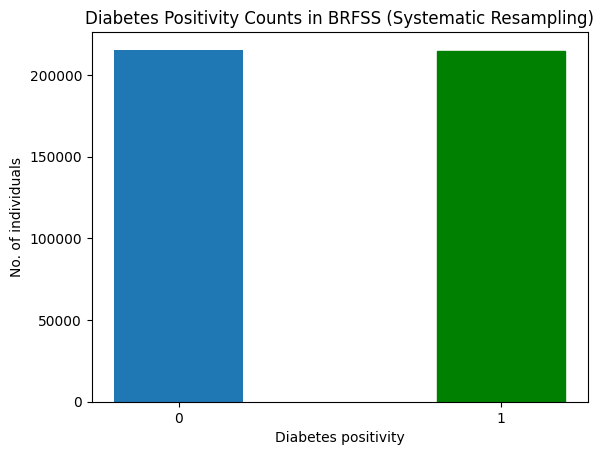

In [ ]:
barlist = plt.bar([str(0),str(1)], y_S_Sy.value_counts(), width = 0.4)
barlist[1].set_color('g')

plt.xlabel("Diabetes positivity")
plt.ylabel("No. of individuals")
plt.title("Diabetes Positivity Counts in BRFSS (Systematic Resampling)")
plt.show()

In [ ]:
X_S_train, X_S_test, y_S_train, y_S_test = train_test_split(X_S_Sy, y_S_Sy, test_size=0.20, random_state=0)

In [ ]:
model_source_Sy_ROS = create_dnn_model(X_S_train.shape[1])

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/10
8597/8597 ━━━━━━━━━━━━━━━━━━━━ 25s 3ms/step - AUC: 0.8101 - loss: 0.5266 - val_AUC: 0.8296 - val_loss: 0.5050
Epoch 2/10
8597/8597 ━━━━━━━━━━━━━━━━━━━━ 40s 3ms/step - AUC: 0.8243 - loss: 0.5091 - val_AUC: 0.8312 - val_loss: 0.5015
Epoch 3/10
8597/8597 ━━━━━━━━━━━━━━━━━━━━ 41s 3ms/step - AUC: 0.8270 - loss: 0.5052 - val_AUC: 0.8323 - val_loss: 0.4994
Epoch 4/10
8597/8597 ━━━━━━━━━━━━━━━━━━━━ 21s 2ms/step - AUC: 0.8304 - loss: 0.5010 - val_AUC: 0.8315 - val_loss: 0.5008
Epoch 5/10
8597/8597 ━━━━━━━━━━━━━━━━━━━━ 22s 3ms/step - AUC: 0.8306 - loss: 0.5005 - val_AUC: 0.8330 - val_loss: 0.4989
Epoch 6/10
8597/8597 ━━━━━━━━━━━━━━━━━━━━ 41s 3ms/step - AUC: 0.8315 - loss: 0.4992 - val_AUC: 0.8327 - val_loss: 0.4999
Epoch 7/10
8597/8597 ━━━━━━━━━━━━━━━━━━━━ 24s 3ms/step - AUC: 0.8321 - loss: 0.4979 - val_AUC: 0.8333 - val_loss: 0.4977
Epoch 8/10
8597/8597 ━━━━━━━━━━━━━━━━━━━━ 23s 3ms/step - AUC: 0.8329 - loss: 0.4976 - val_AUC: 0.8342 - val_loss: 0.4977
Epoch 9/10
8597/8597 ━━━━━━━━━━━

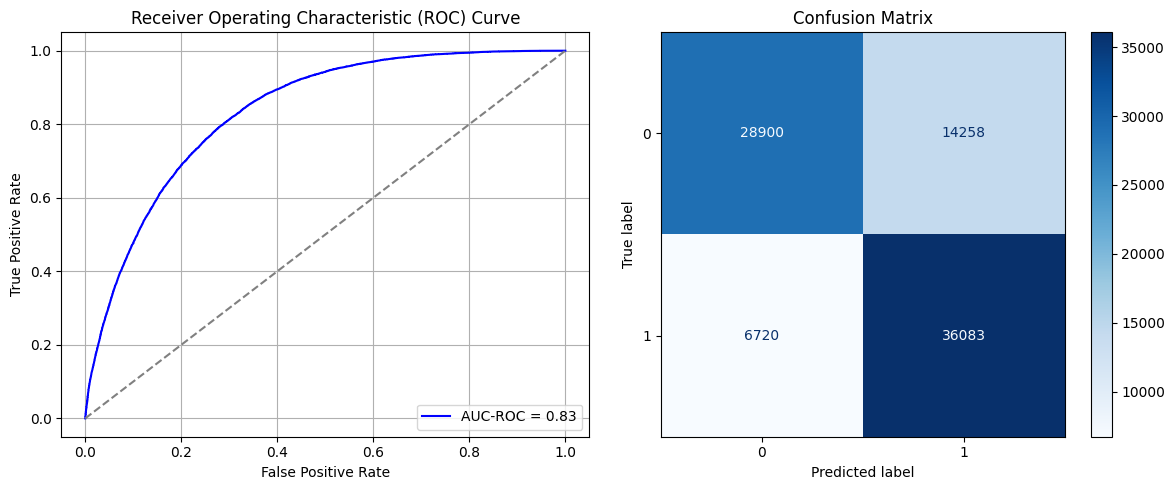

Best threshold based on F1-score: 0.4436500668525696
Time elapsed (performance): 313.1800040859998


In [ ]:
train_and_evaluate(model_source_Sy_ROS, X_S_train, X_S_test, y_S_train, y_S_test, "Source")

132/132 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
AUC-ROC: 0.7551079066197425
Classification Report:
              precision    recall  f1-score   support

           0       0.93      0.34      0.49      2987
           1       0.37      0.94      0.53      1230

    accuracy                           0.51      4217
   macro avg       0.65      0.64      0.51      4217
weighted avg       0.77      0.51      0.50      4217

FPR 0.6628724472715098 TPR: 0.33712755272849015 FNR: 0.06260162601626017 TNR: 0.9373983739837398


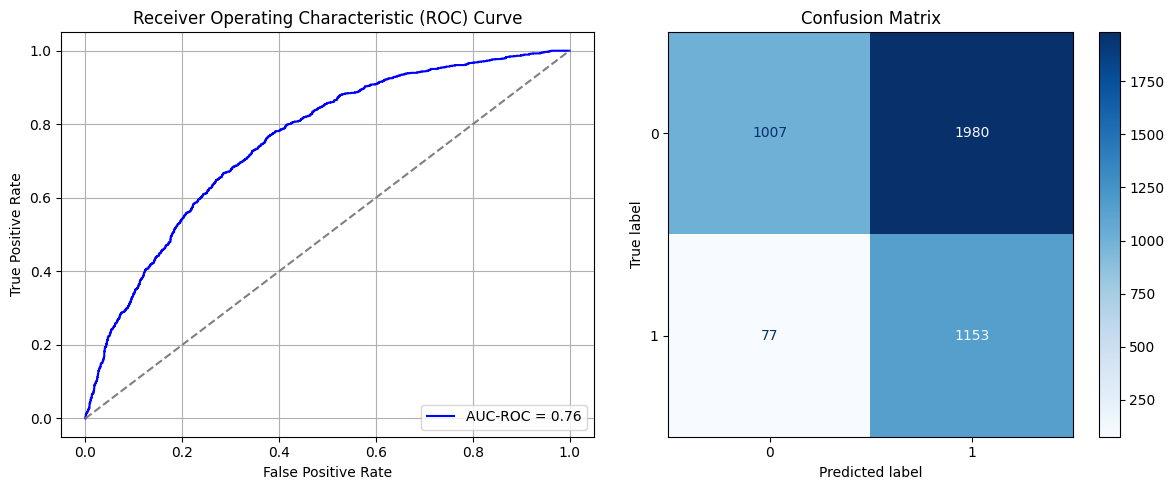

Best threshold based on F1-score: 0.7182944416999817
False Negative Rate: 0.06260162601626017
Time elapsed (performance): 0.9245279090000622


In [ ]:
Transductive_TL(model_source_Sy_ROS, X_T_full, y_T_full, "Target")